In [1]:
import sys
import time
from Utils import *
from tqdm import *
from attentive import attention_reader
from glob import glob
import os
from collections import Counter
from matplotlib import pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn

## Loading Data Process

In [2]:
# parameters for training load_dataset
data_dir = './data'
dataset_name = 'cnn'
sub_dataset_train = 'training'
sub_data_size_train = 38000

In [3]:
train_d, train_q, d_len, q_len, y  = load_dataset(data_dir, dataset_name, sub_data_size_train,sub_dataset_train)
num_train = len(train_d)
print('Number of training: ', num_train)

38000it [03:33, 178.27it/s] 

Number of training:  38000


In [4]:
# parameters for validation load_dataset
sub_dataset_dev = 'validation'
sub_data_size_dev = 3000

In [5]:
dev_d, dev_q, dev_len, qev_len, y_dev = load_dataset(data_dir, dataset_name, sub_data_size_dev,sub_dataset_dev)
num_dev = len(dev_d)
print('Number of validation:', num_dev)

3000it [00:06, 459.20it/s] 

Number of validation: 3000


In [6]:
doc_maxlen_train = max(d_len)
query_maxlen_train = max(q_len)
doc_maxlen_dev = max(dev_len)
query_maxlen_dev = max(qev_len)
doc_avelen_train = np.ceil(np.mean(d_len))
query_avelen_train = np.ceil(np.mean(q_len))
doc_avelen_dev = np.ceil(np.mean(dev_len))
query_avelen_dev = np.ceil(np.mean(qev_len))
print('Document max len in train:', doc_maxlen_train, ',Query max len in train:', query_maxlen_train)
print('Document max len in validation:', doc_maxlen_dev, ',Query max len in validation:', query_maxlen_dev)
print('Document average len in train:', doc_avelen_train, ',Query average len in train:', query_avelen_train)
print('Document average len in validation:', doc_avelen_dev, ',Query average len in validation:', query_avelen_dev)

Document max len in train: 2000 ,Query max len in train: 37
Document max len in validation: 1989 ,Query max len in validation: 37
Document average len in train: 763.0 ,Query average len in train: 13.0
Document average len in validation: 762.0 ,Query average len in validation: 14.0


In [8]:
print('Build dictionary..')
word_dict = build_dict(train_d + train_q,max_words=80000)
entity_markers = list(set([w for w in word_dict.keys() if w.startswith('@entity')] + y))
entity_markers = ['<unk_entity>'] + entity_markers
entity_dict = {w: index for (index, w) in enumerate(entity_markers)}
print('Entity markers: %d' % len(entity_dict))
num_labels = len(entity_dict)

Build dictionary..
#Words: 77851 -> 77851
('the', 1540432)
(',', 1375138)
('.', 1178689)
('to', 720729)
('"', 698114)
...
('mini-pc', 1)
('oppenent', 1)
('bbt', 1)
('5:11pm', 1)
('ex-head', 1)
Entity markers: 468


In [9]:
# parameters for embedding matrix
vocab_size = max(word_dict.values()) + 1 
embd_size = 100
print('vocab size:', vocab_size)
print('embedding dim:', embd_size)

vocab size: 77853
embedding dim: 100


In [10]:
glove_embd_w = load_glove_weights('./Embedding', embd_size, vocab_size, word_dict)

Found 400000 word vectors.
embed_matrix.shape (77853, 100)


In [11]:
# prepate the training data 
train_x1, train_x2, train_l, train_y = vectorize(train_d, train_q, y, word_dict, entity_dict)

vectorize: Vectorization: processed 0 / 38000
vectorize: Vectorization: processed 1000 / 38000
vectorize: Vectorization: processed 2000 / 38000
vectorize: Vectorization: processed 3000 / 38000
vectorize: Vectorization: processed 4000 / 38000
vectorize: Vectorization: processed 5000 / 38000
vectorize: Vectorization: processed 6000 / 38000
vectorize: Vectorization: processed 7000 / 38000
vectorize: Vectorization: processed 8000 / 38000
vectorize: Vectorization: processed 9000 / 38000
vectorize: Vectorization: processed 10000 / 38000
vectorize: Vectorization: processed 11000 / 38000
vectorize: Vectorization: processed 12000 / 38000
vectorize: Vectorization: processed 13000 / 38000
vectorize: Vectorization: processed 14000 / 38000
vectorize: Vectorization: processed 15000 / 38000
vectorize: Vectorization: processed 16000 / 38000
vectorize: Vectorization: processed 17000 / 38000
vectorize: Vectorization: processed 18000 / 38000
vectorize: Vectorization: processed 19000 / 38000
vectorize: Ve

In [12]:
# prepate the validation data 
dev_x1, dev_x2, dev_l, dev_y = vectorize(dev_d, dev_q, y_dev, word_dict, entity_dict)

vectorize: Vectorization: processed 0 / 3000
vectorize: Vectorization: processed 1000 / 3000
vectorize: Vectorization: processed 2000 / 3000


In [13]:
rnn_type = 'lstm'
hidden_size = 256
dropout_rate_embd = 0.1
dropout_rate_d = 0.2
dropout_rate_q = 0.2
learning_rate = 0.001
batch_size = 32
optimizer_name = 'adam'
num_epoches = 25
eval_iter = 200
model_path = 'checkpoint/attreader.ckpt'

In [14]:
# padding and get each mini batch for training
all_train = gen_examples(train_x1, train_x2, train_l, train_y, batch_size)

In [15]:
# padding and get each mini batch for validation
all_dev = gen_examples(dev_x1, dev_x2, dev_l, dev_y, batch_size)

In [ ]:
train_loss,train_acc,dev_loss,dev_acc = attention_reader(rnn_type, hidden_size, dropout_rate_embd,dropout_rate_d,dropout_rate_q,learning_rate, batch_size, optimizer_name, num_epoches, eval_iter,
                     vocab_size, embd_size, glove_embd_w,num_labels, model_path,
                     all_train, all_dev)

--------------------------------------------------
Creating TF computation graph...
Using LSTM Cells
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Build the Model Done!
--------------------------------------------------
Initial Test...
Initial Dev Accuracy: 0.00 %
--------------------------------------------------
Start training...
Batch Si

Epoch = 0, Iter = 40 (max = 1188), Loss = 2.34, Elapsed Time = 55.491 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 567
Epoch = 0, Iter = 41 (max = 1188), Loss = 2.83, Elapsed Time = 56.433 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 693
Epoch = 0, Iter = 42 (max = 1188), Loss = 2.69, Elapsed Time = 57.572 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 642
Epoch = 0, Iter = 43 (max = 1188), Loss = 2.84, Elapsed Time = 58.611 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 791
Epoch = 0, Iter = 44 (max = 1188), Loss = 2.91, Elapsed Time = 59.860 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 369
Epoch = 0, Iter = 45 (max = 1188), Loss = 2.43, Elapsed Time = 60.494 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 248
Epoch = 0, Iter = 46 (max = 1188), Loss = 2.23, Elapsed Time = 60.923 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 912
Epoch = 0, Iter = 47 (max = 1188), L

Epoch = 0, Iter = 100 (max = 1188), Loss = 3.39, Elapsed Time = 127.785 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 477
Epoch = 0, Iter = 101 (max = 1188), Loss = 2.49, Elapsed Time = 128.570 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 958
Epoch = 0, Iter = 102 (max = 1188), Loss = 2.67, Elapsed Time = 130.107 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 641
Epoch = 0, Iter = 103 (max = 1188), Loss = 2.73, Elapsed Time = 131.157 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 552
Epoch = 0, Iter = 104 (max = 1188), Loss = 2.64, Elapsed Time = 132.069 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 500
Epoch = 0, Iter = 105 (max = 1188), Loss = 2.68, Elapsed Time = 132.915 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1742
Epoch = 0, Iter = 106 (max = 1188), Loss = 3.04, Elapsed Time = 135.630 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 504
Epoch = 0, Iter = 10

Epoch = 0, Iter = 159 (max = 1188), Loss = 3.34, Elapsed Time = 203.417 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1125
Epoch = 0, Iter = 160 (max = 1188), Loss = 3.02, Elapsed Time = 205.177 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1964
Epoch = 0, Iter = 161 (max = 1188), Loss = 3.47, Elapsed Time = 208.279 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 706
Epoch = 0, Iter = 162 (max = 1188), Loss = 2.81, Elapsed Time = 209.421 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 596
Epoch = 0, Iter = 163 (max = 1188), Loss = 2.77, Elapsed Time = 210.394 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 670
Epoch = 0, Iter = 164 (max = 1188), Loss = 2.67, Elapsed Time = 211.488 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 832
Epoch = 0, Iter = 165 (max = 1188), Loss = 2.55, Elapsed Time = 212.814 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 339
Epoch = 0, Iter = 

Epoch = 0, Iter = 217 (max = 1188), Loss = 2.52, Elapsed Time = 371.111 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 422
Epoch = 0, Iter = 218 (max = 1188), Loss = 2.62, Elapsed Time = 371.796 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 876
Epoch = 0, Iter = 219 (max = 1188), Loss = 3.03, Elapsed Time = 373.185 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 978
Epoch = 0, Iter = 220 (max = 1188), Loss = 2.61, Elapsed Time = 374.761 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1007
Epoch = 0, Iter = 221 (max = 1188), Loss = 2.68, Elapsed Time = 376.367 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1120
Epoch = 0, Iter = 222 (max = 1188), Loss = 3.59, Elapsed Time = 378.134 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 796
Epoch = 0, Iter = 223 (max = 1188), Loss = 2.88, Elapsed Time = 379.405 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 659
Epoch = 0, Iter = 224

Epoch = 0, Iter = 276 (max = 1188), Loss = 2.72, Elapsed Time = 436.546 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1048
Epoch = 0, Iter = 277 (max = 1188), Loss = 2.68, Elapsed Time = 438.219 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 895
Epoch = 0, Iter = 278 (max = 1188), Loss = 3.21, Elapsed Time = 439.684 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 838
Epoch = 0, Iter = 279 (max = 1188), Loss = 2.99, Elapsed Time = 441.054 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 730
Epoch = 0, Iter = 280 (max = 1188), Loss = 2.82, Elapsed Time = 442.230 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1071
Epoch = 0, Iter = 281 (max = 1188), Loss = 2.68, Elapsed Time = 443.950 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 165
Epoch = 0, Iter = 282 (max = 1188), Loss = 2.11, Elapsed Time = 444.245 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 1042
Epoch = 0, Iter = 2

Epoch = 0, Iter = 335 (max = 1188), Loss = 2.54, Elapsed Time = 505.423 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1243
Epoch = 0, Iter = 336 (max = 1188), Loss = 3.25, Elapsed Time = 507.357 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 651
Epoch = 0, Iter = 337 (max = 1188), Loss = 2.93, Elapsed Time = 508.429 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 858
Epoch = 0, Iter = 338 (max = 1188), Loss = 2.56, Elapsed Time = 509.791 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 735
Epoch = 0, Iter = 339 (max = 1188), Loss = 2.87, Elapsed Time = 510.968 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 0, Iter = 340 (max = 1188), Loss = 2.51, Elapsed Time = 511.416 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 579
Epoch = 0, Iter = 341 (max = 1188), Loss = 2.79, Elapsed Time = 512.343 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 962
Epoch = 0, Iter = 342 

Epoch = 0, Iter = 394 (max = 1188), Loss = 2.21, Elapsed Time = 577.986 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 288
Epoch = 0, Iter = 395 (max = 1188), Loss = 2.45, Elapsed Time = 578.488 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 329
Epoch = 0, Iter = 396 (max = 1188), Loss = 2.63, Elapsed Time = 579.062 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 553
Epoch = 0, Iter = 397 (max = 1188), Loss = 2.79, Elapsed Time = 579.996 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 607
Epoch = 0, Iter = 398 (max = 1188), Loss = 2.40, Elapsed Time = 580.971 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 338
Epoch = 0, Iter = 399 (max = 1188), Loss = 2.69, Elapsed Time = 581.546 (s), Acc = 15.62
Dev Accuracy: 13.97 %
Batch Size = 32, # of Examples = 32, max_len = 727
Epoch = 0, Iter = 400 (max = 1188), Loss = 2.91, Elapsed Time = 682.435 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 909

Epoch = 0, Iter = 453 (max = 1188), Loss = 2.69, Elapsed Time = 741.799 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 312
Epoch = 0, Iter = 454 (max = 1188), Loss = 2.43, Elapsed Time = 742.354 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 937
Epoch = 0, Iter = 455 (max = 1188), Loss = 2.73, Elapsed Time = 743.893 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 309
Epoch = 0, Iter = 456 (max = 1188), Loss = 2.28, Elapsed Time = 744.432 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1087
Epoch = 0, Iter = 457 (max = 1188), Loss = 2.70, Elapsed Time = 746.180 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1147
Epoch = 0, Iter = 458 (max = 1188), Loss = 2.83, Elapsed Time = 747.957 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1923
Epoch = 0, Iter = 459 (max = 1188), Loss = 3.17, Elapsed Time = 750.988 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1652
Epoch = 0, Iter 

Epoch = 0, Iter = 512 (max = 1188), Loss = 3.13, Elapsed Time = 822.111 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 754
Epoch = 0, Iter = 513 (max = 1188), Loss = 2.68, Elapsed Time = 823.335 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 458
Epoch = 0, Iter = 514 (max = 1188), Loss = 2.85, Elapsed Time = 824.103 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 337
Epoch = 0, Iter = 515 (max = 1188), Loss = 2.39, Elapsed Time = 824.672 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 971
Epoch = 0, Iter = 516 (max = 1188), Loss = 2.83, Elapsed Time = 826.230 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1383
Epoch = 0, Iter = 517 (max = 1188), Loss = 3.28, Elapsed Time = 828.414 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 0, Iter = 518 (max = 1188), Loss = 2.29, Elapsed Time = 828.785 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 732
Epoch = 0, Iter = 51

Epoch = 0, Iter = 571 (max = 1188), Loss = 3.26, Elapsed Time = 894.814 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 367
Epoch = 0, Iter = 572 (max = 1188), Loss = 2.55, Elapsed Time = 895.429 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 112
Epoch = 0, Iter = 573 (max = 1188), Loss = 2.09, Elapsed Time = 895.641 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 428
Epoch = 0, Iter = 574 (max = 1188), Loss = 2.31, Elapsed Time = 896.358 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 834
Epoch = 0, Iter = 575 (max = 1188), Loss = 2.65, Elapsed Time = 897.711 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 390
Epoch = 0, Iter = 576 (max = 1188), Loss = 2.57, Elapsed Time = 898.360 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1715
Epoch = 0, Iter = 577 (max = 1188), Loss = 3.48, Elapsed Time = 901.055 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 603
Epoch = 0, Iter = 57

Epoch = 0, Iter = 629 (max = 1188), Loss = 2.94, Elapsed Time = 1067.799 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 330
Epoch = 0, Iter = 630 (max = 1188), Loss = 2.43, Elapsed Time = 1068.379 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 719
Epoch = 0, Iter = 631 (max = 1188), Loss = 2.78, Elapsed Time = 1069.604 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 668
Epoch = 0, Iter = 632 (max = 1188), Loss = 2.38, Elapsed Time = 1070.697 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 200
Epoch = 0, Iter = 633 (max = 1188), Loss = 2.41, Elapsed Time = 1071.069 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 465
Epoch = 0, Iter = 634 (max = 1188), Loss = 2.54, Elapsed Time = 1071.852 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 831
Epoch = 0, Iter = 635 (max = 1188), Loss = 2.95, Elapsed Time = 1073.199 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1368
Epoch = 0, It

Epoch = 0, Iter = 688 (max = 1188), Loss = 2.66, Elapsed Time = 1151.725 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 455
Epoch = 0, Iter = 689 (max = 1188), Loss = 2.48, Elapsed Time = 1152.470 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 417
Epoch = 0, Iter = 690 (max = 1188), Loss = 2.62, Elapsed Time = 1153.180 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 974
Epoch = 0, Iter = 691 (max = 1188), Loss = 2.78, Elapsed Time = 1154.776 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 282
Epoch = 0, Iter = 692 (max = 1188), Loss = 2.51, Elapsed Time = 1155.252 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 168
Epoch = 0, Iter = 693 (max = 1188), Loss = 2.19, Elapsed Time = 1155.562 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 482
Epoch = 0, Iter = 694 (max = 1188), Loss = 2.51, Elapsed Time = 1156.346 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 476
Epoch = 0, Ite

Epoch = 0, Iter = 747 (max = 1188), Loss = 2.33, Elapsed Time = 1216.164 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 925
Epoch = 0, Iter = 748 (max = 1188), Loss = 2.66, Elapsed Time = 1217.654 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 232
Epoch = 0, Iter = 749 (max = 1188), Loss = 2.37, Elapsed Time = 1218.095 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 840
Epoch = 0, Iter = 750 (max = 1188), Loss = 2.87, Elapsed Time = 1219.413 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 541
Epoch = 0, Iter = 751 (max = 1188), Loss = 2.65, Elapsed Time = 1220.289 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 740
Epoch = 0, Iter = 752 (max = 1188), Loss = 2.42, Elapsed Time = 1221.511 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 343
Epoch = 0, Iter = 753 (max = 1188), Loss = 2.22, Elapsed Time = 1222.100 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1392
Epoch = 0, I

Epoch = 0, Iter = 805 (max = 1188), Loss = 2.83, Elapsed Time = 1389.248 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 234
Epoch = 0, Iter = 806 (max = 1188), Loss = 2.39, Elapsed Time = 1389.658 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 953
Epoch = 0, Iter = 807 (max = 1188), Loss = 2.56, Elapsed Time = 1391.167 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 497
Epoch = 0, Iter = 808 (max = 1188), Loss = 2.60, Elapsed Time = 1391.972 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 383
Epoch = 0, Iter = 809 (max = 1188), Loss = 2.79, Elapsed Time = 1392.607 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1000
Epoch = 0, Iter = 810 (max = 1188), Loss = 3.06, Elapsed Time = 1394.234 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 300
Epoch = 0, Iter = 811 (max = 1188), Loss = 2.07, Elapsed Time = 1394.752 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 707
Epoch = 0, I

Epoch = 0, Iter = 864 (max = 1188), Loss = 2.51, Elapsed Time = 1458.792 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1589
Epoch = 0, Iter = 865 (max = 1188), Loss = 2.95, Elapsed Time = 1461.299 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 981
Epoch = 0, Iter = 866 (max = 1188), Loss = 2.88, Elapsed Time = 1462.866 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1809
Epoch = 0, Iter = 867 (max = 1188), Loss = 3.25, Elapsed Time = 1465.700 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 564
Epoch = 0, Iter = 868 (max = 1188), Loss = 2.47, Elapsed Time = 1466.642 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 365
Epoch = 0, Iter = 869 (max = 1188), Loss = 2.77, Elapsed Time = 1467.266 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 533
Epoch = 0, Iter = 870 (max = 1188), Loss = 2.46, Elapsed Time = 1468.136 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 609
Epoch = 0, 

Epoch = 0, Iter = 923 (max = 1188), Loss = 2.39, Elapsed Time = 1535.261 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 619
Epoch = 0, Iter = 924 (max = 1188), Loss = 2.65, Elapsed Time = 1536.255 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 930
Epoch = 0, Iter = 925 (max = 1188), Loss = 2.96, Elapsed Time = 1537.729 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 700
Epoch = 0, Iter = 926 (max = 1188), Loss = 2.43, Elapsed Time = 1538.856 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 713
Epoch = 0, Iter = 927 (max = 1188), Loss = 2.75, Elapsed Time = 1540.015 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 154
Epoch = 0, Iter = 928 (max = 1188), Loss = 2.07, Elapsed Time = 1540.298 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 732
Epoch = 0, Iter = 929 (max = 1188), Loss = 2.58, Elapsed Time = 1541.453 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 662
Epoch = 0, It

Epoch = 0, Iter = 982 (max = 1188), Loss = 2.94, Elapsed Time = 1601.998 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1429
Epoch = 0, Iter = 983 (max = 1188), Loss = 3.11, Elapsed Time = 1604.258 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 406
Epoch = 0, Iter = 984 (max = 1188), Loss = 2.49, Elapsed Time = 1604.935 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1137
Epoch = 0, Iter = 985 (max = 1188), Loss = 2.66, Elapsed Time = 1606.723 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 490
Epoch = 0, Iter = 986 (max = 1188), Loss = 2.45, Elapsed Time = 1607.522 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1127
Epoch = 0, Iter = 987 (max = 1188), Loss = 2.91, Elapsed Time = 1609.323 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 397
Epoch = 0, Iter = 988 (max = 1188), Loss = 2.41, Elapsed Time = 1609.962 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 916
Epoch = 0,

Epoch = 0, Iter = 1040 (max = 1188), Loss = 2.63, Elapsed Time = 1779.597 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 520
Epoch = 0, Iter = 1041 (max = 1188), Loss = 2.51, Elapsed Time = 1780.422 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 704
Epoch = 0, Iter = 1042 (max = 1188), Loss = 2.49, Elapsed Time = 1781.565 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 718
Epoch = 0, Iter = 1043 (max = 1188), Loss = 2.43, Elapsed Time = 1782.730 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1083
Epoch = 0, Iter = 1044 (max = 1188), Loss = 2.85, Elapsed Time = 1784.421 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 1016
Epoch = 0, Iter = 1045 (max = 1188), Loss = 2.69, Elapsed Time = 1785.998 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 241
Epoch = 0, Iter = 1046 (max = 1188), Loss = 2.47, Elapsed Time = 1786.460 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 427
Epoch 

Epoch = 0, Iter = 1098 (max = 1188), Loss = 2.66, Elapsed Time = 1851.024 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1171
Epoch = 0, Iter = 1099 (max = 1188), Loss = 2.78, Elapsed Time = 1852.858 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 683
Epoch = 0, Iter = 1100 (max = 1188), Loss = 2.59, Elapsed Time = 1853.962 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 348
Epoch = 0, Iter = 1101 (max = 1188), Loss = 2.35, Elapsed Time = 1854.553 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1030
Epoch = 0, Iter = 1102 (max = 1188), Loss = 3.23, Elapsed Time = 1856.194 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 452
Epoch = 0, Iter = 1103 (max = 1188), Loss = 2.53, Elapsed Time = 1856.963 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 913
Epoch = 0, Iter = 1104 (max = 1188), Loss = 2.49, Elapsed Time = 1858.405 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1195
Epoch

Epoch = 0, Iter = 1156 (max = 1188), Loss = 2.52, Elapsed Time = 1925.625 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 685
Epoch = 0, Iter = 1157 (max = 1188), Loss = 2.47, Elapsed Time = 1926.730 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 845
Epoch = 0, Iter = 1158 (max = 1188), Loss = 2.35, Elapsed Time = 1928.075 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1268
Epoch = 0, Iter = 1159 (max = 1188), Loss = 2.68, Elapsed Time = 1930.081 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1440
Epoch = 0, Iter = 1160 (max = 1188), Loss = 3.12, Elapsed Time = 1932.319 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 266
Epoch = 0, Iter = 1161 (max = 1188), Loss = 2.34, Elapsed Time = 1932.780 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 637
Epoch = 0, Iter = 1162 (max = 1188), Loss = 2.69, Elapsed Time = 1933.816 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 472
Epoc

Epoch = 1, Iter = 27 (max = 1188), Loss = 2.48, Elapsed Time = 31.584 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1556
Epoch = 1, Iter = 28 (max = 1188), Loss = 3.09, Elapsed Time = 34.053 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 773
Epoch = 1, Iter = 29 (max = 1188), Loss = 3.03, Elapsed Time = 35.298 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 558
Epoch = 1, Iter = 30 (max = 1188), Loss = 2.36, Elapsed Time = 36.219 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1223
Epoch = 1, Iter = 31 (max = 1188), Loss = 3.07, Elapsed Time = 38.182 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 521
Epoch = 1, Iter = 32 (max = 1188), Loss = 2.72, Elapsed Time = 39.030 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 481
Epoch = 1, Iter = 33 (max = 1188), Loss = 2.51, Elapsed Time = 39.853 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 400
Epoch = 1, Iter = 34 (max = 1188),

Epoch = 1, Iter = 87 (max = 1188), Loss = 2.36, Elapsed Time = 108.639 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 903
Epoch = 1, Iter = 88 (max = 1188), Loss = 2.75, Elapsed Time = 110.086 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1264
Epoch = 1, Iter = 89 (max = 1188), Loss = 3.04, Elapsed Time = 112.104 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 701
Epoch = 1, Iter = 90 (max = 1188), Loss = 3.04, Elapsed Time = 113.268 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 161
Epoch = 1, Iter = 91 (max = 1188), Loss = 2.26, Elapsed Time = 113.563 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1667
Epoch = 1, Iter = 92 (max = 1188), Loss = 3.41, Elapsed Time = 116.187 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 1262
Epoch = 1, Iter = 93 (max = 1188), Loss = 3.10, Elapsed Time = 118.210 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 392
Epoch = 1, Iter = 94 (max 

Epoch = 1, Iter = 146 (max = 1188), Loss = 3.42, Elapsed Time = 182.647 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 849
Epoch = 1, Iter = 147 (max = 1188), Loss = 3.01, Elapsed Time = 184.004 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 643
Epoch = 1, Iter = 148 (max = 1188), Loss = 2.73, Elapsed Time = 185.083 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 772
Epoch = 1, Iter = 149 (max = 1188), Loss = 2.76, Elapsed Time = 186.366 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 1380
Epoch = 1, Iter = 150 (max = 1188), Loss = 3.00, Elapsed Time = 188.539 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1619
Epoch = 1, Iter = 151 (max = 1188), Loss = 3.09, Elapsed Time = 191.128 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 792
Epoch = 1, Iter = 152 (max = 1188), Loss = 3.05, Elapsed Time = 192.412 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 785
Epoch = 1, Iter = 153 (m

Epoch = 1, Iter = 205 (max = 1188), Loss = 2.93, Elapsed Time = 357.539 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 282
Epoch = 1, Iter = 206 (max = 1188), Loss = 2.53, Elapsed Time = 358.019 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 384
Epoch = 1, Iter = 207 (max = 1188), Loss = 2.40, Elapsed Time = 358.664 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 441
Epoch = 1, Iter = 208 (max = 1188), Loss = 2.74, Elapsed Time = 359.393 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 579
Epoch = 1, Iter = 209 (max = 1188), Loss = 2.76, Elapsed Time = 360.335 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1964
Epoch = 1, Iter = 210 (max = 1188), Loss = 3.41, Elapsed Time = 363.440 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1234
Epoch = 1, Iter = 211 (max = 1188), Loss = 2.86, Elapsed Time = 365.431 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 348
Epoch = 1, Iter = 

Epoch = 1, Iter = 264 (max = 1188), Loss = 2.84, Elapsed Time = 425.183 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 665
Epoch = 1, Iter = 265 (max = 1188), Loss = 2.62, Elapsed Time = 426.289 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 973
Epoch = 1, Iter = 266 (max = 1188), Loss = 2.60, Elapsed Time = 427.828 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 1686
Epoch = 1, Iter = 267 (max = 1188), Loss = 3.08, Elapsed Time = 430.557 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 498
Epoch = 1, Iter = 268 (max = 1188), Loss = 2.53, Elapsed Time = 431.372 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 367
Epoch = 1, Iter = 269 (max = 1188), Loss = 2.51, Elapsed Time = 431.990 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1501
Epoch = 1, Iter = 270 (max = 1188), Loss = 3.01, Elapsed Time = 434.348 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 1, Iter = 27

Epoch = 1, Iter = 323 (max = 1188), Loss = 2.54, Elapsed Time = 497.855 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1468
Epoch = 1, Iter = 324 (max = 1188), Loss = 2.58, Elapsed Time = 500.154 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1582
Epoch = 1, Iter = 325 (max = 1188), Loss = 3.21, Elapsed Time = 502.668 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 977
Epoch = 1, Iter = 326 (max = 1188), Loss = 2.96, Elapsed Time = 504.267 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 506
Epoch = 1, Iter = 327 (max = 1188), Loss = 2.57, Elapsed Time = 505.090 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 406
Epoch = 1, Iter = 328 (max = 1188), Loss = 2.51, Elapsed Time = 505.768 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 298
Epoch = 1, Iter = 329 (max = 1188), Loss = 2.57, Elapsed Time = 506.281 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 587
Epoch = 1, Iter = 

Epoch = 1, Iter = 382 (max = 1188), Loss = 2.42, Elapsed Time = 571.305 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 901
Epoch = 1, Iter = 383 (max = 1188), Loss = 3.12, Elapsed Time = 572.788 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 654
Epoch = 1, Iter = 384 (max = 1188), Loss = 2.53, Elapsed Time = 573.815 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 613
Epoch = 1, Iter = 385 (max = 1188), Loss = 2.72, Elapsed Time = 574.792 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 947
Epoch = 1, Iter = 386 (max = 1188), Loss = 2.95, Elapsed Time = 576.311 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 491
Epoch = 1, Iter = 387 (max = 1188), Loss = 2.49, Elapsed Time = 577.127 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1253
Epoch = 1, Iter = 388 (max = 1188), Loss = 2.87, Elapsed Time = 579.121 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 360
Epoch = 1, Iter = 38

Epoch = 1, Iter = 440 (max = 1188), Loss = 2.27, Elapsed Time = 740.532 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 281
Epoch = 1, Iter = 441 (max = 1188), Loss = 2.30, Elapsed Time = 741.002 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1022
Epoch = 1, Iter = 442 (max = 1188), Loss = 2.61, Elapsed Time = 742.650 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 567
Epoch = 1, Iter = 443 (max = 1188), Loss = 2.55, Elapsed Time = 743.583 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 530
Epoch = 1, Iter = 444 (max = 1188), Loss = 2.48, Elapsed Time = 744.441 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 783
Epoch = 1, Iter = 445 (max = 1188), Loss = 2.69, Elapsed Time = 745.673 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1215
Epoch = 1, Iter = 446 (max = 1188), Loss = 3.34, Elapsed Time = 747.612 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 295
Epoch = 1, Iter = 44

Epoch = 1, Iter = 499 (max = 1188), Loss = 3.03, Elapsed Time = 820.805 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 315
Epoch = 1, Iter = 500 (max = 1188), Loss = 2.38, Elapsed Time = 821.352 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 187
Epoch = 1, Iter = 501 (max = 1188), Loss = 2.12, Elapsed Time = 821.697 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 599
Epoch = 1, Iter = 502 (max = 1188), Loss = 2.71, Elapsed Time = 822.670 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 980
Epoch = 1, Iter = 503 (max = 1188), Loss = 3.13, Elapsed Time = 824.248 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 1419
Epoch = 1, Iter = 504 (max = 1188), Loss = 3.17, Elapsed Time = 826.481 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1769
Epoch = 1, Iter = 505 (max = 1188), Loss = 3.20, Elapsed Time = 829.213 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 682
Epoch = 1, Iter = 50

Epoch = 1, Iter = 558 (max = 1188), Loss = 2.71, Elapsed Time = 889.175 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1047
Epoch = 1, Iter = 559 (max = 1188), Loss = 3.13, Elapsed Time = 890.870 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 1601
Epoch = 1, Iter = 560 (max = 1188), Loss = 3.23, Elapsed Time = 893.331 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 575
Epoch = 1, Iter = 561 (max = 1188), Loss = 2.34, Elapsed Time = 894.262 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 832
Epoch = 1, Iter = 562 (max = 1188), Loss = 2.58, Elapsed Time = 895.574 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 212
Epoch = 1, Iter = 563 (max = 1188), Loss = 2.19, Elapsed Time = 895.943 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1198
Epoch = 1, Iter = 564 (max = 1188), Loss = 3.34, Elapsed Time = 897.832 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 1334
Epoch = 1, Iter = 

Epoch = 1, Iter = 617 (max = 1188), Loss = 2.61, Elapsed Time = 1057.462 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 672
Epoch = 1, Iter = 618 (max = 1188), Loss = 2.89, Elapsed Time = 1058.505 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 981
Epoch = 1, Iter = 619 (max = 1188), Loss = 2.89, Elapsed Time = 1060.050 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1190
Epoch = 1, Iter = 620 (max = 1188), Loss = 2.98, Elapsed Time = 1061.927 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 986
Epoch = 1, Iter = 621 (max = 1188), Loss = 2.98, Elapsed Time = 1063.481 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 640
Epoch = 1, Iter = 622 (max = 1188), Loss = 2.62, Elapsed Time = 1064.515 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 920
Epoch = 1, Iter = 623 (max = 1188), Loss = 2.75, Elapsed Time = 1066.013 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 857
Epoch = 1, Ite

Epoch = 1, Iter = 676 (max = 1188), Loss = 2.74, Elapsed Time = 1129.411 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 497
Epoch = 1, Iter = 677 (max = 1188), Loss = 2.52, Elapsed Time = 1130.215 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1122
Epoch = 1, Iter = 678 (max = 1188), Loss = 2.97, Elapsed Time = 1131.917 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 567
Epoch = 1, Iter = 679 (max = 1188), Loss = 2.78, Elapsed Time = 1132.800 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1539
Epoch = 1, Iter = 680 (max = 1188), Loss = 2.79, Elapsed Time = 1135.132 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 633
Epoch = 1, Iter = 681 (max = 1188), Loss = 2.51, Elapsed Time = 1136.165 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 238
Epoch = 1, Iter = 682 (max = 1188), Loss = 2.07, Elapsed Time = 1136.566 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 577
Epoch = 1, I

Epoch = 1, Iter = 735 (max = 1188), Loss = 2.18, Elapsed Time = 1200.009 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1816
Epoch = 1, Iter = 736 (max = 1188), Loss = 3.09, Elapsed Time = 1202.746 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 397
Epoch = 1, Iter = 737 (max = 1188), Loss = 2.34, Elapsed Time = 1203.391 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 663
Epoch = 1, Iter = 738 (max = 1188), Loss = 2.44, Elapsed Time = 1204.434 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1312
Epoch = 1, Iter = 739 (max = 1188), Loss = 2.74, Elapsed Time = 1206.450 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 573
Epoch = 1, Iter = 740 (max = 1188), Loss = 2.67, Elapsed Time = 1207.371 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1147
Epoch = 1, Iter = 741 (max = 1188), Loss = 2.87, Elapsed Time = 1209.160 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 876
Epoch = 1,

Epoch = 1, Iter = 794 (max = 1188), Loss = 2.93, Elapsed Time = 1277.792 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1064
Epoch = 1, Iter = 795 (max = 1188), Loss = 2.74, Elapsed Time = 1279.470 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 830
Epoch = 1, Iter = 796 (max = 1188), Loss = 2.39, Elapsed Time = 1280.749 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 704
Epoch = 1, Iter = 797 (max = 1188), Loss = 2.83, Elapsed Time = 1281.856 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 588
Epoch = 1, Iter = 798 (max = 1188), Loss = 2.65, Elapsed Time = 1282.794 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 769
Epoch = 1, Iter = 799 (max = 1188), Loss = 2.79, Elapsed Time = 1283.981 (s), Acc = 25.00
Dev Accuracy: 12.33 %
Batch Size = 16, # of Examples = 16, max_len = 2000
Epoch = 1, Iter = 800 (max = 1188), Loss = 2.96, Elapsed Time = 1384.201 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_

Epoch = 1, Iter = 852 (max = 1188), Loss = 2.60, Elapsed Time = 1440.159 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1566
Epoch = 1, Iter = 853 (max = 1188), Loss = 2.96, Elapsed Time = 1442.592 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 271
Epoch = 1, Iter = 854 (max = 1188), Loss = 2.13, Elapsed Time = 1443.057 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1236
Epoch = 1, Iter = 855 (max = 1188), Loss = 2.90, Elapsed Time = 1445.023 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 649
Epoch = 1, Iter = 856 (max = 1188), Loss = 2.84, Elapsed Time = 1446.058 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1809
Epoch = 1, Iter = 857 (max = 1188), Loss = 3.24, Elapsed Time = 1448.922 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 1119
Epoch = 1, Iter = 858 (max = 1188), Loss = 2.82, Elapsed Time = 1450.704 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 623
Epoch = 1,

Epoch = 1, Iter = 911 (max = 1188), Loss = 2.61, Elapsed Time = 1516.426 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 890
Epoch = 1, Iter = 912 (max = 1188), Loss = 2.40, Elapsed Time = 1517.808 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 426
Epoch = 1, Iter = 913 (max = 1188), Loss = 2.26, Elapsed Time = 1518.512 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 521
Epoch = 1, Iter = 914 (max = 1188), Loss = 2.34, Elapsed Time = 1519.378 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 580
Epoch = 1, Iter = 915 (max = 1188), Loss = 2.67, Elapsed Time = 1520.324 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 899
Epoch = 1, Iter = 916 (max = 1188), Loss = 2.60, Elapsed Time = 1521.741 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1398
Epoch = 1, Iter = 917 (max = 1188), Loss = 2.83, Elapsed Time = 1523.927 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 275
Epoch = 1, I

Epoch = 1, Iter = 970 (max = 1188), Loss = 2.87, Elapsed Time = 1588.078 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 468
Epoch = 1, Iter = 971 (max = 1188), Loss = 2.44, Elapsed Time = 1588.859 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 685
Epoch = 1, Iter = 972 (max = 1188), Loss = 2.23, Elapsed Time = 1589.976 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 854
Epoch = 1, Iter = 973 (max = 1188), Loss = 3.11, Elapsed Time = 1591.302 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 326
Epoch = 1, Iter = 974 (max = 1188), Loss = 2.29, Elapsed Time = 1591.851 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 302
Epoch = 1, Iter = 975 (max = 1188), Loss = 2.22, Elapsed Time = 1592.361 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1448
Epoch = 1, Iter = 976 (max = 1188), Loss = 2.73, Elapsed Time = 1594.629 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1013
Epoch = 1, 

Epoch = 1, Iter = 1028 (max = 1188), Loss = 2.83, Elapsed Time = 1757.159 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1243
Epoch = 1, Iter = 1029 (max = 1188), Loss = 3.25, Elapsed Time = 1759.137 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 1176
Epoch = 1, Iter = 1030 (max = 1188), Loss = 3.53, Elapsed Time = 1761.021 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 626
Epoch = 1, Iter = 1031 (max = 1188), Loss = 2.57, Elapsed Time = 1762.042 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 508
Epoch = 1, Iter = 1032 (max = 1188), Loss = 2.69, Elapsed Time = 1762.880 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 318
Epoch = 1, Iter = 1033 (max = 1188), Loss = 2.45, Elapsed Time = 1763.400 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 443
Epoch = 1, Iter = 1034 (max = 1188), Loss = 2.76, Elapsed Time = 1764.124 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 424
Epoch 

Epoch = 1, Iter = 1086 (max = 1188), Loss = 3.00, Elapsed Time = 1833.550 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 564
Epoch = 1, Iter = 1087 (max = 1188), Loss = 2.47, Elapsed Time = 1834.481 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1054
Epoch = 1, Iter = 1088 (max = 1188), Loss = 2.88, Elapsed Time = 1836.177 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 798
Epoch = 1, Iter = 1089 (max = 1188), Loss = 2.72, Elapsed Time = 1837.486 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1058
Epoch = 1, Iter = 1090 (max = 1188), Loss = 2.67, Elapsed Time = 1839.162 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1516
Epoch = 1, Iter = 1091 (max = 1188), Loss = 3.39, Elapsed Time = 1841.493 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 992
Epoch = 1, Iter = 1092 (max = 1188), Loss = 2.86, Elapsed Time = 1843.030 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1070
Ep

Epoch = 1, Iter = 1144 (max = 1188), Loss = 2.52, Elapsed Time = 1901.976 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 808
Epoch = 1, Iter = 1145 (max = 1188), Loss = 2.34, Elapsed Time = 1903.257 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 795
Epoch = 1, Iter = 1146 (max = 1188), Loss = 2.37, Elapsed Time = 1904.512 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 571
Epoch = 1, Iter = 1147 (max = 1188), Loss = 2.28, Elapsed Time = 1905.450 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 937
Epoch = 1, Iter = 1148 (max = 1188), Loss = 2.64, Elapsed Time = 1906.949 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 847
Epoch = 1, Iter = 1149 (max = 1188), Loss = 2.67, Elapsed Time = 1908.280 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 789
Epoch = 1, Iter = 1150 (max = 1188), Loss = 2.63, Elapsed Time = 1909.564 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 862
Epoch 

Epoch = 2, Iter = 15 (max = 1188), Loss = 2.86, Elapsed Time = 19.628 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 300
Epoch = 2, Iter = 16 (max = 1188), Loss = 1.96, Elapsed Time = 20.140 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 480
Epoch = 2, Iter = 17 (max = 1188), Loss = 2.41, Elapsed Time = 20.932 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 2, Iter = 18 (max = 1188), Loss = 1.96, Elapsed Time = 21.270 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1954
Epoch = 2, Iter = 19 (max = 1188), Loss = 2.84, Elapsed Time = 24.343 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 960
Epoch = 2, Iter = 20 (max = 1188), Loss = 2.62, Elapsed Time = 25.908 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 2, Iter = 21 (max = 1188), Loss = 2.36, Elapsed Time = 26.432 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 527
Epoch = 2, Iter = 22 (max = 1188),

Epoch = 2, Iter = 75 (max = 1188), Loss = 2.84, Elapsed Time = 89.839 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 694
Epoch = 2, Iter = 76 (max = 1188), Loss = 2.42, Elapsed Time = 90.936 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 391
Epoch = 2, Iter = 77 (max = 1188), Loss = 1.94, Elapsed Time = 91.603 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 533
Epoch = 2, Iter = 78 (max = 1188), Loss = 2.40, Elapsed Time = 92.481 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 796
Epoch = 2, Iter = 79 (max = 1188), Loss = 2.82, Elapsed Time = 93.747 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 542
Epoch = 2, Iter = 80 (max = 1188), Loss = 2.40, Elapsed Time = 94.640 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1033
Epoch = 2, Iter = 81 (max = 1188), Loss = 2.92, Elapsed Time = 96.298 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 551
Epoch = 2, Iter = 82 (max = 1188),

Epoch = 2, Iter = 134 (max = 1188), Loss = 2.52, Elapsed Time = 157.176 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1606
Epoch = 2, Iter = 135 (max = 1188), Loss = 3.34, Elapsed Time = 159.697 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1136
Epoch = 2, Iter = 136 (max = 1188), Loss = 2.48, Elapsed Time = 161.462 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 230
Epoch = 2, Iter = 137 (max = 1188), Loss = 2.43, Elapsed Time = 161.904 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 293
Epoch = 2, Iter = 138 (max = 1188), Loss = 2.29, Elapsed Time = 162.416 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 283
Epoch = 2, Iter = 139 (max = 1188), Loss = 2.32, Elapsed Time = 162.893 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 669
Epoch = 2, Iter = 140 (max = 1188), Loss = 2.69, Elapsed Time = 163.971 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 548
Epoch = 2, Iter = 

Epoch = 2, Iter = 193 (max = 1188), Loss = 2.32, Elapsed Time = 223.122 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 463
Epoch = 2, Iter = 194 (max = 1188), Loss = 2.48, Elapsed Time = 223.885 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 359
Epoch = 2, Iter = 195 (max = 1188), Loss = 2.12, Elapsed Time = 224.478 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 498
Epoch = 2, Iter = 196 (max = 1188), Loss = 2.52, Elapsed Time = 225.298 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 623
Epoch = 2, Iter = 197 (max = 1188), Loss = 2.31, Elapsed Time = 226.309 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 287
Epoch = 2, Iter = 198 (max = 1188), Loss = 2.45, Elapsed Time = 226.800 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1228
Epoch = 2, Iter = 199 (max = 1188), Loss = 2.81, Elapsed Time = 228.738 (s), Acc = 18.75
Dev Accuracy: 16.10 %
Best Dev Accuracy: epoch = 2, n_updates (iter) =

Epoch = 2, Iter = 251 (max = 1188), Loss = 2.48, Elapsed Time = 389.908 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1524
Epoch = 2, Iter = 252 (max = 1188), Loss = 3.37, Elapsed Time = 392.273 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 444
Epoch = 2, Iter = 253 (max = 1188), Loss = 2.56, Elapsed Time = 393.002 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 546
Epoch = 2, Iter = 254 (max = 1188), Loss = 2.16, Elapsed Time = 393.895 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 363
Epoch = 2, Iter = 255 (max = 1188), Loss = 2.61, Elapsed Time = 394.495 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1589
Epoch = 2, Iter = 256 (max = 1188), Loss = 2.83, Elapsed Time = 397.021 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1787
Epoch = 2, Iter = 257 (max = 1188), Loss = 3.08, Elapsed Time = 399.773 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1300
Epoch = 2, Iter 

Epoch = 2, Iter = 310 (max = 1188), Loss = 2.89, Elapsed Time = 469.447 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 585
Epoch = 2, Iter = 311 (max = 1188), Loss = 2.86, Elapsed Time = 470.388 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 252
Epoch = 2, Iter = 312 (max = 1188), Loss = 2.40, Elapsed Time = 470.831 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 692
Epoch = 2, Iter = 313 (max = 1188), Loss = 2.83, Elapsed Time = 471.951 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 523
Epoch = 2, Iter = 314 (max = 1188), Loss = 2.70, Elapsed Time = 472.835 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 403
Epoch = 2, Iter = 315 (max = 1188), Loss = 2.12, Elapsed Time = 473.507 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 940
Epoch = 2, Iter = 316 (max = 1188), Loss = 3.07, Elapsed Time = 475.034 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1204
Epoch = 2, Iter = 3

Epoch = 2, Iter = 369 (max = 1188), Loss = 2.38, Elapsed Time = 545.168 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 339
Epoch = 2, Iter = 370 (max = 1188), Loss = 2.34, Elapsed Time = 545.750 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 247
Epoch = 2, Iter = 371 (max = 1188), Loss = 2.52, Elapsed Time = 546.197 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 627
Epoch = 2, Iter = 372 (max = 1188), Loss = 2.56, Elapsed Time = 547.236 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 286
Epoch = 2, Iter = 373 (max = 1188), Loss = 2.29, Elapsed Time = 547.725 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 560
Epoch = 2, Iter = 374 (max = 1188), Loss = 2.26, Elapsed Time = 548.668 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1019
Epoch = 2, Iter = 375 (max = 1188), Loss = 2.39, Elapsed Time = 550.361 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 552
Epoch = 2, Iter = 3

Epoch = 2, Iter = 428 (max = 1188), Loss = 2.70, Elapsed Time = 713.425 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1992
Epoch = 2, Iter = 429 (max = 1188), Loss = 3.21, Elapsed Time = 716.582 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 509
Epoch = 2, Iter = 430 (max = 1188), Loss = 2.48, Elapsed Time = 717.425 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 541
Epoch = 2, Iter = 431 (max = 1188), Loss = 2.58, Elapsed Time = 718.315 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 419
Epoch = 2, Iter = 432 (max = 1188), Loss = 2.37, Elapsed Time = 719.005 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 319
Epoch = 2, Iter = 433 (max = 1188), Loss = 2.42, Elapsed Time = 719.550 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 240
Epoch = 2, Iter = 434 (max = 1188), Loss = 2.56, Elapsed Time = 720.010 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 488
Epoch = 2, Iter = 4

Epoch = 2, Iter = 487 (max = 1188), Loss = 2.18, Elapsed Time = 788.176 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 422
Epoch = 2, Iter = 488 (max = 1188), Loss = 2.32, Elapsed Time = 788.890 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 626
Epoch = 2, Iter = 489 (max = 1188), Loss = 2.64, Elapsed Time = 789.910 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 259
Epoch = 2, Iter = 490 (max = 1188), Loss = 2.17, Elapsed Time = 790.368 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1058
Epoch = 2, Iter = 491 (max = 1188), Loss = 2.63, Elapsed Time = 792.057 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1497
Epoch = 2, Iter = 492 (max = 1188), Loss = 3.10, Elapsed Time = 794.412 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 473
Epoch = 2, Iter = 493 (max = 1188), Loss = 2.41, Elapsed Time = 795.208 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 536
Epoch = 2, Iter = 

Epoch = 2, Iter = 546 (max = 1188), Loss = 2.87, Elapsed Time = 870.603 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 996
Epoch = 2, Iter = 547 (max = 1188), Loss = 2.73, Elapsed Time = 872.212 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1137
Epoch = 2, Iter = 548 (max = 1188), Loss = 2.49, Elapsed Time = 874.034 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 986
Epoch = 2, Iter = 549 (max = 1188), Loss = 2.89, Elapsed Time = 875.558 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 290
Epoch = 2, Iter = 550 (max = 1188), Loss = 2.27, Elapsed Time = 876.059 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 423
Epoch = 2, Iter = 551 (max = 1188), Loss = 2.79, Elapsed Time = 876.791 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 400
Epoch = 2, Iter = 552 (max = 1188), Loss = 2.48, Elapsed Time = 877.457 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1105
Epoch = 2, Iter = 

Epoch = 2, Iter = 605 (max = 1188), Loss = 2.45, Elapsed Time = 1050.830 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1389
Epoch = 2, Iter = 606 (max = 1188), Loss = 3.10, Elapsed Time = 1053.019 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 265
Epoch = 2, Iter = 607 (max = 1188), Loss = 2.40, Elapsed Time = 1053.484 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 793
Epoch = 2, Iter = 608 (max = 1188), Loss = 2.62, Elapsed Time = 1054.774 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 378
Epoch = 2, Iter = 609 (max = 1188), Loss = 2.57, Elapsed Time = 1055.403 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 535
Epoch = 2, Iter = 610 (max = 1188), Loss = 2.30, Elapsed Time = 1056.289 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 517
Epoch = 2, Iter = 611 (max = 1188), Loss = 2.90, Elapsed Time = 1057.110 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 242
Epoch = 2, Ite

Epoch = 2, Iter = 664 (max = 1188), Loss = 2.23, Elapsed Time = 1123.073 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1914
Epoch = 2, Iter = 665 (max = 1188), Loss = 3.09, Elapsed Time = 1126.218 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 397
Epoch = 2, Iter = 666 (max = 1188), Loss = 2.35, Elapsed Time = 1126.863 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 865
Epoch = 2, Iter = 667 (max = 1188), Loss = 2.66, Elapsed Time = 1128.246 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 711
Epoch = 2, Iter = 668 (max = 1188), Loss = 2.52, Elapsed Time = 1129.420 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 957
Epoch = 2, Iter = 669 (max = 1188), Loss = 3.05, Elapsed Time = 1130.937 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 364
Epoch = 2, Iter = 670 (max = 1188), Loss = 2.44, Elapsed Time = 1131.559 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1131
Epoch = 2, 

Epoch = 2, Iter = 723 (max = 1188), Loss = 2.40, Elapsed Time = 1199.731 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 565
Epoch = 2, Iter = 724 (max = 1188), Loss = 2.66, Elapsed Time = 1200.658 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 927
Epoch = 2, Iter = 725 (max = 1188), Loss = 2.50, Elapsed Time = 1202.167 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 884
Epoch = 2, Iter = 726 (max = 1188), Loss = 2.62, Elapsed Time = 1203.567 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1143
Epoch = 2, Iter = 727 (max = 1188), Loss = 2.80, Elapsed Time = 1205.389 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 958
Epoch = 2, Iter = 728 (max = 1188), Loss = 2.52, Elapsed Time = 1206.892 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1012
Epoch = 2, Iter = 729 (max = 1188), Loss = 2.90, Elapsed Time = 1208.501 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1400
Epoch = 2,

Epoch = 2, Iter = 782 (max = 1188), Loss = 2.12, Elapsed Time = 1264.565 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 580
Epoch = 2, Iter = 783 (max = 1188), Loss = 2.64, Elapsed Time = 1265.502 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 128
Epoch = 2, Iter = 784 (max = 1188), Loss = 2.11, Elapsed Time = 1265.754 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 412
Epoch = 2, Iter = 785 (max = 1188), Loss = 2.30, Elapsed Time = 1266.445 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 158
Epoch = 2, Iter = 786 (max = 1188), Loss = 1.91, Elapsed Time = 1266.727 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 608
Epoch = 2, Iter = 787 (max = 1188), Loss = 2.29, Elapsed Time = 1267.715 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 437
Epoch = 2, Iter = 788 (max = 1188), Loss = 2.39, Elapsed Time = 1268.437 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 193
Epoch = 2, Ite

Epoch = 2, Iter = 840 (max = 1188), Loss = 2.71, Elapsed Time = 1430.834 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 636
Epoch = 2, Iter = 841 (max = 1188), Loss = 2.97, Elapsed Time = 1431.887 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1067
Epoch = 2, Iter = 842 (max = 1188), Loss = 2.92, Elapsed Time = 1433.580 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1290
Epoch = 2, Iter = 843 (max = 1188), Loss = 3.02, Elapsed Time = 1435.593 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 381
Epoch = 2, Iter = 844 (max = 1188), Loss = 2.46, Elapsed Time = 1436.249 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 861
Epoch = 2, Iter = 845 (max = 1188), Loss = 2.63, Elapsed Time = 1437.630 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 573
Epoch = 2, Iter = 846 (max = 1188), Loss = 2.56, Elapsed Time = 1438.565 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1601
Epoch = 2,

Epoch = 2, Iter = 899 (max = 1188), Loss = 3.61, Elapsed Time = 1508.076 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 353
Epoch = 2, Iter = 900 (max = 1188), Loss = 2.24, Elapsed Time = 1508.660 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1264
Epoch = 2, Iter = 901 (max = 1188), Loss = 3.01, Elapsed Time = 1510.631 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 375
Epoch = 2, Iter = 902 (max = 1188), Loss = 2.23, Elapsed Time = 1511.265 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 468
Epoch = 2, Iter = 903 (max = 1188), Loss = 2.37, Elapsed Time = 1512.051 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 226
Epoch = 2, Iter = 904 (max = 1188), Loss = 2.21, Elapsed Time = 1512.485 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1043
Epoch = 2, Iter = 905 (max = 1188), Loss = 3.07, Elapsed Time = 1514.129 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 999
Epoch = 2, 

Epoch = 2, Iter = 958 (max = 1188), Loss = 2.51, Elapsed Time = 1579.583 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 360
Epoch = 2, Iter = 959 (max = 1188), Loss = 2.25, Elapsed Time = 1580.197 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1294
Epoch = 2, Iter = 960 (max = 1188), Loss = 2.84, Elapsed Time = 1582.203 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1050
Epoch = 2, Iter = 961 (max = 1188), Loss = 2.60, Elapsed Time = 1583.832 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1578
Epoch = 2, Iter = 962 (max = 1188), Loss = 3.04, Elapsed Time = 1586.300 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 656
Epoch = 2, Iter = 963 (max = 1188), Loss = 2.41, Elapsed Time = 1587.327 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 824
Epoch = 2, Iter = 964 (max = 1188), Loss = 2.44, Elapsed Time = 1588.630 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 919
Epoch = 2,

Epoch = 2, Iter = 1016 (max = 1188), Loss = 2.53, Elapsed Time = 1751.099 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 895
Epoch = 2, Iter = 1017 (max = 1188), Loss = 3.06, Elapsed Time = 1752.502 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 970
Epoch = 2, Iter = 1018 (max = 1188), Loss = 2.49, Elapsed Time = 1754.085 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 431
Epoch = 2, Iter = 1019 (max = 1188), Loss = 2.43, Elapsed Time = 1754.830 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 677
Epoch = 2, Iter = 1020 (max = 1188), Loss = 2.70, Elapsed Time = 1755.926 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 795
Epoch = 2, Iter = 1021 (max = 1188), Loss = 2.33, Elapsed Time = 1757.182 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1459
Epoch = 2, Iter = 1022 (max = 1188), Loss = 3.07, Elapsed Time = 1759.441 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 512
Epoch

Epoch = 2, Iter = 1074 (max = 1188), Loss = 2.93, Elapsed Time = 1821.285 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 281
Epoch = 2, Iter = 1075 (max = 1188), Loss = 2.22, Elapsed Time = 1821.762 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 913
Epoch = 2, Iter = 1076 (max = 1188), Loss = 2.52, Elapsed Time = 1823.251 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 384
Epoch = 2, Iter = 1077 (max = 1188), Loss = 2.34, Elapsed Time = 1823.897 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1262
Epoch = 2, Iter = 1078 (max = 1188), Loss = 3.08, Elapsed Time = 1825.906 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1098
Epoch = 2, Iter = 1079 (max = 1188), Loss = 3.22, Elapsed Time = 1827.637 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 621
Epoch = 2, Iter = 1080 (max = 1188), Loss = 2.72, Elapsed Time = 1828.637 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1259
Epoc

Epoch = 2, Iter = 1132 (max = 1188), Loss = 2.86, Elapsed Time = 1893.554 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1796
Epoch = 2, Iter = 1133 (max = 1188), Loss = 3.03, Elapsed Time = 1896.367 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1174
Epoch = 2, Iter = 1134 (max = 1188), Loss = 2.97, Elapsed Time = 1898.227 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 782
Epoch = 2, Iter = 1135 (max = 1188), Loss = 2.67, Elapsed Time = 1899.496 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 654
Epoch = 2, Iter = 1136 (max = 1188), Loss = 2.46, Elapsed Time = 1900.563 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1422
Epoch = 2, Iter = 1137 (max = 1188), Loss = 3.14, Elapsed Time = 1902.832 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 618
Epoch = 2, Iter = 1138 (max = 1188), Loss = 2.36, Elapsed Time = 1903.850 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1365
Epo

Epoch = 3, Iter = 2 (max = 1188), Loss = 2.58, Elapsed Time = 5.260 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 439
Epoch = 3, Iter = 3 (max = 1188), Loss = 2.33, Elapsed Time = 5.984 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 257
Epoch = 3, Iter = 4 (max = 1188), Loss = 2.22, Elapsed Time = 6.427 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1176
Epoch = 3, Iter = 5 (max = 1188), Loss = 3.43, Elapsed Time = 8.252 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 703
Epoch = 3, Iter = 6 (max = 1188), Loss = 2.31, Elapsed Time = 9.408 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1307
Epoch = 3, Iter = 7 (max = 1188), Loss = 3.03, Elapsed Time = 11.521 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 641
Epoch = 3, Iter = 8 (max = 1188), Loss = 2.62, Elapsed Time = 12.581 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 649
Epoch = 3, Iter = 9 (max = 1188), Loss = 2.5

Epoch = 3, Iter = 62 (max = 1188), Loss = 2.83, Elapsed Time = 77.629 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 1114
Epoch = 3, Iter = 63 (max = 1188), Loss = 2.73, Elapsed Time = 79.467 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1051
Epoch = 3, Iter = 64 (max = 1188), Loss = 3.11, Elapsed Time = 81.168 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 549
Epoch = 3, Iter = 65 (max = 1188), Loss = 2.36, Elapsed Time = 82.094 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1436
Epoch = 3, Iter = 66 (max = 1188), Loss = 3.32, Elapsed Time = 84.409 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 939
Epoch = 3, Iter = 67 (max = 1188), Loss = 2.62, Elapsed Time = 85.920 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 735
Epoch = 3, Iter = 68 (max = 1188), Loss = 2.69, Elapsed Time = 87.120 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1004
Epoch = 3, Iter = 69 (max = 118

Epoch = 3, Iter = 121 (max = 1188), Loss = 2.31, Elapsed Time = 153.641 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 451
Epoch = 3, Iter = 122 (max = 1188), Loss = 2.66, Elapsed Time = 154.387 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 432
Epoch = 3, Iter = 123 (max = 1188), Loss = 2.64, Elapsed Time = 155.095 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 502
Epoch = 3, Iter = 124 (max = 1188), Loss = 2.26, Elapsed Time = 155.937 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1081
Epoch = 3, Iter = 125 (max = 1188), Loss = 3.02, Elapsed Time = 157.687 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 597
Epoch = 3, Iter = 126 (max = 1188), Loss = 2.48, Elapsed Time = 158.676 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 520
Epoch = 3, Iter = 127 (max = 1188), Loss = 2.41, Elapsed Time = 159.518 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 275
Epoch = 3, Iter = 12

Epoch = 3, Iter = 180 (max = 1188), Loss = 2.68, Elapsed Time = 222.268 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 740
Epoch = 3, Iter = 181 (max = 1188), Loss = 2.37, Elapsed Time = 223.471 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1230
Epoch = 3, Iter = 182 (max = 1188), Loss = 2.80, Elapsed Time = 225.443 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 667
Epoch = 3, Iter = 183 (max = 1188), Loss = 2.64, Elapsed Time = 226.557 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1132
Epoch = 3, Iter = 184 (max = 1188), Loss = 2.53, Elapsed Time = 228.389 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 150
Epoch = 3, Iter = 185 (max = 1188), Loss = 2.36, Elapsed Time = 228.663 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 919
Epoch = 3, Iter = 186 (max = 1188), Loss = 2.95, Elapsed Time = 230.140 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1491
Epoch = 3, Iter =

Epoch = 3, Iter = 238 (max = 1188), Loss = 2.57, Elapsed Time = 391.927 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 232
Epoch = 3, Iter = 239 (max = 1188), Loss = 2.30, Elapsed Time = 392.370 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 424
Epoch = 3, Iter = 240 (max = 1188), Loss = 2.37, Elapsed Time = 393.096 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 885
Epoch = 3, Iter = 241 (max = 1188), Loss = 2.83, Elapsed Time = 394.516 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1030
Epoch = 3, Iter = 242 (max = 1188), Loss = 3.02, Elapsed Time = 396.185 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 364
Epoch = 3, Iter = 243 (max = 1188), Loss = 2.42, Elapsed Time = 396.807 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 888
Epoch = 3, Iter = 244 (max = 1188), Loss = 2.72, Elapsed Time = 398.211 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1274
Epoch = 3, Iter = 

Epoch = 3, Iter = 297 (max = 1188), Loss = 2.34, Elapsed Time = 462.430 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1021
Epoch = 3, Iter = 298 (max = 1188), Loss = 2.87, Elapsed Time = 464.051 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1084
Epoch = 3, Iter = 299 (max = 1188), Loss = 2.88, Elapsed Time = 465.776 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 958
Epoch = 3, Iter = 300 (max = 1188), Loss = 2.41, Elapsed Time = 467.307 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 962
Epoch = 3, Iter = 301 (max = 1188), Loss = 2.84, Elapsed Time = 468.857 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 787
Epoch = 3, Iter = 302 (max = 1188), Loss = 2.70, Elapsed Time = 470.135 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1872
Epoch = 3, Iter = 303 (max = 1188), Loss = 3.41, Elapsed Time = 473.142 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 491
Epoch = 3, Iter =

Epoch = 3, Iter = 356 (max = 1188), Loss = 2.87, Elapsed Time = 537.414 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 909
Epoch = 3, Iter = 357 (max = 1188), Loss = 2.88, Elapsed Time = 538.861 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 336
Epoch = 3, Iter = 358 (max = 1188), Loss = 2.18, Elapsed Time = 539.433 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 412
Epoch = 3, Iter = 359 (max = 1188), Loss = 2.31, Elapsed Time = 540.104 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 436
Epoch = 3, Iter = 360 (max = 1188), Loss = 2.66, Elapsed Time = 540.817 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 473
Epoch = 3, Iter = 361 (max = 1188), Loss = 2.30, Elapsed Time = 541.607 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 523
Epoch = 3, Iter = 362 (max = 1188), Loss = 2.76, Elapsed Time = 542.478 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 434
Epoch = 3, Iter = 36

Epoch = 3, Iter = 415 (max = 1188), Loss = 2.19, Elapsed Time = 706.051 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 945
Epoch = 3, Iter = 416 (max = 1188), Loss = 2.72, Elapsed Time = 707.524 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 713
Epoch = 3, Iter = 417 (max = 1188), Loss = 2.63, Elapsed Time = 708.674 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 727
Epoch = 3, Iter = 418 (max = 1188), Loss = 2.39, Elapsed Time = 709.842 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1527
Epoch = 3, Iter = 419 (max = 1188), Loss = 2.90, Elapsed Time = 712.257 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1539
Epoch = 3, Iter = 420 (max = 1188), Loss = 2.70, Elapsed Time = 714.651 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1162
Epoch = 3, Iter = 421 (max = 1188), Loss = 2.56, Elapsed Time = 716.499 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1178
Epoch = 3, Iter 

Epoch = 3, Iter = 474 (max = 1188), Loss = 2.34, Elapsed Time = 786.319 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 878
Epoch = 3, Iter = 475 (max = 1188), Loss = 2.67, Elapsed Time = 787.687 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 369
Epoch = 3, Iter = 476 (max = 1188), Loss = 2.13, Elapsed Time = 788.307 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 226
Epoch = 3, Iter = 477 (max = 1188), Loss = 2.17, Elapsed Time = 788.738 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 375
Epoch = 3, Iter = 478 (max = 1188), Loss = 2.40, Elapsed Time = 789.359 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1209
Epoch = 3, Iter = 479 (max = 1188), Loss = 2.85, Elapsed Time = 791.257 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 872
Epoch = 3, Iter = 480 (max = 1188), Loss = 2.64, Elapsed Time = 792.630 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 785
Epoch = 3, Iter = 4

Epoch = 3, Iter = 533 (max = 1188), Loss = 2.10, Elapsed Time = 852.657 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 661
Epoch = 3, Iter = 534 (max = 1188), Loss = 2.49, Elapsed Time = 853.742 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 838
Epoch = 3, Iter = 535 (max = 1188), Loss = 2.95, Elapsed Time = 855.110 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 582
Epoch = 3, Iter = 536 (max = 1188), Loss = 2.48, Elapsed Time = 856.082 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1623
Epoch = 3, Iter = 537 (max = 1188), Loss = 3.00, Elapsed Time = 858.630 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 976
Epoch = 3, Iter = 538 (max = 1188), Loss = 2.58, Elapsed Time = 860.188 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 714
Epoch = 3, Iter = 539 (max = 1188), Loss = 2.74, Elapsed Time = 861.325 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1543
Epoch = 3, Iter = 

Epoch = 3, Iter = 592 (max = 1188), Loss = 2.60, Elapsed Time = 921.967 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 777
Epoch = 3, Iter = 593 (max = 1188), Loss = 2.59, Elapsed Time = 923.217 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 541
Epoch = 3, Iter = 594 (max = 1188), Loss = 2.48, Elapsed Time = 924.083 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 763
Epoch = 3, Iter = 595 (max = 1188), Loss = 2.70, Elapsed Time = 925.324 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 246
Epoch = 3, Iter = 596 (max = 1188), Loss = 2.33, Elapsed Time = 925.765 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 857
Epoch = 3, Iter = 597 (max = 1188), Loss = 2.78, Elapsed Time = 927.145 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1033
Epoch = 3, Iter = 598 (max = 1188), Loss = 2.94, Elapsed Time = 928.820 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 495
Epoch = 3, Iter = 59

Epoch = 3, Iter = 650 (max = 1188), Loss = 3.08, Elapsed Time = 1088.308 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1259
Epoch = 3, Iter = 651 (max = 1188), Loss = 3.14, Elapsed Time = 1090.322 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1169
Epoch = 3, Iter = 652 (max = 1188), Loss = 2.87, Elapsed Time = 1092.196 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 516
Epoch = 3, Iter = 653 (max = 1188), Loss = 2.54, Elapsed Time = 1093.033 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 398
Epoch = 3, Iter = 654 (max = 1188), Loss = 2.27, Elapsed Time = 1093.694 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 656
Epoch = 3, Iter = 655 (max = 1188), Loss = 2.30, Elapsed Time = 1094.728 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 450
Epoch = 3, Iter = 656 (max = 1188), Loss = 2.48, Elapsed Time = 1095.488 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1636
Epoch = 3,

Epoch = 3, Iter = 709 (max = 1188), Loss = 2.27, Elapsed Time = 1159.211 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 664
Epoch = 3, Iter = 710 (max = 1188), Loss = 2.43, Elapsed Time = 1160.282 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 471
Epoch = 3, Iter = 711 (max = 1188), Loss = 2.70, Elapsed Time = 1161.070 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 672
Epoch = 3, Iter = 712 (max = 1188), Loss = 2.73, Elapsed Time = 1162.174 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 171
Epoch = 3, Iter = 713 (max = 1188), Loss = 2.03, Elapsed Time = 1162.481 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 486
Epoch = 3, Iter = 714 (max = 1188), Loss = 2.38, Elapsed Time = 1163.262 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1305
Epoch = 3, Iter = 715 (max = 1188), Loss = 2.55, Elapsed Time = 1165.308 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 368
Epoch = 3, I

Epoch = 3, Iter = 768 (max = 1188), Loss = 2.37, Elapsed Time = 1234.608 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1433
Epoch = 3, Iter = 769 (max = 1188), Loss = 2.64, Elapsed Time = 1236.882 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 900
Epoch = 3, Iter = 770 (max = 1188), Loss = 2.71, Elapsed Time = 1238.306 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 755
Epoch = 3, Iter = 771 (max = 1188), Loss = 2.51, Elapsed Time = 1239.534 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 412
Epoch = 3, Iter = 772 (max = 1188), Loss = 2.28, Elapsed Time = 1240.219 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1884
Epoch = 3, Iter = 773 (max = 1188), Loss = 3.41, Elapsed Time = 1243.180 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 358
Epoch = 3, Iter = 774 (max = 1188), Loss = 2.32, Elapsed Time = 1243.793 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 344
Epoch = 3, 

Epoch = 3, Iter = 826 (max = 1188), Loss = 2.34, Elapsed Time = 1405.014 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1378
Epoch = 3, Iter = 827 (max = 1188), Loss = 2.84, Elapsed Time = 1407.178 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 568
Epoch = 3, Iter = 828 (max = 1188), Loss = 2.52, Elapsed Time = 1408.091 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 642
Epoch = 3, Iter = 829 (max = 1188), Loss = 2.65, Elapsed Time = 1409.139 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 174
Epoch = 3, Iter = 830 (max = 1188), Loss = 2.08, Elapsed Time = 1409.449 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 606
Epoch = 3, Iter = 831 (max = 1188), Loss = 2.42, Elapsed Time = 1410.444 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 415
Epoch = 3, Iter = 832 (max = 1188), Loss = 2.19, Elapsed Time = 1411.130 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 283
Epoch = 3, It

Epoch = 3, Iter = 885 (max = 1188), Loss = 2.32, Elapsed Time = 1478.149 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1048
Epoch = 3, Iter = 886 (max = 1188), Loss = 2.77, Elapsed Time = 1479.788 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1578
Epoch = 3, Iter = 887 (max = 1188), Loss = 2.94, Elapsed Time = 1482.217 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 693
Epoch = 3, Iter = 888 (max = 1188), Loss = 2.59, Elapsed Time = 1483.353 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 468
Epoch = 3, Iter = 889 (max = 1188), Loss = 2.44, Elapsed Time = 1484.122 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 382
Epoch = 3, Iter = 890 (max = 1188), Loss = 2.67, Elapsed Time = 1484.761 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1613
Epoch = 3, Iter = 891 (max = 1188), Loss = 2.85, Elapsed Time = 1487.292 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 3,

Epoch = 3, Iter = 943 (max = 1188), Loss = 2.73, Elapsed Time = 1553.609 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1110
Epoch = 3, Iter = 944 (max = 1188), Loss = 2.81, Elapsed Time = 1555.343 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 881
Epoch = 3, Iter = 945 (max = 1188), Loss = 2.76, Elapsed Time = 1556.759 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 865
Epoch = 3, Iter = 946 (max = 1188), Loss = 2.53, Elapsed Time = 1558.175 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1389
Epoch = 3, Iter = 947 (max = 1188), Loss = 2.95, Elapsed Time = 1560.359 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 432
Epoch = 3, Iter = 948 (max = 1188), Loss = 2.20, Elapsed Time = 1561.077 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 734
Epoch = 3, Iter = 949 (max = 1188), Loss = 2.55, Elapsed Time = 1562.268 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 798
Epoch = 3, 

Epoch = 3, Iter = 1001 (max = 1188), Loss = 2.14, Elapsed Time = 1724.480 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1448
Epoch = 3, Iter = 1002 (max = 1188), Loss = 2.76, Elapsed Time = 1726.696 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 895
Epoch = 3, Iter = 1003 (max = 1188), Loss = 2.97, Elapsed Time = 1728.130 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 646
Epoch = 3, Iter = 1004 (max = 1188), Loss = 2.88, Elapsed Time = 1729.219 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 404
Epoch = 3, Iter = 1005 (max = 1188), Loss = 2.38, Elapsed Time = 1729.912 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1412
Epoch = 3, Iter = 1006 (max = 1188), Loss = 2.47, Elapsed Time = 1732.156 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 584
Epoch = 3, Iter = 1007 (max = 1188), Loss = 2.63, Elapsed Time = 1733.105 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 394
Epoch

Epoch = 3, Iter = 1059 (max = 1188), Loss = 2.50, Elapsed Time = 1798.284 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 724
Epoch = 3, Iter = 1060 (max = 1188), Loss = 2.49, Elapsed Time = 1799.494 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 671
Epoch = 3, Iter = 1061 (max = 1188), Loss = 2.49, Elapsed Time = 1800.581 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1370
Epoch = 3, Iter = 1062 (max = 1188), Loss = 2.46, Elapsed Time = 1802.741 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 398
Epoch = 3, Iter = 1063 (max = 1188), Loss = 2.34, Elapsed Time = 1803.404 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 821
Epoch = 3, Iter = 1064 (max = 1188), Loss = 2.36, Elapsed Time = 1804.739 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1092
Epoch = 3, Iter = 1065 (max = 1188), Loss = 2.79, Elapsed Time = 1806.418 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 580
Epoch

Epoch = 3, Iter = 1117 (max = 1188), Loss = 3.05, Elapsed Time = 1882.292 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 3, Iter = 1118 (max = 1188), Loss = 1.63, Elapsed Time = 1882.479 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 488
Epoch = 3, Iter = 1119 (max = 1188), Loss = 2.18, Elapsed Time = 1883.288 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 401
Epoch = 3, Iter = 1120 (max = 1188), Loss = 2.33, Elapsed Time = 1883.956 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 610
Epoch = 3, Iter = 1121 (max = 1188), Loss = 2.23, Elapsed Time = 1884.956 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 430
Epoch = 3, Iter = 1122 (max = 1188), Loss = 2.20, Elapsed Time = 1885.667 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 566
Epoch = 3, Iter = 1123 (max = 1188), Loss = 2.73, Elapsed Time = 1886.599 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 807
Epoch =

Epoch = 3, Iter = 1175 (max = 1188), Loss = 2.12, Elapsed Time = 1943.179 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 422
Epoch = 3, Iter = 1176 (max = 1188), Loss = 2.58, Elapsed Time = 1943.886 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 549
Epoch = 3, Iter = 1177 (max = 1188), Loss = 2.58, Elapsed Time = 1944.780 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 950
Epoch = 3, Iter = 1178 (max = 1188), Loss = 2.55, Elapsed Time = 1946.278 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1096
Epoch = 3, Iter = 1179 (max = 1188), Loss = 2.70, Elapsed Time = 1948.003 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1069
Epoch = 3, Iter = 1180 (max = 1188), Loss = 2.79, Elapsed Time = 1949.673 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1029
Epoch = 3, Iter = 1181 (max = 1188), Loss = 2.55, Elapsed Time = 1951.287 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 268
Epo

Epoch = 4, Iter = 47 (max = 1188), Loss = 1.83, Elapsed Time = 53.556 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1178
Epoch = 4, Iter = 48 (max = 1188), Loss = 2.94, Elapsed Time = 55.371 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 904
Epoch = 4, Iter = 49 (max = 1188), Loss = 2.54, Elapsed Time = 56.824 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 239
Epoch = 4, Iter = 50 (max = 1188), Loss = 2.45, Elapsed Time = 57.245 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 390
Epoch = 4, Iter = 51 (max = 1188), Loss = 2.38, Elapsed Time = 57.880 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 453
Epoch = 4, Iter = 52 (max = 1188), Loss = 2.44, Elapsed Time = 58.632 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1954
Epoch = 4, Iter = 53 (max = 1188), Loss = 2.59, Elapsed Time = 61.707 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 361
Epoch = 4, Iter = 54 (max = 1188

Epoch = 4, Iter = 107 (max = 1188), Loss = 2.23, Elapsed Time = 128.292 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 764
Epoch = 4, Iter = 108 (max = 1188), Loss = 2.41, Elapsed Time = 129.511 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 760
Epoch = 4, Iter = 109 (max = 1188), Loss = 2.60, Elapsed Time = 130.706 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 738
Epoch = 4, Iter = 110 (max = 1188), Loss = 2.39, Elapsed Time = 131.896 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 732
Epoch = 4, Iter = 111 (max = 1188), Loss = 2.76, Elapsed Time = 133.069 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 624
Epoch = 4, Iter = 112 (max = 1188), Loss = 2.63, Elapsed Time = 134.061 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 509
Epoch = 4, Iter = 113 (max = 1188), Loss = 2.34, Elapsed Time = 134.878 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 404
Epoch = 4, Iter = 11

Epoch = 4, Iter = 166 (max = 1188), Loss = 2.46, Elapsed Time = 200.817 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 371
Epoch = 4, Iter = 167 (max = 1188), Loss = 2.18, Elapsed Time = 201.430 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 592
Epoch = 4, Iter = 168 (max = 1188), Loss = 2.52, Elapsed Time = 202.401 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1606
Epoch = 4, Iter = 169 (max = 1188), Loss = 3.11, Elapsed Time = 204.868 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1022
Epoch = 4, Iter = 170 (max = 1188), Loss = 2.27, Elapsed Time = 206.472 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 289
Epoch = 4, Iter = 171 (max = 1188), Loss = 2.26, Elapsed Time = 206.969 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 407
Epoch = 4, Iter = 172 (max = 1188), Loss = 2.61, Elapsed Time = 207.645 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1204
Epoch = 4, Iter =

Epoch = 4, Iter = 225 (max = 1188), Loss = 2.60, Elapsed Time = 375.104 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 493
Epoch = 4, Iter = 226 (max = 1188), Loss = 2.18, Elapsed Time = 375.913 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 384
Epoch = 4, Iter = 227 (max = 1188), Loss = 2.46, Elapsed Time = 376.554 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1730
Epoch = 4, Iter = 228 (max = 1188), Loss = 2.84, Elapsed Time = 379.251 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 785
Epoch = 4, Iter = 229 (max = 1188), Loss = 2.15, Elapsed Time = 380.489 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 588
Epoch = 4, Iter = 230 (max = 1188), Loss = 2.46, Elapsed Time = 381.428 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1052
Epoch = 4, Iter = 231 (max = 1188), Loss = 2.78, Elapsed Time = 383.087 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1342
Epoch = 4, Iter =

Epoch = 4, Iter = 284 (max = 1188), Loss = 2.25, Elapsed Time = 444.546 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 314
Epoch = 4, Iter = 285 (max = 1188), Loss = 2.40, Elapsed Time = 445.068 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 690
Epoch = 4, Iter = 286 (max = 1188), Loss = 2.36, Elapsed Time = 446.193 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 452
Epoch = 4, Iter = 287 (max = 1188), Loss = 2.51, Elapsed Time = 446.928 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 652
Epoch = 4, Iter = 288 (max = 1188), Loss = 2.82, Elapsed Time = 447.961 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 911
Epoch = 4, Iter = 289 (max = 1188), Loss = 2.36, Elapsed Time = 449.410 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 241
Epoch = 4, Iter = 290 (max = 1188), Loss = 2.10, Elapsed Time = 449.863 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 909
Epoch = 4, Iter = 291

Epoch = 4, Iter = 343 (max = 1188), Loss = 2.43, Elapsed Time = 512.307 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 905
Epoch = 4, Iter = 344 (max = 1188), Loss = 2.93, Elapsed Time = 513.748 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 325
Epoch = 4, Iter = 345 (max = 1188), Loss = 2.07, Elapsed Time = 514.295 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 973
Epoch = 4, Iter = 346 (max = 1188), Loss = 2.49, Elapsed Time = 515.867 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 200
Epoch = 4, Iter = 347 (max = 1188), Loss = 2.09, Elapsed Time = 516.223 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 828
Epoch = 4, Iter = 348 (max = 1188), Loss = 2.32, Elapsed Time = 517.529 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 467
Epoch = 4, Iter = 349 (max = 1188), Loss = 2.75, Elapsed Time = 518.315 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 579
Epoch = 4, Iter = 35

Epoch = 4, Iter = 402 (max = 1188), Loss = 2.31, Elapsed Time = 685.140 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 423
Epoch = 4, Iter = 403 (max = 1188), Loss = 2.68, Elapsed Time = 685.886 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 1044
Epoch = 4, Iter = 404 (max = 1188), Loss = 2.43, Elapsed Time = 687.520 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 720
Epoch = 4, Iter = 405 (max = 1188), Loss = 2.33, Elapsed Time = 688.682 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 989
Epoch = 4, Iter = 406 (max = 1188), Loss = 2.23, Elapsed Time = 690.262 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1161
Epoch = 4, Iter = 407 (max = 1188), Loss = 2.81, Elapsed Time = 692.112 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 431
Epoch = 4, Iter = 408 (max = 1188), Loss = 2.55, Elapsed Time = 692.821 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 426
Epoch = 4, Iter = 4

Epoch = 4, Iter = 461 (max = 1188), Loss = 2.34, Elapsed Time = 752.661 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 605
Epoch = 4, Iter = 462 (max = 1188), Loss = 2.71, Elapsed Time = 753.663 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 876
Epoch = 4, Iter = 463 (max = 1188), Loss = 2.64, Elapsed Time = 755.069 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 844
Epoch = 4, Iter = 464 (max = 1188), Loss = 2.12, Elapsed Time = 756.424 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 763
Epoch = 4, Iter = 465 (max = 1188), Loss = 2.62, Elapsed Time = 757.625 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 598
Epoch = 4, Iter = 466 (max = 1188), Loss = 2.24, Elapsed Time = 758.616 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1703
Epoch = 4, Iter = 467 (max = 1188), Loss = 2.67, Elapsed Time = 761.328 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 519
Epoch = 4, Iter = 4

Epoch = 4, Iter = 520 (max = 1188), Loss = 2.38, Elapsed Time = 823.682 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 860
Epoch = 4, Iter = 521 (max = 1188), Loss = 2.33, Elapsed Time = 825.038 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1400
Epoch = 4, Iter = 522 (max = 1188), Loss = 2.56, Elapsed Time = 827.283 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 303
Epoch = 4, Iter = 523 (max = 1188), Loss = 2.23, Elapsed Time = 827.813 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 325
Epoch = 4, Iter = 524 (max = 1188), Loss = 2.31, Elapsed Time = 828.357 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 715
Epoch = 4, Iter = 525 (max = 1188), Loss = 2.31, Elapsed Time = 829.532 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1408
Epoch = 4, Iter = 526 (max = 1188), Loss = 2.56, Elapsed Time = 831.776 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 223
Epoch = 4, Iter = 

Epoch = 4, Iter = 579 (max = 1188), Loss = 2.69, Elapsed Time = 900.402 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1305
Epoch = 4, Iter = 580 (max = 1188), Loss = 2.44, Elapsed Time = 902.482 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 834
Epoch = 4, Iter = 581 (max = 1188), Loss = 2.35, Elapsed Time = 903.849 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 449
Epoch = 4, Iter = 582 (max = 1188), Loss = 2.15, Elapsed Time = 904.605 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1050
Epoch = 4, Iter = 583 (max = 1188), Loss = 2.40, Elapsed Time = 906.272 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 836
Epoch = 4, Iter = 584 (max = 1188), Loss = 2.62, Elapsed Time = 907.622 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 847
Epoch = 4, Iter = 585 (max = 1188), Loss = 2.71, Elapsed Time = 909.009 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 739
Epoch = 4, Iter = 

Epoch = 4, Iter = 638 (max = 1188), Loss = 2.14, Elapsed Time = 1066.368 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 660
Epoch = 4, Iter = 639 (max = 1188), Loss = 2.19, Elapsed Time = 1067.452 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 792
Epoch = 4, Iter = 640 (max = 1188), Loss = 2.78, Elapsed Time = 1068.685 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 535
Epoch = 4, Iter = 641 (max = 1188), Loss = 2.24, Elapsed Time = 1069.574 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 864
Epoch = 4, Iter = 642 (max = 1188), Loss = 2.46, Elapsed Time = 1070.961 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 559
Epoch = 4, Iter = 643 (max = 1188), Loss = 2.43, Elapsed Time = 1071.879 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 687
Epoch = 4, Iter = 644 (max = 1188), Loss = 2.63, Elapsed Time = 1072.989 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 570
Epoch = 4, It

Epoch = 4, Iter = 696 (max = 1188), Loss = 3.21, Elapsed Time = 1138.419 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 603
Epoch = 4, Iter = 697 (max = 1188), Loss = 2.35, Elapsed Time = 1139.394 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 732
Epoch = 4, Iter = 698 (max = 1188), Loss = 2.07, Elapsed Time = 1140.568 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 4, Iter = 699 (max = 1188), Loss = 1.37, Elapsed Time = 1140.712 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 440
Epoch = 4, Iter = 700 (max = 1188), Loss = 2.53, Elapsed Time = 1141.441 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 812
Epoch = 4, Iter = 701 (max = 1188), Loss = 2.48, Elapsed Time = 1142.750 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1312
Epoch = 4, Iter = 702 (max = 1188), Loss = 2.49, Elapsed Time = 1144.821 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 430
Epoch = 4, It

Epoch = 4, Iter = 755 (max = 1188), Loss = 2.26, Elapsed Time = 1213.637 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 521
Epoch = 4, Iter = 756 (max = 1188), Loss = 2.19, Elapsed Time = 1214.506 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1084
Epoch = 4, Iter = 757 (max = 1188), Loss = 2.91, Elapsed Time = 1216.206 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 895
Epoch = 4, Iter = 758 (max = 1188), Loss = 2.84, Elapsed Time = 1217.650 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 397
Epoch = 4, Iter = 759 (max = 1188), Loss = 2.08, Elapsed Time = 1218.304 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 4, Iter = 760 (max = 1188), Loss = 2.32, Elapsed Time = 1218.762 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1992
Epoch = 4, Iter = 761 (max = 1188), Loss = 3.00, Elapsed Time = 1221.912 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 504
Epoch = 4, 

Epoch = 4, Iter = 813 (max = 1188), Loss = 2.36, Elapsed Time = 1383.985 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 597
Epoch = 4, Iter = 814 (max = 1188), Loss = 2.30, Elapsed Time = 1384.956 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 613
Epoch = 4, Iter = 815 (max = 1188), Loss = 2.56, Elapsed Time = 1385.932 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 964
Epoch = 4, Iter = 816 (max = 1188), Loss = 2.64, Elapsed Time = 1387.466 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 378
Epoch = 4, Iter = 817 (max = 1188), Loss = 1.97, Elapsed Time = 1388.107 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 543
Epoch = 4, Iter = 818 (max = 1188), Loss = 2.16, Elapsed Time = 1389.001 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 180
Epoch = 4, Iter = 819 (max = 1188), Loss = 1.96, Elapsed Time = 1389.334 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 714
Epoch = 4, It

Epoch = 4, Iter = 871 (max = 1188), Loss = 2.41, Elapsed Time = 1463.023 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 249
Epoch = 4, Iter = 872 (max = 1188), Loss = 2.46, Elapsed Time = 1463.466 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 198
Epoch = 4, Iter = 873 (max = 1188), Loss = 1.98, Elapsed Time = 1463.814 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 833
Epoch = 4, Iter = 874 (max = 1188), Loss = 2.18, Elapsed Time = 1465.151 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 216
Epoch = 4, Iter = 875 (max = 1188), Loss = 2.11, Elapsed Time = 1465.572 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 685
Epoch = 4, Iter = 876 (max = 1188), Loss = 1.94, Elapsed Time = 1466.676 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 636
Epoch = 4, Iter = 877 (max = 1188), Loss = 2.66, Elapsed Time = 1467.687 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 830
Epoch = 4, It

Epoch = 4, Iter = 930 (max = 1188), Loss = 3.06, Elapsed Time = 1532.226 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 795
Epoch = 4, Iter = 931 (max = 1188), Loss = 2.24, Elapsed Time = 1533.505 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1076
Epoch = 4, Iter = 932 (max = 1188), Loss = 2.94, Elapsed Time = 1535.236 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 567
Epoch = 4, Iter = 933 (max = 1188), Loss = 2.56, Elapsed Time = 1536.171 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 637
Epoch = 4, Iter = 934 (max = 1188), Loss = 2.51, Elapsed Time = 1537.180 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 440
Epoch = 4, Iter = 935 (max = 1188), Loss = 2.08, Elapsed Time = 1537.929 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1280
Epoch = 4, Iter = 936 (max = 1188), Loss = 3.01, Elapsed Time = 1539.930 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1033
Epoch = 4, 

Epoch = 4, Iter = 988 (max = 1188), Loss = 2.49, Elapsed Time = 1606.133 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1353
Epoch = 4, Iter = 989 (max = 1188), Loss = 3.10, Elapsed Time = 1608.273 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 477
Epoch = 4, Iter = 990 (max = 1188), Loss = 2.34, Elapsed Time = 1609.075 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1006
Epoch = 4, Iter = 991 (max = 1188), Loss = 2.68, Elapsed Time = 1610.672 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 367
Epoch = 4, Iter = 992 (max = 1188), Loss = 2.36, Elapsed Time = 1611.277 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 635
Epoch = 4, Iter = 993 (max = 1188), Loss = 2.31, Elapsed Time = 1612.318 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1345
Epoch = 4, Iter = 994 (max = 1188), Loss = 2.61, Elapsed Time = 1614.406 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1081
Epoch = 4,

Epoch = 4, Iter = 1046 (max = 1188), Loss = 2.21, Elapsed Time = 1780.996 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1234
Epoch = 4, Iter = 1047 (max = 1188), Loss = 2.75, Elapsed Time = 1782.906 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 990
Epoch = 4, Iter = 1048 (max = 1188), Loss = 2.54, Elapsed Time = 1784.493 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 952
Epoch = 4, Iter = 1049 (max = 1188), Loss = 2.43, Elapsed Time = 1786.047 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 339
Epoch = 4, Iter = 1050 (max = 1188), Loss = 2.14, Elapsed Time = 1786.637 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 558
Epoch = 4, Iter = 1051 (max = 1188), Loss = 2.00, Elapsed Time = 1787.597 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 600
Epoch = 4, Iter = 1052 (max = 1188), Loss = 2.23, Elapsed Time = 1788.615 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 900
Epoch

Epoch = 4, Iter = 1104 (max = 1188), Loss = 2.12, Elapsed Time = 1856.075 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 355
Epoch = 4, Iter = 1105 (max = 1188), Loss = 2.49, Elapsed Time = 1856.682 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 580
Epoch = 4, Iter = 1106 (max = 1188), Loss = 2.50, Elapsed Time = 1857.623 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 394
Epoch = 4, Iter = 1107 (max = 1188), Loss = 2.51, Elapsed Time = 1858.257 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 796
Epoch = 4, Iter = 1108 (max = 1188), Loss = 2.58, Elapsed Time = 1859.512 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 1290
Epoch = 4, Iter = 1109 (max = 1188), Loss = 2.79, Elapsed Time = 1861.550 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1010
Epoch = 4, Iter = 1110 (max = 1188), Loss = 2.39, Elapsed Time = 1863.156 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1553
Epo

Epoch = 4, Iter = 1162 (max = 1188), Loss = 2.66, Elapsed Time = 1925.789 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 437
Epoch = 4, Iter = 1163 (max = 1188), Loss = 2.37, Elapsed Time = 1926.512 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 1533
Epoch = 4, Iter = 1164 (max = 1188), Loss = 2.90, Elapsed Time = 1928.952 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 491
Epoch = 4, Iter = 1165 (max = 1188), Loss = 2.18, Elapsed Time = 1929.758 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 563
Epoch = 4, Iter = 1166 (max = 1188), Loss = 2.49, Elapsed Time = 1930.702 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 523
Epoch = 4, Iter = 1167 (max = 1188), Loss = 2.68, Elapsed Time = 1931.557 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1693
Epoch = 4, Iter = 1168 (max = 1188), Loss = 3.46, Elapsed Time = 1934.241 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1630
Epoc

Epoch = 5, Iter = 33 (max = 1188), Loss = 2.14, Elapsed Time = 45.952 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1148
Epoch = 5, Iter = 34 (max = 1188), Loss = 2.59, Elapsed Time = 47.799 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 793
Epoch = 5, Iter = 35 (max = 1188), Loss = 2.28, Elapsed Time = 49.072 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 754
Epoch = 5, Iter = 36 (max = 1188), Loss = 2.27, Elapsed Time = 50.303 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 619
Epoch = 5, Iter = 37 (max = 1188), Loss = 2.11, Elapsed Time = 51.290 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1872
Epoch = 5, Iter = 38 (max = 1188), Loss = 3.25, Elapsed Time = 54.236 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 452
Epoch = 5, Iter = 39 (max = 1188), Loss = 2.39, Elapsed Time = 54.970 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 485
Epoch = 5, Iter = 40 (max = 1188

Epoch = 5, Iter = 93 (max = 1188), Loss = 1.90, Elapsed Time = 122.834 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 436
Epoch = 5, Iter = 94 (max = 1188), Loss = 2.47, Elapsed Time = 123.569 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 763
Epoch = 5, Iter = 95 (max = 1188), Loss = 2.40, Elapsed Time = 124.811 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 787
Epoch = 5, Iter = 96 (max = 1188), Loss = 2.61, Elapsed Time = 126.065 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1101
Epoch = 5, Iter = 97 (max = 1188), Loss = 2.36, Elapsed Time = 127.818 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 865
Epoch = 5, Iter = 98 (max = 1188), Loss = 2.15, Elapsed Time = 129.209 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 382
Epoch = 5, Iter = 99 (max = 1188), Loss = 2.38, Elapsed Time = 129.843 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 996
Epoch = 5, Iter = 100 (max

Epoch = 5, Iter = 152 (max = 1188), Loss = 2.47, Elapsed Time = 192.455 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 728
Epoch = 5, Iter = 153 (max = 1188), Loss = 2.15, Elapsed Time = 193.680 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 165
Epoch = 5, Iter = 154 (max = 1188), Loss = 1.74, Elapsed Time = 193.978 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 914
Epoch = 5, Iter = 155 (max = 1188), Loss = 2.10, Elapsed Time = 195.463 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 984
Epoch = 5, Iter = 156 (max = 1188), Loss = 2.30, Elapsed Time = 197.021 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 508
Epoch = 5, Iter = 157 (max = 1188), Loss = 2.32, Elapsed Time = 197.850 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1167
Epoch = 5, Iter = 158 (max = 1188), Loss = 2.20, Elapsed Time = 199.653 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 527
Epoch = 5, Iter = 1

Epoch = 5, Iter = 208 (max = 1188), Loss = 2.50, Elapsed Time = 358.412 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 415
Epoch = 5, Iter = 209 (max = 1188), Loss = 2.05, Elapsed Time = 359.064 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 305
Epoch = 5, Iter = 210 (max = 1188), Loss = 2.24, Elapsed Time = 359.569 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1422
Epoch = 5, Iter = 211 (max = 1188), Loss = 2.99, Elapsed Time = 361.774 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 998
Epoch = 5, Iter = 212 (max = 1188), Loss = 2.52, Elapsed Time = 363.324 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 669
Epoch = 5, Iter = 213 (max = 1188), Loss = 2.48, Elapsed Time = 364.384 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 732
Epoch = 5, Iter = 214 (max = 1188), Loss = 1.96, Elapsed Time = 365.545 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 727
Epoch = 5, Iter = 2

Epoch = 5, Iter = 267 (max = 1188), Loss = 2.68, Elapsed Time = 426.614 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1508
Epoch = 5, Iter = 268 (max = 1188), Loss = 2.83, Elapsed Time = 428.991 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 974
Epoch = 5, Iter = 269 (max = 1188), Loss = 2.18, Elapsed Time = 430.504 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1040
Epoch = 5, Iter = 270 (max = 1188), Loss = 2.41, Elapsed Time = 432.154 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1247
Epoch = 5, Iter = 271 (max = 1188), Loss = 2.35, Elapsed Time = 434.077 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 816
Epoch = 5, Iter = 272 (max = 1188), Loss = 2.50, Elapsed Time = 435.323 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 621
Epoch = 5, Iter = 273 (max = 1188), Loss = 2.42, Elapsed Time = 436.296 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 196
Epoch = 5, Iter =

Epoch = 5, Iter = 326 (max = 1188), Loss = 2.05, Elapsed Time = 493.928 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 398
Epoch = 5, Iter = 327 (max = 1188), Loss = 2.05, Elapsed Time = 494.585 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1029
Epoch = 5, Iter = 328 (max = 1188), Loss = 2.26, Elapsed Time = 496.204 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 818
Epoch = 5, Iter = 329 (max = 1188), Loss = 2.35, Elapsed Time = 497.472 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 910
Epoch = 5, Iter = 330 (max = 1188), Loss = 2.39, Elapsed Time = 498.875 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 832
Epoch = 5, Iter = 331 (max = 1188), Loss = 2.39, Elapsed Time = 500.198 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 509
Epoch = 5, Iter = 332 (max = 1188), Loss = 2.31, Elapsed Time = 501.017 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 926
Epoch = 5, Iter = 3

Epoch = 5, Iter = 385 (max = 1188), Loss = 1.74, Elapsed Time = 564.170 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 713
Epoch = 5, Iter = 386 (max = 1188), Loss = 2.49, Elapsed Time = 565.292 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 539
Epoch = 5, Iter = 387 (max = 1188), Loss = 2.10, Elapsed Time = 566.153 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 668
Epoch = 5, Iter = 388 (max = 1188), Loss = 2.06, Elapsed Time = 567.212 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1715
Epoch = 5, Iter = 389 (max = 1188), Loss = 2.98, Elapsed Time = 569.888 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 225
Epoch = 5, Iter = 390 (max = 1188), Loss = 2.00, Elapsed Time = 570.292 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 276
Epoch = 5, Iter = 391 (max = 1188), Loss = 2.49, Elapsed Time = 570.765 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 369
Epoch = 5, Iter = 3

Epoch = 5, Iter = 444 (max = 1188), Loss = 2.25, Elapsed Time = 730.585 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 5, Iter = 445 (max = 1188), Loss = 2.21, Elapsed Time = 731.154 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 707
Epoch = 5, Iter = 446 (max = 1188), Loss = 2.50, Elapsed Time = 732.301 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1758
Epoch = 5, Iter = 447 (max = 1188), Loss = 2.73, Elapsed Time = 735.099 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1240
Epoch = 5, Iter = 448 (max = 1188), Loss = 2.51, Elapsed Time = 737.037 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 352
Epoch = 5, Iter = 449 (max = 1188), Loss = 1.88, Elapsed Time = 737.622 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 755
Epoch = 5, Iter = 450 (max = 1188), Loss = 2.47, Elapsed Time = 738.805 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 570
Epoch = 5, Iter = 

Epoch = 5, Iter = 503 (max = 1188), Loss = 2.43, Elapsed Time = 803.721 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 940
Epoch = 5, Iter = 504 (max = 1188), Loss = 2.75, Elapsed Time = 805.234 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1055
Epoch = 5, Iter = 505 (max = 1188), Loss = 2.48, Elapsed Time = 806.901 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 368
Epoch = 5, Iter = 506 (max = 1188), Loss = 2.15, Elapsed Time = 807.521 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 747
Epoch = 5, Iter = 507 (max = 1188), Loss = 2.68, Elapsed Time = 808.722 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 629
Epoch = 5, Iter = 508 (max = 1188), Loss = 2.49, Elapsed Time = 809.724 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1200
Epoch = 5, Iter = 509 (max = 1188), Loss = 2.27, Elapsed Time = 811.682 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 403
Epoch = 5, Iter = 

Epoch = 5, Iter = 562 (max = 1188), Loss = 2.65, Elapsed Time = 876.898 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 271
Epoch = 5, Iter = 563 (max = 1188), Loss = 1.92, Elapsed Time = 877.373 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1345
Epoch = 5, Iter = 564 (max = 1188), Loss = 2.49, Elapsed Time = 879.494 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 672
Epoch = 5, Iter = 565 (max = 1188), Loss = 2.39, Elapsed Time = 880.605 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1426
Epoch = 5, Iter = 566 (max = 1188), Loss = 2.76, Elapsed Time = 882.857 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 341
Epoch = 5, Iter = 567 (max = 1188), Loss = 2.30, Elapsed Time = 883.452 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 705
Epoch = 5, Iter = 568 (max = 1188), Loss = 1.92, Elapsed Time = 884.619 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 764
Epoch = 5, Iter = 

Epoch = 5, Iter = 621 (max = 1188), Loss = 1.96, Elapsed Time = 1049.304 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1083
Epoch = 5, Iter = 622 (max = 1188), Loss = 2.54, Elapsed Time = 1051.046 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1076
Epoch = 5, Iter = 623 (max = 1188), Loss = 2.77, Elapsed Time = 1052.848 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 645
Epoch = 5, Iter = 624 (max = 1188), Loss = 2.49, Elapsed Time = 1053.932 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 399
Epoch = 5, Iter = 625 (max = 1188), Loss = 2.38, Elapsed Time = 1054.623 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 593
Epoch = 5, Iter = 626 (max = 1188), Loss = 2.22, Elapsed Time = 1055.613 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1162
Epoch = 5, Iter = 627 (max = 1188), Loss = 2.25, Elapsed Time = 1057.481 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 295
Epoch = 5,

Epoch = 5, Iter = 680 (max = 1188), Loss = 2.10, Elapsed Time = 1117.583 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 246
Epoch = 5, Iter = 681 (max = 1188), Loss = 2.13, Elapsed Time = 1118.014 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 653
Epoch = 5, Iter = 682 (max = 1188), Loss = 2.52, Elapsed Time = 1119.057 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 343
Epoch = 5, Iter = 683 (max = 1188), Loss = 2.10, Elapsed Time = 1119.630 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1093
Epoch = 5, Iter = 684 (max = 1188), Loss = 2.48, Elapsed Time = 1121.309 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 312
Epoch = 5, Iter = 685 (max = 1188), Loss = 2.26, Elapsed Time = 1121.839 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1356
Epoch = 5, Iter = 686 (max = 1188), Loss = 2.44, Elapsed Time = 1123.980 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 360
Epoch = 5, 

Epoch = 5, Iter = 739 (max = 1188), Loss = 2.22, Elapsed Time = 1187.343 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 847
Epoch = 5, Iter = 740 (max = 1188), Loss = 2.54, Elapsed Time = 1188.705 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1079
Epoch = 5, Iter = 741 (max = 1188), Loss = 2.43, Elapsed Time = 1190.442 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1472
Epoch = 5, Iter = 742 (max = 1188), Loss = 2.73, Elapsed Time = 1192.839 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 922
Epoch = 5, Iter = 743 (max = 1188), Loss = 2.39, Elapsed Time = 1194.356 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 797
Epoch = 5, Iter = 744 (max = 1188), Loss = 2.31, Elapsed Time = 1195.647 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 767
Epoch = 5, Iter = 745 (max = 1188), Loss = 2.21, Elapsed Time = 1196.915 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 435
Epoch = 5, 

Epoch = 5, Iter = 798 (max = 1188), Loss = 2.18, Elapsed Time = 1259.858 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1193
Epoch = 5, Iter = 799 (max = 1188), Loss = 2.41, Elapsed Time = 1261.763 (s), Acc = 15.62
Dev Accuracy: 17.67 %
Batch Size = 32, # of Examples = 32, max_len = 743
Epoch = 5, Iter = 800 (max = 1188), Loss = 1.93, Elapsed Time = 1362.009 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 635
Epoch = 5, Iter = 801 (max = 1188), Loss = 1.86, Elapsed Time = 1363.036 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 685
Epoch = 5, Iter = 802 (max = 1188), Loss = 1.80, Elapsed Time = 1364.153 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 323
Epoch = 5, Iter = 803 (max = 1188), Loss = 2.24, Elapsed Time = 1364.710 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 860
Epoch = 5, Iter = 804 (max = 1188), Loss = 2.35, Elapsed Time = 1366.101 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_

Epoch = 5, Iter = 856 (max = 1188), Loss = 2.37, Elapsed Time = 1436.278 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 367
Epoch = 5, Iter = 857 (max = 1188), Loss = 2.14, Elapsed Time = 1436.889 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 883
Epoch = 5, Iter = 858 (max = 1188), Loss = 2.13, Elapsed Time = 1438.266 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 441
Epoch = 5, Iter = 859 (max = 1188), Loss = 2.51, Elapsed Time = 1439.006 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 1380
Epoch = 5, Iter = 860 (max = 1188), Loss = 2.59, Elapsed Time = 1441.148 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 513
Epoch = 5, Iter = 861 (max = 1188), Loss = 2.14, Elapsed Time = 1441.990 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 265
Epoch = 5, Iter = 862 (max = 1188), Loss = 2.11, Elapsed Time = 1442.439 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 413
Epoch = 5, I

Epoch = 5, Iter = 914 (max = 1188), Loss = 2.46, Elapsed Time = 1513.873 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 432
Epoch = 5, Iter = 915 (max = 1188), Loss = 1.99, Elapsed Time = 1514.587 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1466
Epoch = 5, Iter = 916 (max = 1188), Loss = 2.48, Elapsed Time = 1516.868 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 680
Epoch = 5, Iter = 917 (max = 1188), Loss = 2.44, Elapsed Time = 1517.948 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 382
Epoch = 5, Iter = 918 (max = 1188), Loss = 2.12, Elapsed Time = 1518.577 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1860
Epoch = 5, Iter = 919 (max = 1188), Loss = 2.57, Elapsed Time = 1521.469 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 296
Epoch = 5, Iter = 920 (max = 1188), Loss = 2.18, Elapsed Time = 1521.970 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 742
Epoch = 5, 

Epoch = 5, Iter = 973 (max = 1188), Loss = 2.74, Elapsed Time = 1588.923 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 346
Epoch = 5, Iter = 974 (max = 1188), Loss = 2.00, Elapsed Time = 1589.504 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 611
Epoch = 5, Iter = 975 (max = 1188), Loss = 2.27, Elapsed Time = 1590.488 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 358
Epoch = 5, Iter = 976 (max = 1188), Loss = 1.94, Elapsed Time = 1591.082 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 551
Epoch = 5, Iter = 977 (max = 1188), Loss = 2.34, Elapsed Time = 1591.977 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 957
Epoch = 5, Iter = 978 (max = 1188), Loss = 2.79, Elapsed Time = 1593.501 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 757
Epoch = 5, Iter = 979 (max = 1188), Loss = 2.00, Elapsed Time = 1594.725 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 748
Epoch = 5, It

Epoch = 5, Iter = 1031 (max = 1188), Loss = 2.04, Elapsed Time = 1757.021 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 338
Epoch = 5, Iter = 1032 (max = 1188), Loss = 2.12, Elapsed Time = 1757.591 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 490
Epoch = 5, Iter = 1033 (max = 1188), Loss = 2.20, Elapsed Time = 1758.390 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 631
Epoch = 5, Iter = 1034 (max = 1188), Loss = 2.68, Elapsed Time = 1759.411 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 234
Epoch = 5, Iter = 1035 (max = 1188), Loss = 1.89, Elapsed Time = 1759.819 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 769
Epoch = 5, Iter = 1036 (max = 1188), Loss = 2.74, Elapsed Time = 1761.067 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 682
Epoch = 5, Iter = 1037 (max = 1188), Loss = 2.76, Elapsed Time = 1762.164 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 800
Epoch 

Epoch = 5, Iter = 1089 (max = 1188), Loss = 2.18, Elapsed Time = 1821.133 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 718
Epoch = 5, Iter = 1090 (max = 1188), Loss = 2.14, Elapsed Time = 1822.250 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 655
Epoch = 5, Iter = 1091 (max = 1188), Loss = 2.78, Elapsed Time = 1823.283 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 527
Epoch = 5, Iter = 1092 (max = 1188), Loss = 2.24, Elapsed Time = 1824.138 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1448
Epoch = 5, Iter = 1093 (max = 1188), Loss = 2.37, Elapsed Time = 1826.430 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 404
Epoch = 5, Iter = 1094 (max = 1188), Loss = 2.07, Elapsed Time = 1827.104 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1266
Epoch = 5, Iter = 1095 (max = 1188), Loss = 2.44, Elapsed Time = 1829.073 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1095
Epo

Epoch = 5, Iter = 1147 (max = 1188), Loss = 2.52, Elapsed Time = 1896.198 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 226
Epoch = 5, Iter = 1148 (max = 1188), Loss = 2.10, Elapsed Time = 1896.616 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 595
Epoch = 5, Iter = 1149 (max = 1188), Loss = 2.14, Elapsed Time = 1897.557 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 484
Epoch = 5, Iter = 1150 (max = 1188), Loss = 1.92, Elapsed Time = 1898.346 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 628
Epoch = 5, Iter = 1151 (max = 1188), Loss = 2.67, Elapsed Time = 1899.370 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 375
Epoch = 5, Iter = 1152 (max = 1188), Loss = 2.23, Elapsed Time = 1899.979 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 669
Epoch = 5, Iter = 1153 (max = 1188), Loss = 2.40, Elapsed Time = 1901.047 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 362
Epoch 

Epoch = 6, Iter = 18 (max = 1188), Loss = 2.11, Elapsed Time = 25.240 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 981
Epoch = 6, Iter = 19 (max = 1188), Loss = 2.37, Elapsed Time = 26.836 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1636
Epoch = 6, Iter = 20 (max = 1188), Loss = 2.36, Elapsed Time = 29.492 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 165
Epoch = 6, Iter = 21 (max = 1188), Loss = 1.72, Elapsed Time = 29.800 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 773
Epoch = 6, Iter = 22 (max = 1188), Loss = 2.57, Elapsed Time = 31.083 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1204
Epoch = 6, Iter = 23 (max = 1188), Loss = 2.55, Elapsed Time = 33.064 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 753
Epoch = 6, Iter = 24 (max = 1188), Loss = 2.18, Elapsed Time = 34.285 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 223
Epoch = 6, Iter = 25 (max = 1188

Epoch = 6, Iter = 78 (max = 1188), Loss = 2.23, Elapsed Time = 106.905 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1001
Epoch = 6, Iter = 79 (max = 1188), Loss = 2.38, Elapsed Time = 108.483 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 626
Epoch = 6, Iter = 80 (max = 1188), Loss = 1.96, Elapsed Time = 109.482 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 982
Epoch = 6, Iter = 81 (max = 1188), Loss = 1.87, Elapsed Time = 111.045 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 662
Epoch = 6, Iter = 82 (max = 1188), Loss = 1.90, Elapsed Time = 112.106 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 833
Epoch = 6, Iter = 83 (max = 1188), Loss = 1.80, Elapsed Time = 113.441 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 6, Iter = 84 (max = 1188), Loss = 2.01, Elapsed Time = 113.824 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 718
Epoch = 6, Iter = 85 (max 

Epoch = 6, Iter = 137 (max = 1188), Loss = 2.42, Elapsed Time = 189.212 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 966
Epoch = 6, Iter = 138 (max = 1188), Loss = 1.93, Elapsed Time = 190.836 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 603
Epoch = 6, Iter = 139 (max = 1188), Loss = 2.00, Elapsed Time = 191.815 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 463
Epoch = 6, Iter = 140 (max = 1188), Loss = 1.98, Elapsed Time = 192.587 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 704
Epoch = 6, Iter = 141 (max = 1188), Loss = 1.95, Elapsed Time = 193.727 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 372
Epoch = 6, Iter = 142 (max = 1188), Loss = 2.22, Elapsed Time = 194.352 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1087
Epoch = 6, Iter = 143 (max = 1188), Loss = 1.94, Elapsed Time = 196.096 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 432
Epoch = 6, Iter = 1

Epoch = 6, Iter = 196 (max = 1188), Loss = 2.49, Elapsed Time = 261.470 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 771
Epoch = 6, Iter = 197 (max = 1188), Loss = 2.31, Elapsed Time = 262.722 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 482
Epoch = 6, Iter = 198 (max = 1188), Loss = 2.03, Elapsed Time = 263.546 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 689
Epoch = 6, Iter = 199 (max = 1188), Loss = 2.24, Elapsed Time = 264.669 (s), Acc = 25.00
Dev Accuracy: 16.80 %
Batch Size = 32, # of Examples = 32, max_len = 1872
Epoch = 6, Iter = 200 (max = 1188), Loss = 3.14, Elapsed Time = 366.736 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 765
Epoch = 6, Iter = 201 (max = 1188), Loss = 2.01, Elapsed Time = 367.936 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 493
Epoch = 6, Iter = 202 (max = 1188), Loss = 1.88, Elapsed Time = 368.759 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 19

Epoch = 6, Iter = 255 (max = 1188), Loss = 2.86, Elapsed Time = 436.443 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 441
Epoch = 6, Iter = 256 (max = 1188), Loss = 2.42, Elapsed Time = 437.156 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 690
Epoch = 6, Iter = 257 (max = 1188), Loss = 2.05, Elapsed Time = 438.270 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 698
Epoch = 6, Iter = 258 (max = 1188), Loss = 2.21, Elapsed Time = 439.410 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 592
Epoch = 6, Iter = 259 (max = 1188), Loss = 2.39, Elapsed Time = 440.360 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 795
Epoch = 6, Iter = 260 (max = 1188), Loss = 2.06, Elapsed Time = 441.660 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 262
Epoch = 6, Iter = 261 (max = 1188), Loss = 2.09, Elapsed Time = 442.121 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 860
Epoch = 6, Iter = 26

Epoch = 6, Iter = 314 (max = 1188), Loss = 2.21, Elapsed Time = 505.898 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 390
Epoch = 6, Iter = 315 (max = 1188), Loss = 2.08, Elapsed Time = 506.546 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 711
Epoch = 6, Iter = 316 (max = 1188), Loss = 1.95, Elapsed Time = 507.705 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1667
Epoch = 6, Iter = 317 (max = 1188), Loss = 2.83, Elapsed Time = 510.303 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 607
Epoch = 6, Iter = 318 (max = 1188), Loss = 2.03, Elapsed Time = 511.282 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 990
Epoch = 6, Iter = 319 (max = 1188), Loss = 2.23, Elapsed Time = 512.833 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 400
Epoch = 6, Iter = 320 (max = 1188), Loss = 2.29, Elapsed Time = 513.496 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 623
Epoch = 6, Iter = 32

Epoch = 6, Iter = 373 (max = 1188), Loss = 2.33, Elapsed Time = 572.807 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 560
Epoch = 6, Iter = 374 (max = 1188), Loss = 1.83, Elapsed Time = 573.728 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1169
Epoch = 6, Iter = 375 (max = 1188), Loss = 2.63, Elapsed Time = 575.583 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 718
Epoch = 6, Iter = 376 (max = 1188), Loss = 2.01, Elapsed Time = 576.757 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 504
Epoch = 6, Iter = 377 (max = 1188), Loss = 1.98, Elapsed Time = 577.594 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 619
Epoch = 6, Iter = 378 (max = 1188), Loss = 2.03, Elapsed Time = 578.596 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1472
Epoch = 6, Iter = 379 (max = 1188), Loss = 2.54, Elapsed Time = 580.926 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 852
Epoch = 6, Iter = 

Epoch = 6, Iter = 432 (max = 1188), Loss = 2.35, Elapsed Time = 745.161 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 420
Epoch = 6, Iter = 433 (max = 1188), Loss = 1.99, Elapsed Time = 745.870 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 566
Epoch = 6, Iter = 434 (max = 1188), Loss = 2.50, Elapsed Time = 746.787 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 730
Epoch = 6, Iter = 435 (max = 1188), Loss = 2.25, Elapsed Time = 747.987 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 646
Epoch = 6, Iter = 436 (max = 1188), Loss = 2.55, Elapsed Time = 749.048 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1225
Epoch = 6, Iter = 437 (max = 1188), Loss = 2.58, Elapsed Time = 751.035 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 499
Epoch = 6, Iter = 438 (max = 1188), Loss = 2.35, Elapsed Time = 751.856 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 623
Epoch = 6, Iter = 43

Epoch = 6, Iter = 491 (max = 1188), Loss = 1.95, Elapsed Time = 816.653 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1111
Epoch = 6, Iter = 492 (max = 1188), Loss = 2.47, Elapsed Time = 818.412 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 667
Epoch = 6, Iter = 493 (max = 1188), Loss = 1.90, Elapsed Time = 819.504 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 370
Epoch = 6, Iter = 494 (max = 1188), Loss = 2.05, Elapsed Time = 820.130 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 206
Epoch = 6, Iter = 495 (max = 1188), Loss = 1.78, Elapsed Time = 820.495 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1108
Epoch = 6, Iter = 496 (max = 1188), Loss = 2.09, Elapsed Time = 822.208 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1079
Epoch = 6, Iter = 497 (max = 1188), Loss = 2.15, Elapsed Time = 823.899 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 503
Epoch = 6, Iter =

Epoch = 6, Iter = 550 (max = 1188), Loss = 2.30, Elapsed Time = 895.391 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 601
Epoch = 6, Iter = 551 (max = 1188), Loss = 2.01, Elapsed Time = 896.363 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 691
Epoch = 6, Iter = 552 (max = 1188), Loss = 2.29, Elapsed Time = 897.474 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 660
Epoch = 6, Iter = 553 (max = 1188), Loss = 2.04, Elapsed Time = 898.543 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 727
Epoch = 6, Iter = 554 (max = 1188), Loss = 2.15, Elapsed Time = 899.730 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 226
Epoch = 6, Iter = 555 (max = 1188), Loss = 1.96, Elapsed Time = 900.170 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 502
Epoch = 6, Iter = 556 (max = 1188), Loss = 2.03, Elapsed Time = 900.972 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1024
Epoch = 6, Iter = 5

Epoch = 6, Iter = 609 (max = 1188), Loss = 2.00, Elapsed Time = 1055.174 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 915
Epoch = 6, Iter = 610 (max = 1188), Loss = 2.13, Elapsed Time = 1056.651 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 847
Epoch = 6, Iter = 611 (max = 1188), Loss = 2.33, Elapsed Time = 1058.006 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1137
Epoch = 6, Iter = 612 (max = 1188), Loss = 2.11, Elapsed Time = 1059.779 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1345
Epoch = 6, Iter = 613 (max = 1188), Loss = 2.41, Elapsed Time = 1061.879 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 408
Epoch = 6, Iter = 614 (max = 1188), Loss = 1.79, Elapsed Time = 1062.549 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 695
Epoch = 6, Iter = 615 (max = 1188), Loss = 2.45, Elapsed Time = 1063.695 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 439
Epoch = 6, 

Epoch = 6, Iter = 667 (max = 1188), Loss = 2.33, Elapsed Time = 1126.975 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 605
Epoch = 6, Iter = 668 (max = 1188), Loss = 2.34, Elapsed Time = 1127.966 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 741
Epoch = 6, Iter = 669 (max = 1188), Loss = 2.25, Elapsed Time = 1129.163 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1777
Epoch = 6, Iter = 670 (max = 1188), Loss = 2.33, Elapsed Time = 1131.917 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1098
Epoch = 6, Iter = 671 (max = 1188), Loss = 2.72, Elapsed Time = 1133.686 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 695
Epoch = 6, Iter = 672 (max = 1188), Loss = 2.51, Elapsed Time = 1134.814 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 407
Epoch = 6, Iter = 673 (max = 1188), Loss = 2.41, Elapsed Time = 1135.477 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 431
Epoch = 6, 

Epoch = 6, Iter = 725 (max = 1188), Loss = 2.87, Elapsed Time = 1201.005 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1000
Epoch = 6, Iter = 726 (max = 1188), Loss = 2.51, Elapsed Time = 1202.591 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 434
Epoch = 6, Iter = 727 (max = 1188), Loss = 2.48, Elapsed Time = 1203.310 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 589
Epoch = 6, Iter = 728 (max = 1188), Loss = 2.19, Elapsed Time = 1204.275 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 970
Epoch = 6, Iter = 729 (max = 1188), Loss = 1.96, Elapsed Time = 1205.821 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1033
Epoch = 6, Iter = 730 (max = 1188), Loss = 2.41, Elapsed Time = 1207.504 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1122
Epoch = 6, Iter = 731 (max = 1188), Loss = 2.40, Elapsed Time = 1209.291 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 785
Epoch = 6,

Epoch = 6, Iter = 783 (max = 1188), Loss = 2.59, Elapsed Time = 1276.239 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 547
Epoch = 6, Iter = 784 (max = 1188), Loss = 1.84, Elapsed Time = 1277.117 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 457
Epoch = 6, Iter = 785 (max = 1188), Loss = 2.31, Elapsed Time = 1277.858 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 779
Epoch = 6, Iter = 786 (max = 1188), Loss = 2.23, Elapsed Time = 1279.071 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 849
Epoch = 6, Iter = 787 (max = 1188), Loss = 2.35, Elapsed Time = 1280.457 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 796
Epoch = 6, Iter = 788 (max = 1188), Loss = 2.23, Elapsed Time = 1281.739 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1237
Epoch = 6, Iter = 789 (max = 1188), Loss = 1.94, Elapsed Time = 1283.709 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 651
Epoch = 6, I

Epoch = 6, Iter = 841 (max = 1188), Loss = 1.81, Elapsed Time = 1444.526 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1171
Epoch = 6, Iter = 842 (max = 1188), Loss = 2.26, Elapsed Time = 1446.370 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 610
Epoch = 6, Iter = 843 (max = 1188), Loss = 1.92, Elapsed Time = 1447.394 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1334
Epoch = 6, Iter = 844 (max = 1188), Loss = 2.68, Elapsed Time = 1449.515 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 555
Epoch = 6, Iter = 845 (max = 1188), Loss = 2.24, Elapsed Time = 1450.451 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 465
Epoch = 6, Iter = 846 (max = 1188), Loss = 2.32, Elapsed Time = 1451.215 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 488
Epoch = 6, Iter = 847 (max = 1188), Loss = 1.67, Elapsed Time = 1452.023 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 189
Epoch = 6, 

Epoch = 6, Iter = 899 (max = 1188), Loss = 2.38, Elapsed Time = 1515.284 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 897
Epoch = 6, Iter = 900 (max = 1188), Loss = 2.09, Elapsed Time = 1516.728 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 279
Epoch = 6, Iter = 901 (max = 1188), Loss = 2.21, Elapsed Time = 1517.207 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1619
Epoch = 6, Iter = 902 (max = 1188), Loss = 2.31, Elapsed Time = 1519.766 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 216
Epoch = 6, Iter = 903 (max = 1188), Loss = 1.90, Elapsed Time = 1520.185 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1054
Epoch = 6, Iter = 904 (max = 1188), Loss = 2.28, Elapsed Time = 1521.866 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1298
Epoch = 6, Iter = 905 (max = 1188), Loss = 2.84, Elapsed Time = 1523.906 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 604
Epoch = 6,

Epoch = 6, Iter = 958 (max = 1188), Loss = 2.01, Elapsed Time = 1582.493 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1412
Epoch = 6, Iter = 959 (max = 1188), Loss = 2.22, Elapsed Time = 1584.724 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 996
Epoch = 6, Iter = 960 (max = 1188), Loss = 2.24, Elapsed Time = 1586.347 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 510
Epoch = 6, Iter = 961 (max = 1188), Loss = 2.07, Elapsed Time = 1587.167 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 356
Epoch = 6, Iter = 962 (max = 1188), Loss = 1.90, Elapsed Time = 1587.775 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 857
Epoch = 6, Iter = 963 (max = 1188), Loss = 2.39, Elapsed Time = 1589.155 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1090
Epoch = 6, Iter = 964 (max = 1188), Loss = 2.52, Elapsed Time = 1590.900 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 993
Epoch = 6, 

Epoch = 6, Iter = 1016 (max = 1188), Loss = 2.19, Elapsed Time = 1756.041 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 317
Epoch = 6, Iter = 1017 (max = 1188), Loss = 2.30, Elapsed Time = 1756.586 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1145
Epoch = 6, Iter = 1018 (max = 1188), Loss = 2.50, Elapsed Time = 1758.360 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 530
Epoch = 6, Iter = 1019 (max = 1188), Loss = 2.09, Elapsed Time = 1759.217 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1255
Epoch = 6, Iter = 1020 (max = 1188), Loss = 2.27, Elapsed Time = 1761.153 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 682
Epoch = 6, Iter = 1021 (max = 1188), Loss = 2.59, Elapsed Time = 1762.286 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 965
Epoch = 6, Iter = 1022 (max = 1188), Loss = 2.24, Elapsed Time = 1763.835 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 355
Epoc

Epoch = 6, Iter = 1074 (max = 1188), Loss = 2.36, Elapsed Time = 1824.639 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 667
Epoch = 6, Iter = 1075 (max = 1188), Loss = 2.27, Elapsed Time = 1825.753 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 873
Epoch = 6, Iter = 1076 (max = 1188), Loss = 2.13, Elapsed Time = 1827.133 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1246
Epoch = 6, Iter = 1077 (max = 1188), Loss = 2.30, Elapsed Time = 1829.117 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 654
Epoch = 6, Iter = 1078 (max = 1188), Loss = 2.01, Elapsed Time = 1830.165 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 928
Epoch = 6, Iter = 1079 (max = 1188), Loss = 2.57, Elapsed Time = 1831.609 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 633
Epoch = 6, Iter = 1080 (max = 1188), Loss = 2.34, Elapsed Time = 1832.615 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 443
Epoch

Epoch = 6, Iter = 1132 (max = 1188), Loss = 2.20, Elapsed Time = 1894.840 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 498
Epoch = 6, Iter = 1133 (max = 1188), Loss = 2.29, Elapsed Time = 1895.660 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 450
Epoch = 6, Iter = 1134 (max = 1188), Loss = 2.26, Elapsed Time = 1896.415 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 681
Epoch = 6, Iter = 1135 (max = 1188), Loss = 2.18, Elapsed Time = 1897.517 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 881
Epoch = 6, Iter = 1136 (max = 1188), Loss = 2.43, Elapsed Time = 1898.926 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 554
Epoch = 6, Iter = 1137 (max = 1188), Loss = 2.33, Elapsed Time = 1899.837 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 935
Epoch = 6, Iter = 1138 (max = 1188), Loss = 2.07, Elapsed Time = 1901.325 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 248
Epoch =

Epoch = 7, Iter = 2 (max = 1188), Loss = 2.12, Elapsed Time = 2.740 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 563
Epoch = 7, Iter = 3 (max = 1188), Loss = 2.07, Elapsed Time = 3.678 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1266
Epoch = 7, Iter = 4 (max = 1188), Loss = 2.05, Elapsed Time = 5.683 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 584
Epoch = 7, Iter = 5 (max = 1188), Loss = 2.00, Elapsed Time = 6.629 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 446
Epoch = 7, Iter = 6 (max = 1188), Loss = 1.83, Elapsed Time = 7.355 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 948
Epoch = 7, Iter = 7 (max = 1188), Loss = 1.95, Elapsed Time = 8.883 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 930
Epoch = 7, Iter = 8 (max = 1188), Loss = 2.28, Elapsed Time = 10.395 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 332
Epoch = 7, Iter = 9 (max = 1188), Loss = 1.87,

Epoch = 7, Iter = 62 (max = 1188), Loss = 1.97, Elapsed Time = 84.916 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1497
Epoch = 7, Iter = 63 (max = 1188), Loss = 2.41, Elapsed Time = 87.298 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1093
Epoch = 7, Iter = 64 (max = 1188), Loss = 2.02, Elapsed Time = 89.017 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 310
Epoch = 7, Iter = 65 (max = 1188), Loss = 1.91, Elapsed Time = 89.565 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 338
Epoch = 7, Iter = 66 (max = 1188), Loss = 1.67, Elapsed Time = 90.139 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 876
Epoch = 7, Iter = 67 (max = 1188), Loss = 2.29, Elapsed Time = 91.596 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 329
Epoch = 7, Iter = 68 (max = 1188), Loss = 2.10, Elapsed Time = 92.161 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 555
Epoch = 7, Iter = 69 (max = 1188

Epoch = 7, Iter = 121 (max = 1188), Loss = 2.18, Elapsed Time = 160.842 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 640
Epoch = 7, Iter = 122 (max = 1188), Loss = 1.90, Elapsed Time = 161.864 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 761
Epoch = 7, Iter = 123 (max = 1188), Loss = 2.19, Elapsed Time = 163.099 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 479
Epoch = 7, Iter = 124 (max = 1188), Loss = 2.18, Elapsed Time = 163.888 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1769
Epoch = 7, Iter = 125 (max = 1188), Loss = 2.63, Elapsed Time = 166.646 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 352
Epoch = 7, Iter = 126 (max = 1188), Loss = 1.81, Elapsed Time = 167.230 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 520
Epoch = 7, Iter = 127 (max = 1188), Loss = 1.92, Elapsed Time = 168.084 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 142
Epoch = 7, Iter = 1

Epoch = 7, Iter = 180 (max = 1188), Loss = 1.85, Elapsed Time = 231.583 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1024
Epoch = 7, Iter = 181 (max = 1188), Loss = 2.60, Elapsed Time = 233.237 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 339
Epoch = 7, Iter = 182 (max = 1188), Loss = 1.78, Elapsed Time = 233.822 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 580
Epoch = 7, Iter = 183 (max = 1188), Loss = 2.27, Elapsed Time = 234.768 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 863
Epoch = 7, Iter = 184 (max = 1188), Loss = 1.80, Elapsed Time = 236.164 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 348
Epoch = 7, Iter = 185 (max = 1188), Loss = 2.07, Elapsed Time = 236.768 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1412
Epoch = 7, Iter = 186 (max = 1188), Loss = 1.90, Elapsed Time = 239.000 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 823
Epoch = 7, Iter = 

Epoch = 7, Iter = 239 (max = 1188), Loss = 1.90, Elapsed Time = 408.283 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 444
Epoch = 7, Iter = 240 (max = 1188), Loss = 2.09, Elapsed Time = 409.018 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 950
Epoch = 7, Iter = 241 (max = 1188), Loss = 2.15, Elapsed Time = 410.557 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 579
Epoch = 7, Iter = 242 (max = 1188), Loss = 2.14, Elapsed Time = 411.505 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 287
Epoch = 7, Iter = 243 (max = 1188), Loss = 1.90, Elapsed Time = 411.999 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1131
Epoch = 7, Iter = 244 (max = 1188), Loss = 2.22, Elapsed Time = 413.812 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 588
Epoch = 7, Iter = 245 (max = 1188), Loss = 2.06, Elapsed Time = 414.746 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 399
Epoch = 7, Iter = 2

Epoch = 7, Iter = 298 (max = 1188), Loss = 2.45, Elapsed Time = 478.970 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 827
Epoch = 7, Iter = 299 (max = 1188), Loss = 2.20, Elapsed Time = 480.303 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1405
Epoch = 7, Iter = 300 (max = 1188), Loss = 2.08, Elapsed Time = 482.500 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 878
Epoch = 7, Iter = 301 (max = 1188), Loss = 2.11, Elapsed Time = 483.885 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 908
Epoch = 7, Iter = 302 (max = 1188), Loss = 1.99, Elapsed Time = 485.357 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1026
Epoch = 7, Iter = 303 (max = 1188), Loss = 2.09, Elapsed Time = 487.008 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 659
Epoch = 7, Iter = 304 (max = 1188), Loss = 2.24, Elapsed Time = 488.075 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 664
Epoch = 7, Iter = 

Epoch = 7, Iter = 357 (max = 1188), Loss = 2.39, Elapsed Time = 542.755 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 508
Epoch = 7, Iter = 358 (max = 1188), Loss = 2.04, Elapsed Time = 543.584 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 417
Epoch = 7, Iter = 359 (max = 1188), Loss = 2.07, Elapsed Time = 544.286 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 452
Epoch = 7, Iter = 360 (max = 1188), Loss = 2.14, Elapsed Time = 545.032 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 750
Epoch = 7, Iter = 361 (max = 1188), Loss = 2.16, Elapsed Time = 546.249 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 740
Epoch = 7, Iter = 362 (max = 1188), Loss = 1.80, Elapsed Time = 547.469 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1843
Epoch = 7, Iter = 363 (max = 1188), Loss = 2.77, Elapsed Time = 550.330 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 365
Epoch = 7, Iter = 3

Epoch = 7, Iter = 416 (max = 1188), Loss = 2.13, Elapsed Time = 709.982 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 500
Epoch = 7, Iter = 417 (max = 1188), Loss = 2.14, Elapsed Time = 710.822 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 355
Epoch = 7, Iter = 418 (max = 1188), Loss = 2.01, Elapsed Time = 711.419 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 486
Epoch = 7, Iter = 419 (max = 1188), Loss = 2.12, Elapsed Time = 712.242 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1132
Epoch = 7, Iter = 420 (max = 1188), Loss = 2.07, Elapsed Time = 714.072 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 669
Epoch = 7, Iter = 421 (max = 1188), Loss = 2.08, Elapsed Time = 715.207 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 981
Epoch = 7, Iter = 422 (max = 1188), Loss = 2.35, Elapsed Time = 716.832 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 698
Epoch = 7, Iter = 4

Epoch = 7, Iter = 475 (max = 1188), Loss = 1.80, Elapsed Time = 785.384 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 514
Epoch = 7, Iter = 476 (max = 1188), Loss = 1.85, Elapsed Time = 786.236 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 736
Epoch = 7, Iter = 477 (max = 1188), Loss = 2.00, Elapsed Time = 787.410 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 993
Epoch = 7, Iter = 478 (max = 1188), Loss = 2.15, Elapsed Time = 789.035 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 676
Epoch = 7, Iter = 479 (max = 1188), Loss = 2.08, Elapsed Time = 790.137 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1120
Epoch = 7, Iter = 480 (max = 1188), Loss = 2.45, Elapsed Time = 791.934 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 606
Epoch = 7, Iter = 481 (max = 1188), Loss = 1.92, Elapsed Time = 792.899 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 804
Epoch = 7, Iter = 4

Epoch = 7, Iter = 534 (max = 1188), Loss = 2.06, Elapsed Time = 861.180 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 504
Epoch = 7, Iter = 535 (max = 1188), Loss = 2.03, Elapsed Time = 861.999 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 553
Epoch = 7, Iter = 536 (max = 1188), Loss = 2.24, Elapsed Time = 862.923 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 650
Epoch = 7, Iter = 537 (max = 1188), Loss = 2.30, Elapsed Time = 863.980 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 700
Epoch = 7, Iter = 538 (max = 1188), Loss = 1.66, Elapsed Time = 865.078 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 690
Epoch = 7, Iter = 539 (max = 1188), Loss = 2.02, Elapsed Time = 866.174 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 374
Epoch = 7, Iter = 540 (max = 1188), Loss = 1.90, Elapsed Time = 866.793 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 318
Epoch = 7, Iter = 54

Epoch = 7, Iter = 593 (max = 1188), Loss = 2.42, Elapsed Time = 934.995 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 535
Epoch = 7, Iter = 594 (max = 1188), Loss = 1.85, Elapsed Time = 935.870 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 7, Iter = 595 (max = 1188), Loss = 1.56, Elapsed Time = 936.193 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1408
Epoch = 7, Iter = 596 (max = 1188), Loss = 2.12, Elapsed Time = 938.402 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 234
Epoch = 7, Iter = 597 (max = 1188), Loss = 1.66, Elapsed Time = 938.805 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 952
Epoch = 7, Iter = 598 (max = 1188), Loss = 2.08, Elapsed Time = 940.315 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 279
Epoch = 7, Iter = 599 (max = 1188), Loss = 2.15, Elapsed Time = 940.777 (s), Acc = 21.88
Dev Accuracy: 15.47 %
Batch Size = 32, # of Examples = 32, max_len = 4

Epoch = 7, Iter = 651 (max = 1188), Loss = 1.73, Elapsed Time = 1097.662 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 370
Epoch = 7, Iter = 652 (max = 1188), Loss = 2.07, Elapsed Time = 1098.284 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 738
Epoch = 7, Iter = 653 (max = 1188), Loss = 2.15, Elapsed Time = 1099.470 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 831
Epoch = 7, Iter = 654 (max = 1188), Loss = 2.11, Elapsed Time = 1100.802 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 213
Epoch = 7, Iter = 655 (max = 1188), Loss = 1.69, Elapsed Time = 1101.185 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 440
Epoch = 7, Iter = 656 (max = 1188), Loss = 1.78, Elapsed Time = 1101.910 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 321
Epoch = 7, Iter = 657 (max = 1188), Loss = 2.09, Elapsed Time = 1102.460 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 794
Epoch = 7, It

Epoch = 7, Iter = 709 (max = 1188), Loss = 1.71, Elapsed Time = 1171.496 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 685
Epoch = 7, Iter = 710 (max = 1188), Loss = 1.84, Elapsed Time = 1172.592 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1082
Epoch = 7, Iter = 711 (max = 1188), Loss = 2.01, Elapsed Time = 1174.310 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 472
Epoch = 7, Iter = 712 (max = 1188), Loss = 1.99, Elapsed Time = 1175.072 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 862
Epoch = 7, Iter = 713 (max = 1188), Loss = 2.25, Elapsed Time = 1176.434 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 704
Epoch = 7, Iter = 714 (max = 1188), Loss = 2.11, Elapsed Time = 1177.595 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 586
Epoch = 7, Iter = 715 (max = 1188), Loss = 2.04, Elapsed Time = 1178.565 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 596
Epoch = 7, I

Epoch = 7, Iter = 768 (max = 1188), Loss = 2.57, Elapsed Time = 1241.291 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 590
Epoch = 7, Iter = 769 (max = 1188), Loss = 2.02, Elapsed Time = 1242.264 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 241
Epoch = 7, Iter = 770 (max = 1188), Loss = 1.90, Elapsed Time = 1242.718 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 491
Epoch = 7, Iter = 771 (max = 1188), Loss = 2.06, Elapsed Time = 1243.512 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 322
Epoch = 7, Iter = 772 (max = 1188), Loss = 2.18, Elapsed Time = 1244.037 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 410
Epoch = 7, Iter = 773 (max = 1188), Loss = 2.23, Elapsed Time = 1244.725 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1190
Epoch = 7, Iter = 774 (max = 1188), Loss = 2.50, Elapsed Time = 1246.599 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 356
Epoch = 7, I

Epoch = 7, Iter = 826 (max = 1188), Loss = 2.26, Elapsed Time = 1411.367 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 403
Epoch = 7, Iter = 827 (max = 1188), Loss = 2.09, Elapsed Time = 1412.049 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 884
Epoch = 7, Iter = 828 (max = 1188), Loss = 2.37, Elapsed Time = 1413.420 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 765
Epoch = 7, Iter = 829 (max = 1188), Loss = 1.89, Elapsed Time = 1414.638 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 778
Epoch = 7, Iter = 830 (max = 1188), Loss = 2.50, Elapsed Time = 1415.896 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 462
Epoch = 7, Iter = 831 (max = 1188), Loss = 2.29, Elapsed Time = 1416.668 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 436
Epoch = 7, Iter = 832 (max = 1188), Loss = 2.41, Elapsed Time = 1417.383 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 903
Epoch = 7, It

Epoch = 7, Iter = 884 (max = 1188), Loss = 2.25, Elapsed Time = 1486.464 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1394
Epoch = 7, Iter = 885 (max = 1188), Loss = 1.96, Elapsed Time = 1488.612 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1508
Epoch = 7, Iter = 886 (max = 1188), Loss = 2.41, Elapsed Time = 1490.924 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1139
Epoch = 7, Iter = 887 (max = 1188), Loss = 2.40, Elapsed Time = 1492.682 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 7, Iter = 888 (max = 1188), Loss = 1.45, Elapsed Time = 1492.930 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 893
Epoch = 7, Iter = 889 (max = 1188), Loss = 2.20, Elapsed Time = 1494.346 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 671
Epoch = 7, Iter = 890 (max = 1188), Loss = 1.96, Elapsed Time = 1495.449 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 970
Epoch = 7,

Epoch = 7, Iter = 943 (max = 1188), Loss = 1.94, Elapsed Time = 1561.184 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 334
Epoch = 7, Iter = 944 (max = 1188), Loss = 2.08, Elapsed Time = 1561.740 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1444
Epoch = 7, Iter = 945 (max = 1188), Loss = 2.51, Elapsed Time = 1564.013 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1022
Epoch = 7, Iter = 946 (max = 1188), Loss = 1.96, Elapsed Time = 1565.621 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1285
Epoch = 7, Iter = 947 (max = 1188), Loss = 2.56, Elapsed Time = 1567.634 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 497
Epoch = 7, Iter = 948 (max = 1188), Loss = 2.08, Elapsed Time = 1568.429 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 328
Epoch = 7, Iter = 949 (max = 1188), Loss = 2.23, Elapsed Time = 1568.979 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1339
Epoch = 7

Epoch = 7, Iter = 1001 (max = 1188), Loss = 2.23, Elapsed Time = 1732.272 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 457
Epoch = 7, Iter = 1002 (max = 1188), Loss = 2.15, Elapsed Time = 1733.033 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1938
Epoch = 7, Iter = 1003 (max = 1188), Loss = 2.30, Elapsed Time = 1736.107 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 531
Epoch = 7, Iter = 1004 (max = 1188), Loss = 1.65, Elapsed Time = 1737.026 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1619
Epoch = 7, Iter = 1005 (max = 1188), Loss = 2.14, Elapsed Time = 1739.593 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 349
Epoch = 7, Iter = 1006 (max = 1188), Loss = 1.89, Elapsed Time = 1740.184 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1524
Epoch = 7, Iter = 1007 (max = 1188), Loss = 2.64, Elapsed Time = 1742.619 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 448
Epo

Epoch = 7, Iter = 1059 (max = 1188), Loss = 2.14, Elapsed Time = 1794.852 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 928
Epoch = 7, Iter = 1060 (max = 1188), Loss = 2.36, Elapsed Time = 1796.371 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1419
Epoch = 7, Iter = 1061 (max = 1188), Loss = 2.39, Elapsed Time = 1798.621 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1087
Epoch = 7, Iter = 1062 (max = 1188), Loss = 1.93, Elapsed Time = 1800.340 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 488
Epoch = 7, Iter = 1063 (max = 1188), Loss = 1.72, Elapsed Time = 1801.135 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 7, Iter = 1064 (max = 1188), Loss = 1.87, Elapsed Time = 1801.534 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 426
Epoch = 7, Iter = 1065 (max = 1188), Loss = 2.15, Elapsed Time = 1802.244 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1028
Epo

Epoch = 7, Iter = 1117 (max = 1188), Loss = 1.91, Elapsed Time = 1864.783 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 828
Epoch = 7, Iter = 1118 (max = 1188), Loss = 2.25, Elapsed Time = 1866.145 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 633
Epoch = 7, Iter = 1119 (max = 1188), Loss = 1.87, Elapsed Time = 1867.193 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 276
Epoch = 7, Iter = 1120 (max = 1188), Loss = 2.29, Elapsed Time = 1867.672 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1787
Epoch = 7, Iter = 1121 (max = 1188), Loss = 2.67, Elapsed Time = 1870.481 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 584
Epoch = 7, Iter = 1122 (max = 1188), Loss = 2.19, Elapsed Time = 1871.418 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 927
Epoch = 7, Iter = 1123 (max = 1188), Loss = 1.95, Elapsed Time = 1872.907 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 653
Epoch

Epoch = 7, Iter = 1175 (max = 1188), Loss = 1.93, Elapsed Time = 1937.897 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 997
Epoch = 7, Iter = 1176 (max = 1188), Loss = 2.33, Elapsed Time = 1939.435 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 756
Epoch = 7, Iter = 1177 (max = 1188), Loss = 1.87, Elapsed Time = 1940.655 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1796
Epoch = 7, Iter = 1178 (max = 1188), Loss = 2.50, Elapsed Time = 1943.412 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1073
Epoch = 7, Iter = 1179 (max = 1188), Loss = 2.45, Elapsed Time = 1945.120 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 846
Epoch = 7, Iter = 1180 (max = 1188), Loss = 2.09, Elapsed Time = 1946.487 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 859
Epoch = 7, Iter = 1181 (max = 1188), Loss = 2.06, Elapsed Time = 1947.876 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 257
Epoc

Epoch = 8, Iter = 47 (max = 1188), Loss = 1.96, Elapsed Time = 55.434 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 632
Epoch = 8, Iter = 48 (max = 1188), Loss = 1.68, Elapsed Time = 56.452 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1232
Epoch = 8, Iter = 49 (max = 1188), Loss = 2.13, Elapsed Time = 58.416 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 112
Epoch = 8, Iter = 50 (max = 1188), Loss = 1.39, Elapsed Time = 58.636 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 671
Epoch = 8, Iter = 51 (max = 1188), Loss = 1.82, Elapsed Time = 59.715 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 475
Epoch = 8, Iter = 52 (max = 1188), Loss = 1.99, Elapsed Time = 60.523 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1497
Epoch = 8, Iter = 53 (max = 1188), Loss = 2.30, Elapsed Time = 62.899 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1282
Epoch = 8, Iter = 54 (max = 118

Epoch = 8, Iter = 107 (max = 1188), Loss = 1.73, Elapsed Time = 128.256 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1383
Epoch = 8, Iter = 108 (max = 1188), Loss = 2.41, Elapsed Time = 130.423 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 601
Epoch = 8, Iter = 109 (max = 1188), Loss = 1.74, Elapsed Time = 131.402 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1422
Epoch = 8, Iter = 110 (max = 1188), Loss = 2.52, Elapsed Time = 133.577 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 565
Epoch = 8, Iter = 111 (max = 1188), Loss = 2.07, Elapsed Time = 134.499 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 357
Epoch = 8, Iter = 112 (max = 1188), Loss = 1.80, Elapsed Time = 135.091 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 446
Epoch = 8, Iter = 113 (max = 1188), Loss = 1.48, Elapsed Time = 135.842 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1051
Epoch = 8, Iter =

Epoch = 8, Iter = 166 (max = 1188), Loss = 2.41, Elapsed Time = 203.772 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 8, Iter = 167 (max = 1188), Loss = 1.77, Elapsed Time = 204.162 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 930
Epoch = 8, Iter = 168 (max = 1188), Loss = 2.28, Elapsed Time = 205.688 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 584
Epoch = 8, Iter = 169 (max = 1188), Loss = 1.86, Elapsed Time = 206.652 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 549
Epoch = 8, Iter = 170 (max = 1188), Loss = 1.97, Elapsed Time = 207.545 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 555
Epoch = 8, Iter = 171 (max = 1188), Loss = 1.98, Elapsed Time = 208.449 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 656
Epoch = 8, Iter = 172 (max = 1188), Loss = 1.43, Elapsed Time = 209.491 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1021
Epoch = 8, Iter = 1

Epoch = 8, Iter = 225 (max = 1188), Loss = 2.23, Elapsed Time = 377.859 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 955
Epoch = 8, Iter = 226 (max = 1188), Loss = 2.06, Elapsed Time = 379.364 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 761
Epoch = 8, Iter = 227 (max = 1188), Loss = 2.10, Elapsed Time = 380.575 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1860
Epoch = 8, Iter = 228 (max = 1188), Loss = 2.25, Elapsed Time = 383.527 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 714
Epoch = 8, Iter = 229 (max = 1188), Loss = 2.06, Elapsed Time = 384.649 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1073
Epoch = 8, Iter = 230 (max = 1188), Loss = 1.94, Elapsed Time = 386.371 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 189
Epoch = 8, Iter = 231 (max = 1188), Loss = 1.87, Elapsed Time = 386.699 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 328
Epoch = 8, Iter = 

Epoch = 8, Iter = 284 (max = 1188), Loss = 2.25, Elapsed Time = 460.027 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1103
Epoch = 8, Iter = 285 (max = 1188), Loss = 1.56, Elapsed Time = 461.735 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 468
Epoch = 8, Iter = 286 (max = 1188), Loss = 1.79, Elapsed Time = 462.521 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 718
Epoch = 8, Iter = 287 (max = 1188), Loss = 1.70, Elapsed Time = 463.689 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 221
Epoch = 8, Iter = 288 (max = 1188), Loss = 1.35, Elapsed Time = 464.091 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1088
Epoch = 8, Iter = 289 (max = 1188), Loss = 1.99, Elapsed Time = 465.826 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 382
Epoch = 8, Iter = 290 (max = 1188), Loss = 1.81, Elapsed Time = 466.469 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 689
Epoch = 8, Iter = 

Epoch = 8, Iter = 343 (max = 1188), Loss = 1.64, Elapsed Time = 527.090 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 8, Iter = 344 (max = 1188), Loss = 1.74, Elapsed Time = 527.560 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 432
Epoch = 8, Iter = 345 (max = 1188), Loss = 1.61, Elapsed Time = 528.253 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 465
Epoch = 8, Iter = 346 (max = 1188), Loss = 2.10, Elapsed Time = 529.008 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 616
Epoch = 8, Iter = 347 (max = 1188), Loss = 1.71, Elapsed Time = 530.003 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 830
Epoch = 8, Iter = 348 (max = 1188), Loss = 1.81, Elapsed Time = 531.316 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 824
Epoch = 8, Iter = 349 (max = 1188), Loss = 1.99, Elapsed Time = 532.625 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 685
Epoch = 8, Iter = 35

Epoch = 8, Iter = 402 (max = 1188), Loss = 2.22, Elapsed Time = 693.556 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 362
Epoch = 8, Iter = 403 (max = 1188), Loss = 1.75, Elapsed Time = 694.169 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 320
Epoch = 8, Iter = 404 (max = 1188), Loss = 1.91, Elapsed Time = 694.712 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 751
Epoch = 8, Iter = 405 (max = 1188), Loss = 1.84, Elapsed Time = 695.953 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 819
Epoch = 8, Iter = 406 (max = 1188), Loss = 2.16, Elapsed Time = 697.306 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 864
Epoch = 8, Iter = 407 (max = 1188), Loss = 1.83, Elapsed Time = 698.686 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1120
Epoch = 8, Iter = 408 (max = 1188), Loss = 2.29, Elapsed Time = 700.489 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1325
Epoch = 8, Iter = 

Epoch = 8, Iter = 461 (max = 1188), Loss = 1.65, Elapsed Time = 765.775 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 180
Epoch = 8, Iter = 462 (max = 1188), Loss = 1.55, Elapsed Time = 766.094 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1652
Epoch = 8, Iter = 463 (max = 1188), Loss = 2.20, Elapsed Time = 768.637 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 882
Epoch = 8, Iter = 464 (max = 1188), Loss = 1.46, Elapsed Time = 770.043 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 238
Epoch = 8, Iter = 465 (max = 1188), Loss = 1.64, Elapsed Time = 770.465 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 681
Epoch = 8, Iter = 466 (max = 1188), Loss = 1.99, Elapsed Time = 771.556 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 424
Epoch = 8, Iter = 467 (max = 1188), Loss = 1.98, Elapsed Time = 772.301 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1174
Epoch = 8, Iter = 

Epoch = 8, Iter = 520 (max = 1188), Loss = 1.67, Elapsed Time = 842.163 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 799
Epoch = 8, Iter = 521 (max = 1188), Loss = 1.86, Elapsed Time = 843.447 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 948
Epoch = 8, Iter = 522 (max = 1188), Loss = 1.82, Elapsed Time = 844.972 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 515
Epoch = 8, Iter = 523 (max = 1188), Loss = 1.71, Elapsed Time = 845.844 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 993
Epoch = 8, Iter = 524 (max = 1188), Loss = 2.08, Elapsed Time = 847.400 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 423
Epoch = 8, Iter = 525 (max = 1188), Loss = 2.17, Elapsed Time = 848.134 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1303
Epoch = 8, Iter = 526 (max = 1188), Loss = 1.71, Elapsed Time = 850.158 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 679
Epoch = 8, Iter = 5

Epoch = 8, Iter = 579 (max = 1188), Loss = 1.77, Elapsed Time = 913.230 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 225
Epoch = 8, Iter = 580 (max = 1188), Loss = 1.90, Elapsed Time = 913.642 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 491
Epoch = 8, Iter = 581 (max = 1188), Loss = 1.66, Elapsed Time = 914.454 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 878
Epoch = 8, Iter = 582 (max = 1188), Loss = 1.96, Elapsed Time = 915.866 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1011
Epoch = 8, Iter = 583 (max = 1188), Loss = 2.18, Elapsed Time = 917.468 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 684
Epoch = 8, Iter = 584 (max = 1188), Loss = 1.73, Elapsed Time = 918.565 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 964
Epoch = 8, Iter = 585 (max = 1188), Loss = 1.92, Elapsed Time = 920.096 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 617
Epoch = 8, Iter = 5

Epoch = 8, Iter = 638 (max = 1188), Loss = 1.73, Elapsed Time = 1073.371 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 293
Epoch = 8, Iter = 639 (max = 1188), Loss = 1.77, Elapsed Time = 1073.874 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 800
Epoch = 8, Iter = 640 (max = 1188), Loss = 1.76, Elapsed Time = 1075.136 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1809
Epoch = 8, Iter = 641 (max = 1188), Loss = 2.15, Elapsed Time = 1077.966 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 389
Epoch = 8, Iter = 642 (max = 1188), Loss = 1.73, Elapsed Time = 1078.614 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1459
Epoch = 8, Iter = 643 (max = 1188), Loss = 2.18, Elapsed Time = 1080.894 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 534
Epoch = 8, Iter = 644 (max = 1188), Loss = 1.89, Elapsed Time = 1081.775 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 226
Epoch = 8, 

Epoch = 8, Iter = 697 (max = 1188), Loss = 1.83, Elapsed Time = 1142.417 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 962
Epoch = 8, Iter = 698 (max = 1188), Loss = 2.29, Elapsed Time = 1143.963 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 463
Epoch = 8, Iter = 699 (max = 1188), Loss = 1.89, Elapsed Time = 1144.718 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1092
Epoch = 8, Iter = 700 (max = 1188), Loss = 2.08, Elapsed Time = 1146.407 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 674
Epoch = 8, Iter = 701 (max = 1188), Loss = 1.96, Elapsed Time = 1147.502 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 375
Epoch = 8, Iter = 702 (max = 1188), Loss = 1.91, Elapsed Time = 1148.126 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 753
Epoch = 8, Iter = 703 (max = 1188), Loss = 2.00, Elapsed Time = 1149.308 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 570
Epoch = 8, I

Epoch = 8, Iter = 755 (max = 1188), Loss = 2.10, Elapsed Time = 1217.577 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1480
Epoch = 8, Iter = 756 (max = 1188), Loss = 2.54, Elapsed Time = 1219.932 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1268
Epoch = 8, Iter = 757 (max = 1188), Loss = 1.68, Elapsed Time = 1221.921 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1527
Epoch = 8, Iter = 758 (max = 1188), Loss = 2.50, Elapsed Time = 1224.270 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 1100
Epoch = 8, Iter = 759 (max = 1188), Loss = 2.43, Elapsed Time = 1226.016 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 658
Epoch = 8, Iter = 760 (max = 1188), Loss = 1.97, Elapsed Time = 1227.103 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 555
Epoch = 8, Iter = 761 (max = 1188), Loss = 2.06, Elapsed Time = 1228.028 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 408
Epoch = 8

Epoch = 8, Iter = 813 (max = 1188), Loss = 1.79, Elapsed Time = 1389.245 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1964
Epoch = 8, Iter = 814 (max = 1188), Loss = 2.55, Elapsed Time = 1392.330 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 462
Epoch = 8, Iter = 815 (max = 1188), Loss = 2.16, Elapsed Time = 1393.092 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1176
Epoch = 8, Iter = 816 (max = 1188), Loss = 2.76, Elapsed Time = 1394.925 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 764
Epoch = 8, Iter = 817 (max = 1188), Loss = 2.10, Elapsed Time = 1396.173 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 920
Epoch = 8, Iter = 818 (max = 1188), Loss = 2.59, Elapsed Time = 1397.643 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 633
Epoch = 8, Iter = 819 (max = 1188), Loss = 1.72, Elapsed Time = 1398.653 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 938
Epoch = 8, 

Epoch = 8, Iter = 871 (max = 1188), Loss = 1.86, Elapsed Time = 1464.666 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 859
Epoch = 8, Iter = 872 (max = 1188), Loss = 1.87, Elapsed Time = 1466.049 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 331
Epoch = 8, Iter = 873 (max = 1188), Loss = 1.92, Elapsed Time = 1466.603 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 558
Epoch = 8, Iter = 874 (max = 1188), Loss = 1.32, Elapsed Time = 1467.512 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1089
Epoch = 8, Iter = 875 (max = 1188), Loss = 2.03, Elapsed Time = 1469.272 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1476
Epoch = 8, Iter = 876 (max = 1188), Loss = 2.06, Elapsed Time = 1471.562 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 720
Epoch = 8, Iter = 877 (max = 1188), Loss = 1.67, Elapsed Time = 1472.729 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1000
Epoch = 8,

Epoch = 8, Iter = 929 (max = 1188), Loss = 1.79, Elapsed Time = 1540.066 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 8, Iter = 930 (max = 1188), Loss = 1.51, Elapsed Time = 1540.387 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 638
Epoch = 8, Iter = 931 (max = 1188), Loss = 1.86, Elapsed Time = 1541.390 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1305
Epoch = 8, Iter = 932 (max = 1188), Loss = 1.82, Elapsed Time = 1543.415 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 851
Epoch = 8, Iter = 933 (max = 1188), Loss = 1.77, Elapsed Time = 1544.792 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 966
Epoch = 8, Iter = 934 (max = 1188), Loss = 1.84, Elapsed Time = 1546.364 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 255
Epoch = 8, Iter = 935 (max = 1188), Loss = 1.99, Elapsed Time = 1546.817 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 818
Epoch = 8, I

Epoch = 8, Iter = 988 (max = 1188), Loss = 1.56, Elapsed Time = 1615.146 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1673
Epoch = 8, Iter = 989 (max = 1188), Loss = 2.56, Elapsed Time = 1617.795 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 825
Epoch = 8, Iter = 990 (max = 1188), Loss = 2.06, Elapsed Time = 1619.088 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 527
Epoch = 8, Iter = 991 (max = 1188), Loss = 2.03, Elapsed Time = 1619.943 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 926
Epoch = 8, Iter = 992 (max = 1188), Loss = 1.95, Elapsed Time = 1621.427 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1161
Epoch = 8, Iter = 993 (max = 1188), Loss = 2.13, Elapsed Time = 1623.290 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1872
Epoch = 8, Iter = 994 (max = 1188), Loss = 2.93, Elapsed Time = 1626.203 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 795
Epoch = 8,

Epoch = 8, Iter = 1046 (max = 1188), Loss = 2.33, Elapsed Time = 1787.497 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1111
Epoch = 8, Iter = 1047 (max = 1188), Loss = 2.06, Elapsed Time = 1789.239 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 624
Epoch = 8, Iter = 1048 (max = 1188), Loss = 2.67, Elapsed Time = 1790.240 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 588
Epoch = 8, Iter = 1049 (max = 1188), Loss = 2.15, Elapsed Time = 1791.191 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1200
Epoch = 8, Iter = 1050 (max = 1188), Loss = 1.55, Elapsed Time = 1793.015 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 934
Epoch = 8, Iter = 1051 (max = 1188), Loss = 1.81, Elapsed Time = 1794.487 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 459
Epoch = 8, Iter = 1052 (max = 1188), Loss = 1.93, Elapsed Time = 1795.271 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 463
Epoc

Epoch = 8, Iter = 1104 (max = 1188), Loss = 1.92, Elapsed Time = 1855.239 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 832
Epoch = 8, Iter = 1105 (max = 1188), Loss = 2.42, Elapsed Time = 1856.611 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 254
Epoch = 8, Iter = 1106 (max = 1188), Loss = 1.36, Elapsed Time = 1857.069 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 8, Iter = 1107 (max = 1188), Loss = 1.82, Elapsed Time = 1857.687 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 559
Epoch = 8, Iter = 1108 (max = 1188), Loss = 1.90, Elapsed Time = 1858.618 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 690
Epoch = 8, Iter = 1109 (max = 1188), Loss = 1.85, Elapsed Time = 1859.738 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 659
Epoch = 8, Iter = 1110 (max = 1188), Loss = 1.85, Elapsed Time = 1860.838 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 290
Epoch 

Epoch = 8, Iter = 1162 (max = 1188), Loss = 2.37, Elapsed Time = 1918.767 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 566
Epoch = 8, Iter = 1163 (max = 1188), Loss = 2.41, Elapsed Time = 1919.729 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1127
Epoch = 8, Iter = 1164 (max = 1188), Loss = 2.11, Elapsed Time = 1921.503 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 701
Epoch = 8, Iter = 1165 (max = 1188), Loss = 2.60, Elapsed Time = 1922.598 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1106
Epoch = 8, Iter = 1166 (max = 1188), Loss = 1.88, Elapsed Time = 1924.338 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1090
Epoch = 8, Iter = 1167 (max = 1188), Loss = 2.19, Elapsed Time = 1926.017 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 740
Epoch = 8, Iter = 1168 (max = 1188), Loss = 1.68, Elapsed Time = 1927.185 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 354
Epo

Epoch = 9, Iter = 33 (max = 1188), Loss = 1.41, Elapsed Time = 41.186 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 858
Epoch = 9, Iter = 34 (max = 1188), Loss = 1.69, Elapsed Time = 42.509 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1787
Epoch = 9, Iter = 35 (max = 1188), Loss = 2.17, Elapsed Time = 45.277 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 825
Epoch = 9, Iter = 36 (max = 1188), Loss = 1.78, Elapsed Time = 46.550 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 747
Epoch = 9, Iter = 37 (max = 1188), Loss = 2.28, Elapsed Time = 47.734 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1328
Epoch = 9, Iter = 38 (max = 1188), Loss = 1.59, Elapsed Time = 49.785 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 431
Epoch = 9, Iter = 39 (max = 1188), Loss = 1.90, Elapsed Time = 50.487 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 302
Epoch = 9, Iter = 40 (max = 1188

Epoch = 9, Iter = 93 (max = 1188), Loss = 1.67, Elapsed Time = 116.181 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 346
Epoch = 9, Iter = 94 (max = 1188), Loss = 1.68, Elapsed Time = 116.747 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1686
Epoch = 9, Iter = 95 (max = 1188), Loss = 1.76, Elapsed Time = 119.328 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 213
Epoch = 9, Iter = 96 (max = 1188), Loss = 1.45, Elapsed Time = 119.713 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1370
Epoch = 9, Iter = 97 (max = 1188), Loss = 1.49, Elapsed Time = 121.851 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 240
Epoch = 9, Iter = 98 (max = 1188), Loss = 1.71, Elapsed Time = 122.295 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 880
Epoch = 9, Iter = 99 (max = 1188), Loss = 2.39, Elapsed Time = 123.669 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 347
Epoch = 9, Iter = 100 (ma

Epoch = 9, Iter = 152 (max = 1188), Loss = 2.16, Elapsed Time = 183.201 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1255
Epoch = 9, Iter = 153 (max = 1188), Loss = 1.88, Elapsed Time = 185.158 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1143
Epoch = 9, Iter = 154 (max = 1188), Loss = 2.28, Elapsed Time = 186.959 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 465
Epoch = 9, Iter = 155 (max = 1188), Loss = 2.02, Elapsed Time = 187.731 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1466
Epoch = 9, Iter = 156 (max = 1188), Loss = 1.94, Elapsed Time = 190.032 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 201
Epoch = 9, Iter = 157 (max = 1188), Loss = 1.53, Elapsed Time = 190.386 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 323
Epoch = 9, Iter = 158 (max = 1188), Loss = 1.66, Elapsed Time = 190.937 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 349
Epoch = 9, Iter =

Epoch = 9, Iter = 211 (max = 1188), Loss = 1.58, Elapsed Time = 353.431 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 442
Epoch = 9, Iter = 212 (max = 1188), Loss = 1.86, Elapsed Time = 354.155 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 259
Epoch = 9, Iter = 213 (max = 1188), Loss = 1.51, Elapsed Time = 354.594 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1087
Epoch = 9, Iter = 214 (max = 1188), Loss = 1.61, Elapsed Time = 356.323 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 478
Epoch = 9, Iter = 215 (max = 1188), Loss = 2.11, Elapsed Time = 357.132 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 1178
Epoch = 9, Iter = 216 (max = 1188), Loss = 2.03, Elapsed Time = 358.977 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1454
Epoch = 9, Iter = 217 (max = 1188), Loss = 2.19, Elapsed Time = 361.311 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1992
Epoch = 9, Iter 

Epoch = 9, Iter = 270 (max = 1188), Loss = 2.02, Elapsed Time = 434.403 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 638
Epoch = 9, Iter = 271 (max = 1188), Loss = 1.83, Elapsed Time = 435.428 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 9, Iter = 272 (max = 1188), Loss = 1.48, Elapsed Time = 435.755 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 541
Epoch = 9, Iter = 273 (max = 1188), Loss = 1.91, Elapsed Time = 436.623 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1098
Epoch = 9, Iter = 274 (max = 1188), Loss = 2.22, Elapsed Time = 438.373 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 892
Epoch = 9, Iter = 275 (max = 1188), Loss = 1.98, Elapsed Time = 439.811 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 714
Epoch = 9, Iter = 276 (max = 1188), Loss = 2.13, Elapsed Time = 440.939 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 500
Epoch = 9, Iter = 2

Epoch = 9, Iter = 329 (max = 1188), Loss = 2.19, Elapsed Time = 501.463 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 250
Epoch = 9, Iter = 330 (max = 1188), Loss = 1.56, Elapsed Time = 501.901 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 262
Epoch = 9, Iter = 331 (max = 1188), Loss = 1.71, Elapsed Time = 502.370 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1572
Epoch = 9, Iter = 332 (max = 1188), Loss = 2.47, Elapsed Time = 504.833 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 9, Iter = 333 (max = 1188), Loss = 1.29, Elapsed Time = 505.018 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1566
Epoch = 9, Iter = 334 (max = 1188), Loss = 2.14, Elapsed Time = 507.496 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 609
Epoch = 9, Iter = 335 (max = 1188), Loss = 1.41, Elapsed Time = 508.491 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 876
Epoch = 9, Iter = 3

Epoch = 9, Iter = 388 (max = 1188), Loss = 1.67, Elapsed Time = 573.837 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1884
Epoch = 9, Iter = 389 (max = 1188), Loss = 2.64, Elapsed Time = 576.803 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 391
Epoch = 9, Iter = 390 (max = 1188), Loss = 1.38, Elapsed Time = 577.484 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 584
Epoch = 9, Iter = 391 (max = 1188), Loss = 1.79, Elapsed Time = 578.473 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1652
Epoch = 9, Iter = 392 (max = 1188), Loss = 1.95, Elapsed Time = 581.141 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 595
Epoch = 9, Iter = 393 (max = 1188), Loss = 1.64, Elapsed Time = 582.106 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 337
Epoch = 9, Iter = 394 (max = 1188), Loss = 1.41, Elapsed Time = 582.671 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 249
Epoch = 9, Iter = 

Epoch = 9, Iter = 447 (max = 1188), Loss = 2.15, Elapsed Time = 753.235 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1223
Epoch = 9, Iter = 448 (max = 1188), Loss = 2.02, Elapsed Time = 755.173 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1185
Epoch = 9, Iter = 449 (max = 1188), Loss = 2.09, Elapsed Time = 757.002 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 983
Epoch = 9, Iter = 450 (max = 1188), Loss = 1.90, Elapsed Time = 758.548 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1272
Epoch = 9, Iter = 451 (max = 1188), Loss = 1.86, Elapsed Time = 760.576 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 323
Epoch = 9, Iter = 452 (max = 1188), Loss = 1.79, Elapsed Time = 761.123 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1099
Epoch = 9, Iter = 453 (max = 1188), Loss = 2.33, Elapsed Time = 762.852 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 684
Epoch = 9, Iter 

Epoch = 9, Iter = 506 (max = 1188), Loss = 1.67, Elapsed Time = 826.949 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 471
Epoch = 9, Iter = 507 (max = 1188), Loss = 1.90, Elapsed Time = 827.742 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 807
Epoch = 9, Iter = 508 (max = 1188), Loss = 1.72, Elapsed Time = 829.029 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 582
Epoch = 9, Iter = 509 (max = 1188), Loss = 1.70, Elapsed Time = 829.989 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 943
Epoch = 9, Iter = 510 (max = 1188), Loss = 1.65, Elapsed Time = 831.496 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 539
Epoch = 9, Iter = 511 (max = 1188), Loss = 1.67, Elapsed Time = 832.382 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1096
Epoch = 9, Iter = 512 (max = 1188), Loss = 1.88, Elapsed Time = 834.100 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 880
Epoch = 9, Iter = 5

Epoch = 9, Iter = 565 (max = 1188), Loss = 1.96, Elapsed Time = 900.722 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 479
Epoch = 9, Iter = 566 (max = 1188), Loss = 2.08, Elapsed Time = 901.543 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 1200
Epoch = 9, Iter = 567 (max = 1188), Loss = 1.40, Elapsed Time = 903.459 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 543
Epoch = 9, Iter = 568 (max = 1188), Loss = 1.51, Elapsed Time = 904.361 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 354
Epoch = 9, Iter = 569 (max = 1188), Loss = 1.74, Elapsed Time = 904.963 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 795
Epoch = 9, Iter = 570 (max = 1188), Loss = 1.69, Elapsed Time = 906.234 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 365
Epoch = 9, Iter = 571 (max = 1188), Loss = 1.81, Elapsed Time = 906.849 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 490
Epoch = 9, Iter = 5

Epoch = 9, Iter = 624 (max = 1188), Loss = 1.76, Elapsed Time = 1075.784 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 930
Epoch = 9, Iter = 625 (max = 1188), Loss = 2.15, Elapsed Time = 1077.264 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 292
Epoch = 9, Iter = 626 (max = 1188), Loss = 1.50, Elapsed Time = 1077.770 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 216
Epoch = 9, Iter = 627 (max = 1188), Loss = 1.58, Elapsed Time = 1078.194 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1136
Epoch = 9, Iter = 628 (max = 1188), Loss = 1.43, Elapsed Time = 1079.974 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 279
Epoch = 9, Iter = 629 (max = 1188), Loss = 1.91, Elapsed Time = 1080.437 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 344
Epoch = 9, Iter = 630 (max = 1188), Loss = 1.43, Elapsed Time = 1081.040 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1145
Epoch = 9, 

Epoch = 9, Iter = 682 (max = 1188), Loss = 2.06, Elapsed Time = 1144.029 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 469
Epoch = 9, Iter = 683 (max = 1188), Loss = 1.62, Elapsed Time = 1144.799 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 474
Epoch = 9, Iter = 684 (max = 1188), Loss = 2.07, Elapsed Time = 1145.587 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 552
Epoch = 9, Iter = 685 (max = 1188), Loss = 2.02, Elapsed Time = 1146.520 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 536
Epoch = 9, Iter = 686 (max = 1188), Loss = 1.72, Elapsed Time = 1147.438 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 565
Epoch = 9, Iter = 687 (max = 1188), Loss = 1.72, Elapsed Time = 1148.373 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 510
Epoch = 9, Iter = 688 (max = 1188), Loss = 1.72, Elapsed Time = 1149.262 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 937
Epoch = 9, It

Epoch = 9, Iter = 740 (max = 1188), Loss = 1.71, Elapsed Time = 1220.873 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 289
Epoch = 9, Iter = 741 (max = 1188), Loss = 1.81, Elapsed Time = 1221.363 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 722
Epoch = 9, Iter = 742 (max = 1188), Loss = 1.83, Elapsed Time = 1222.544 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1161
Epoch = 9, Iter = 743 (max = 1188), Loss = 2.03, Elapsed Time = 1224.360 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1282
Epoch = 9, Iter = 744 (max = 1188), Loss = 1.95, Elapsed Time = 1226.399 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1188
Epoch = 9, Iter = 745 (max = 1188), Loss = 1.81, Elapsed Time = 1228.306 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1017
Epoch = 9, Iter = 746 (max = 1188), Loss = 1.89, Elapsed Time = 1229.924 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1383
Epoch = 

Epoch = 9, Iter = 798 (max = 1188), Loss = 1.67, Elapsed Time = 1293.126 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 844
Epoch = 9, Iter = 799 (max = 1188), Loss = 1.43, Elapsed Time = 1294.475 (s), Acc = 62.50
Dev Accuracy: 15.23 %
Batch Size = 32, # of Examples = 32, max_len = 338
Epoch = 9, Iter = 800 (max = 1188), Loss = 1.43, Elapsed Time = 1394.010 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1412
Epoch = 9, Iter = 801 (max = 1188), Loss = 1.62, Elapsed Time = 1396.244 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 605
Epoch = 9, Iter = 802 (max = 1188), Loss = 2.20, Elapsed Time = 1397.235 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 755
Epoch = 9, Iter = 803 (max = 1188), Loss = 1.93, Elapsed Time = 1398.467 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 438
Epoch = 9, Iter = 804 (max = 1188), Loss = 1.70, Elapsed Time = 1399.186 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_

Epoch = 9, Iter = 856 (max = 1188), Loss = 2.07, Elapsed Time = 1456.346 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 971
Epoch = 9, Iter = 857 (max = 1188), Loss = 2.05, Elapsed Time = 1457.952 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 454
Epoch = 9, Iter = 858 (max = 1188), Loss = 1.39, Elapsed Time = 1458.718 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 820
Epoch = 9, Iter = 859 (max = 1188), Loss = 1.83, Elapsed Time = 1460.059 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 890
Epoch = 9, Iter = 860 (max = 1188), Loss = 1.39, Elapsed Time = 1461.491 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 936
Epoch = 9, Iter = 861 (max = 1188), Loss = 2.19, Elapsed Time = 1463.029 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 668
Epoch = 9, Iter = 862 (max = 1188), Loss = 1.84, Elapsed Time = 1464.152 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 405
Epoch = 9, It

Epoch = 9, Iter = 915 (max = 1188), Loss = 2.13, Elapsed Time = 1533.564 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 662
Epoch = 9, Iter = 916 (max = 1188), Loss = 1.73, Elapsed Time = 1534.657 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 660
Epoch = 9, Iter = 917 (max = 1188), Loss = 1.59, Elapsed Time = 1535.702 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 665
Epoch = 9, Iter = 918 (max = 1188), Loss = 1.67, Elapsed Time = 1536.800 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 482
Epoch = 9, Iter = 919 (max = 1188), Loss = 1.73, Elapsed Time = 1537.600 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 285
Epoch = 9, Iter = 920 (max = 1188), Loss = 1.69, Elapsed Time = 1538.070 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 475
Epoch = 9, Iter = 921 (max = 1188), Loss = 2.07, Elapsed Time = 1538.867 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 920
Epoch = 9, It

Epoch = 9, Iter = 974 (max = 1188), Loss = 2.24, Elapsed Time = 1600.016 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 957
Epoch = 9, Iter = 975 (max = 1188), Loss = 2.30, Elapsed Time = 1601.556 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 968
Epoch = 9, Iter = 976 (max = 1188), Loss = 1.74, Elapsed Time = 1603.055 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 910
Epoch = 9, Iter = 977 (max = 1188), Loss = 2.03, Elapsed Time = 1604.499 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 369
Epoch = 9, Iter = 978 (max = 1188), Loss = 1.70, Elapsed Time = 1605.125 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1433
Epoch = 9, Iter = 979 (max = 1188), Loss = 1.92, Elapsed Time = 1607.380 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1125
Epoch = 9, Iter = 980 (max = 1188), Loss = 2.16, Elapsed Time = 1609.184 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 412
Epoch = 9, 

Epoch = 9, Iter = 1032 (max = 1188), Loss = 2.17, Elapsed Time = 1775.473 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1110
Epoch = 9, Iter = 1033 (max = 1188), Loss = 2.09, Elapsed Time = 1777.248 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 774
Epoch = 9, Iter = 1034 (max = 1188), Loss = 1.64, Elapsed Time = 1778.475 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1257
Epoch = 9, Iter = 1035 (max = 1188), Loss = 2.34, Elapsed Time = 1780.455 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 703
Epoch = 9, Iter = 1036 (max = 1188), Loss = 1.87, Elapsed Time = 1781.589 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1171
Epoch = 9, Iter = 1037 (max = 1188), Loss = 1.76, Elapsed Time = 1783.445 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 510
Epoch = 9, Iter = 1038 (max = 1188), Loss = 1.55, Elapsed Time = 1784.300 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 654
Epo

Epoch = 9, Iter = 1090 (max = 1188), Loss = 1.99, Elapsed Time = 1845.668 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 734
Epoch = 9, Iter = 1091 (max = 1188), Loss = 1.77, Elapsed Time = 1846.891 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 588
Epoch = 9, Iter = 1092 (max = 1188), Loss = 2.08, Elapsed Time = 1847.878 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 929
Epoch = 9, Iter = 1093 (max = 1188), Loss = 1.79, Elapsed Time = 1849.378 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 558
Epoch = 9, Iter = 1094 (max = 1188), Loss = 1.23, Elapsed Time = 1850.288 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 596
Epoch = 9, Iter = 1095 (max = 1188), Loss = 1.65, Elapsed Time = 1851.252 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1122
Epoch = 9, Iter = 1096 (max = 1188), Loss = 1.64, Elapsed Time = 1853.033 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 165
Epoch

Epoch = 9, Iter = 1148 (max = 1188), Loss = 1.65, Elapsed Time = 1909.995 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 824
Epoch = 9, Iter = 1149 (max = 1188), Loss = 1.81, Elapsed Time = 1911.313 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 367
Epoch = 9, Iter = 1150 (max = 1188), Loss = 1.66, Elapsed Time = 1911.921 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 420
Epoch = 9, Iter = 1151 (max = 1188), Loss = 1.74, Elapsed Time = 1912.623 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 542
Epoch = 9, Iter = 1152 (max = 1188), Loss = 1.37, Elapsed Time = 1913.493 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1081
Epoch = 9, Iter = 1153 (max = 1188), Loss = 2.26, Elapsed Time = 1915.234 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 795
Epoch = 9, Iter = 1154 (max = 1188), Loss = 1.50, Elapsed Time = 1916.511 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 273
Epoch

Epoch = 10, Iter = 19 (max = 1188), Loss = 1.31, Elapsed Time = 29.303 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 901
Epoch = 10, Iter = 20 (max = 1188), Loss = 2.58, Elapsed Time = 30.752 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 359
Epoch = 10, Iter = 21 (max = 1188), Loss = 1.39, Elapsed Time = 31.346 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 789
Epoch = 10, Iter = 22 (max = 1188), Loss = 1.42, Elapsed Time = 32.629 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 299
Epoch = 10, Iter = 23 (max = 1188), Loss = 1.36, Elapsed Time = 33.130 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1132
Epoch = 10, Iter = 24 (max = 1188), Loss = 1.71, Elapsed Time = 34.947 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 730
Epoch = 10, Iter = 25 (max = 1188), Loss = 1.81, Elapsed Time = 36.124 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1017
Epoch = 10, Iter = 26 (ma

Epoch = 10, Iter = 78 (max = 1188), Loss = 1.51, Elapsed Time = 102.996 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 497
Epoch = 10, Iter = 79 (max = 1188), Loss = 1.80, Elapsed Time = 103.792 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 938
Epoch = 10, Iter = 80 (max = 1188), Loss = 2.16, Elapsed Time = 105.282 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 287
Epoch = 10, Iter = 81 (max = 1188), Loss = 1.55, Elapsed Time = 105.787 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 797
Epoch = 10, Iter = 82 (max = 1188), Loss = 1.66, Elapsed Time = 107.039 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1116
Epoch = 10, Iter = 83 (max = 1188), Loss = 2.48, Elapsed Time = 108.780 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1259
Epoch = 10, Iter = 84 (max = 1188), Loss = 2.00, Elapsed Time = 110.754 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 333
Epoch = 10, Iter =

Epoch = 10, Iter = 137 (max = 1188), Loss = 1.86, Elapsed Time = 174.434 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1176
Epoch = 10, Iter = 138 (max = 1188), Loss = 2.45, Elapsed Time = 176.241 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 510
Epoch = 10, Iter = 139 (max = 1188), Loss = 1.34, Elapsed Time = 177.076 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 586
Epoch = 10, Iter = 140 (max = 1188), Loss = 1.52, Elapsed Time = 178.046 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 848
Epoch = 10, Iter = 141 (max = 1188), Loss = 2.13, Elapsed Time = 179.400 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 420
Epoch = 10, Iter = 142 (max = 1188), Loss = 1.53, Elapsed Time = 180.098 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1296
Epoch = 10, Iter = 143 (max = 1188), Loss = 1.76, Elapsed Time = 182.202 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1153
Epoch = 10

Epoch = 10, Iter = 196 (max = 1188), Loss = 1.78, Elapsed Time = 246.118 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 465
Epoch = 10, Iter = 197 (max = 1188), Loss = 1.94, Elapsed Time = 246.866 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 689
Epoch = 10, Iter = 198 (max = 1188), Loss = 1.86, Elapsed Time = 247.977 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1165
Epoch = 10, Iter = 199 (max = 1188), Loss = 1.56, Elapsed Time = 249.836 (s), Acc = 53.12
Dev Accuracy: 15.50 %
Batch Size = 32, # of Examples = 32, max_len = 974
Epoch = 10, Iter = 200 (max = 1188), Loss = 1.54, Elapsed Time = 350.072 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 795
Epoch = 10, Iter = 201 (max = 1188), Loss = 1.54, Elapsed Time = 351.374 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1392
Epoch = 10, Iter = 202 (max = 1188), Loss = 1.94, Elapsed Time = 353.611 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max

Epoch = 10, Iter = 254 (max = 1188), Loss = 1.60, Elapsed Time = 416.694 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 384
Epoch = 10, Iter = 255 (max = 1188), Loss = 1.81, Elapsed Time = 417.325 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 437
Epoch = 10, Iter = 256 (max = 1188), Loss = 1.68, Elapsed Time = 418.033 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1025
Epoch = 10, Iter = 257 (max = 1188), Loss = 1.64, Elapsed Time = 419.653 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 542
Epoch = 10, Iter = 258 (max = 1188), Loss = 1.34, Elapsed Time = 420.539 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 328
Epoch = 10, Iter = 259 (max = 1188), Loss = 1.93, Elapsed Time = 421.104 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 601
Epoch = 10, Iter = 260 (max = 1188), Loss = 1.61, Elapsed Time = 422.055 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1051
Epoch = 10,

Epoch = 10, Iter = 312 (max = 1188), Loss = 1.72, Elapsed Time = 490.740 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 577
Epoch = 10, Iter = 313 (max = 1188), Loss = 1.37, Elapsed Time = 491.683 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 790
Epoch = 10, Iter = 314 (max = 1188), Loss = 1.60, Elapsed Time = 492.962 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1034
Epoch = 10, Iter = 315 (max = 1188), Loss = 1.39, Elapsed Time = 494.635 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1064
Epoch = 10, Iter = 316 (max = 1188), Loss = 1.74, Elapsed Time = 496.309 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 908
Epoch = 10, Iter = 317 (max = 1188), Loss = 1.70, Elapsed Time = 497.763 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 937
Epoch = 10, Iter = 318 (max = 1188), Loss = 2.11, Elapsed Time = 499.224 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1008
Epoch = 10

Epoch = 10, Iter = 371 (max = 1188), Loss = 1.30, Elapsed Time = 564.065 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 482
Epoch = 10, Iter = 372 (max = 1188), Loss = 1.56, Elapsed Time = 564.863 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 763
Epoch = 10, Iter = 373 (max = 1188), Loss = 1.89, Elapsed Time = 566.074 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 507
Epoch = 10, Iter = 374 (max = 1188), Loss = 2.04, Elapsed Time = 566.913 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 311
Epoch = 10, Iter = 375 (max = 1188), Loss = 1.34, Elapsed Time = 567.445 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 804
Epoch = 10, Iter = 376 (max = 1188), Loss = 1.26, Elapsed Time = 568.734 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 688
Epoch = 10, Iter = 377 (max = 1188), Loss = 1.88, Elapsed Time = 569.831 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1274
Epoch = 10, 

Epoch = 10, Iter = 429 (max = 1188), Loss = 1.69, Elapsed Time = 741.148 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 662
Epoch = 10, Iter = 430 (max = 1188), Loss = 1.52, Elapsed Time = 742.217 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 1167
Epoch = 10, Iter = 431 (max = 1188), Loss = 1.58, Elapsed Time = 744.066 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 500
Epoch = 10, Iter = 432 (max = 1188), Loss = 1.98, Elapsed Time = 744.907 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 1087
Epoch = 10, Iter = 433 (max = 1188), Loss = 1.53, Elapsed Time = 746.664 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 830
Epoch = 10, Iter = 434 (max = 1188), Loss = 1.55, Elapsed Time = 748.043 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1076
Epoch = 10, Iter = 435 (max = 1188), Loss = 1.82, Elapsed Time = 749.743 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 626
Epoch = 10

Epoch = 10, Iter = 488 (max = 1188), Loss = 1.79, Elapsed Time = 808.468 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 608
Epoch = 10, Iter = 489 (max = 1188), Loss = 1.56, Elapsed Time = 809.472 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 410
Epoch = 10, Iter = 490 (max = 1188), Loss = 1.83, Elapsed Time = 810.145 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 783
Epoch = 10, Iter = 491 (max = 1188), Loss = 1.64, Elapsed Time = 811.415 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 900
Epoch = 10, Iter = 492 (max = 1188), Loss = 1.98, Elapsed Time = 812.887 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 870
Epoch = 10, Iter = 493 (max = 1188), Loss = 1.87, Elapsed Time = 814.280 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1287
Epoch = 10, Iter = 494 (max = 1188), Loss = 2.38, Elapsed Time = 816.280 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 734
Epoch = 10, 

Epoch = 10, Iter = 546 (max = 1188), Loss = 1.32, Elapsed Time = 879.898 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 225
Epoch = 10, Iter = 547 (max = 1188), Loss = 1.65, Elapsed Time = 880.293 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 534
Epoch = 10, Iter = 548 (max = 1188), Loss = 1.41, Elapsed Time = 881.145 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1383
Epoch = 10, Iter = 549 (max = 1188), Loss = 2.11, Elapsed Time = 883.302 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1667
Epoch = 10, Iter = 550 (max = 1188), Loss = 1.88, Elapsed Time = 885.916 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 238
Epoch = 10, Iter = 551 (max = 1188), Loss = 1.52, Elapsed Time = 886.338 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 382
Epoch = 10, Iter = 552 (max = 1188), Loss = 1.72, Elapsed Time = 887.016 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 816
Epoch = 10,

Epoch = 10, Iter = 604 (max = 1188), Loss = 2.11, Elapsed Time = 1047.181 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 759
Epoch = 10, Iter = 605 (max = 1188), Loss = 1.66, Elapsed Time = 1048.410 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1408
Epoch = 10, Iter = 606 (max = 1188), Loss = 1.76, Elapsed Time = 1050.648 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 682
Epoch = 10, Iter = 607 (max = 1188), Loss = 2.11, Elapsed Time = 1051.722 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 312
Epoch = 10, Iter = 608 (max = 1188), Loss = 1.84, Elapsed Time = 1052.265 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 846
Epoch = 10, Iter = 609 (max = 1188), Loss = 1.51, Elapsed Time = 1053.615 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 876
Epoch = 10, Iter = 610 (max = 1188), Loss = 2.00, Elapsed Time = 1055.011 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 976
Epoch

Epoch = 10, Iter = 662 (max = 1188), Loss = 1.95, Elapsed Time = 1114.906 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 469
Epoch = 10, Iter = 663 (max = 1188), Loss = 1.47, Elapsed Time = 1115.665 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1095
Epoch = 10, Iter = 664 (max = 1188), Loss = 1.44, Elapsed Time = 1117.383 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 712
Epoch = 10, Iter = 665 (max = 1188), Loss = 1.64, Elapsed Time = 1118.549 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 206
Epoch = 10, Iter = 666 (max = 1188), Loss = 1.42, Elapsed Time = 1118.921 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 727
Epoch = 10, Iter = 667 (max = 1188), Loss = 2.03, Elapsed Time = 1120.128 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 234
Epoch = 10, Iter = 668 (max = 1188), Loss = 1.47, Elapsed Time = 1120.526 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 858
Epoch

Epoch = 10, Iter = 720 (max = 1188), Loss = 1.96, Elapsed Time = 1187.560 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 773
Epoch = 10, Iter = 721 (max = 1188), Loss = 2.31, Elapsed Time = 1188.798 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 714
Epoch = 10, Iter = 722 (max = 1188), Loss = 1.92, Elapsed Time = 1189.958 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 504
Epoch = 10, Iter = 723 (max = 1188), Loss = 1.71, Elapsed Time = 1190.776 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 254
Epoch = 10, Iter = 724 (max = 1188), Loss = 1.19, Elapsed Time = 1191.208 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 617
Epoch = 10, Iter = 725 (max = 1188), Loss = 1.09, Elapsed Time = 1192.182 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 346
Epoch = 10, Iter = 726 (max = 1188), Loss = 1.58, Elapsed Time = 1192.779 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1171
Epoch

Epoch = 10, Iter = 778 (max = 1188), Loss = 1.55, Elapsed Time = 1255.345 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 658
Epoch = 10, Iter = 779 (max = 1188), Loss = 1.71, Elapsed Time = 1256.423 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1188
Epoch = 10, Iter = 780 (max = 1188), Loss = 1.98, Elapsed Time = 1258.284 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 802
Epoch = 10, Iter = 781 (max = 1188), Loss = 1.55, Elapsed Time = 1259.573 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 431
Epoch = 10, Iter = 782 (max = 1188), Loss = 1.73, Elapsed Time = 1260.290 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1323
Epoch = 10, Iter = 783 (max = 1188), Loss = 1.65, Elapsed Time = 1262.367 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1096
Epoch = 10, Iter = 784 (max = 1188), Loss = 1.75, Elapsed Time = 1264.083 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 426
Epo

Epoch = 10, Iter = 836 (max = 1188), Loss = 1.60, Elapsed Time = 1428.639 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 972
Epoch = 10, Iter = 837 (max = 1188), Loss = 1.56, Elapsed Time = 1430.167 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 193
Epoch = 10, Iter = 838 (max = 1188), Loss = 1.43, Elapsed Time = 1430.514 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1198
Epoch = 10, Iter = 839 (max = 1188), Loss = 2.12, Elapsed Time = 1432.409 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 703
Epoch = 10, Iter = 840 (max = 1188), Loss = 1.67, Elapsed Time = 1433.527 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 992
Epoch = 10, Iter = 841 (max = 1188), Loss = 1.82, Elapsed Time = 1435.109 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 780
Epoch = 10, Iter = 842 (max = 1188), Loss = 1.57, Elapsed Time = 1436.406 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1246
Epoc

Epoch = 10, Iter = 894 (max = 1188), Loss = 1.56, Elapsed Time = 1501.367 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 336
Epoch = 10, Iter = 895 (max = 1188), Loss = 1.72, Elapsed Time = 1501.939 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 751
Epoch = 10, Iter = 896 (max = 1188), Loss = 1.75, Elapsed Time = 1503.143 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1342
Epoch = 10, Iter = 897 (max = 1188), Loss = 2.43, Elapsed Time = 1505.246 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 570
Epoch = 10, Iter = 898 (max = 1188), Loss = 1.39, Elapsed Time = 1506.189 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1062
Epoch = 10, Iter = 899 (max = 1188), Loss = 2.09, Elapsed Time = 1507.903 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 903
Epoch = 10, Iter = 900 (max = 1188), Loss = 1.85, Elapsed Time = 1509.348 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 525
Epoc

Epoch = 10, Iter = 952 (max = 1188), Loss = 1.47, Elapsed Time = 1576.068 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 189
Epoch = 10, Iter = 953 (max = 1188), Loss = 1.71, Elapsed Time = 1576.408 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1606
Epoch = 10, Iter = 954 (max = 1188), Loss = 2.24, Elapsed Time = 1578.967 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 660
Epoch = 10, Iter = 955 (max = 1188), Loss = 1.59, Elapsed Time = 1580.034 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 642
Epoch = 10, Iter = 956 (max = 1188), Loss = 1.99, Elapsed Time = 1581.074 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 439
Epoch = 10, Iter = 957 (max = 1188), Loss = 1.30, Elapsed Time = 1581.783 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 791
Epoch = 10, Iter = 958 (max = 1188), Loss = 1.63, Elapsed Time = 1583.026 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1553
Epoc

Epoch = 10, Iter = 1010 (max = 1188), Loss = 1.57, Elapsed Time = 1741.649 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 686
Epoch = 10, Iter = 1011 (max = 1188), Loss = 2.38, Elapsed Time = 1742.751 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 273
Epoch = 10, Iter = 1012 (max = 1188), Loss = 1.41, Elapsed Time = 1743.213 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 466
Epoch = 10, Iter = 1013 (max = 1188), Loss = 1.79, Elapsed Time = 1743.994 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 520
Epoch = 10, Iter = 1014 (max = 1188), Loss = 1.79, Elapsed Time = 1744.822 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 895
Epoch = 10, Iter = 1015 (max = 1188), Loss = 2.03, Elapsed Time = 1746.238 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 401
Epoch = 10, Iter = 1016 (max = 1188), Loss = 1.58, Elapsed Time = 1746.922 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 748

Epoch = 10, Iter = 1068 (max = 1188), Loss = 1.45, Elapsed Time = 1815.622 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 876
Epoch = 10, Iter = 1069 (max = 1188), Loss = 1.71, Elapsed Time = 1817.021 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1426
Epoch = 10, Iter = 1070 (max = 1188), Loss = 1.93, Elapsed Time = 1819.240 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 455
Epoch = 10, Iter = 1071 (max = 1188), Loss = 1.51, Elapsed Time = 1820.005 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1472
Epoch = 10, Iter = 1072 (max = 1188), Loss = 2.01, Elapsed Time = 1822.363 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1068
Epoch = 10, Iter = 1073 (max = 1188), Loss = 1.94, Elapsed Time = 1824.013 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 626
Epoch = 10, Iter = 1074 (max = 1188), Loss = 1.59, Elapsed Time = 1825.036 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 

Epoch = 10, Iter = 1126 (max = 1188), Loss = 1.60, Elapsed Time = 1880.788 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 993
Epoch = 10, Iter = 1127 (max = 1188), Loss = 1.70, Elapsed Time = 1882.394 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1247
Epoch = 10, Iter = 1128 (max = 1188), Loss = 1.49, Elapsed Time = 1884.300 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 671
Epoch = 10, Iter = 1129 (max = 1188), Loss = 1.84, Elapsed Time = 1885.408 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 227
Epoch = 10, Iter = 1130 (max = 1188), Loss = 1.57, Elapsed Time = 1885.808 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 323
Epoch = 10, Iter = 1131 (max = 1188), Loss = 1.71, Elapsed Time = 1886.350 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1491
Epoch = 10, Iter = 1132 (max = 1188), Loss = 1.92, Elapsed Time = 1888.731 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1

Epoch = 10, Iter = 1184 (max = 1188), Loss = 1.87, Elapsed Time = 1954.437 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 480
Epoch = 10, Iter = 1185 (max = 1188), Loss = 1.83, Elapsed Time = 1955.224 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 348
Epoch = 10, Iter = 1186 (max = 1188), Loss = 1.54, Elapsed Time = 1955.807 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 398
Epoch = 10, Iter = 1187 (max = 1188), Loss = 1.76, Elapsed Time = 1956.451 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 617
Epoch = 11, Iter = 0 (max = 1188), Loss = 1.46, Elapsed Time = 0.980 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 349
Epoch = 11, Iter = 1 (max = 1188), Loss = 1.54, Elapsed Time = 1.585 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 282
Epoch = 11, Iter = 2 (max = 1188), Loss = 1.53, Elapsed Time = 2.069 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 519
Epoch = 11, Iter 

Epoch = 11, Iter = 55 (max = 1188), Loss = 1.45, Elapsed Time = 63.409 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 631
Epoch = 11, Iter = 56 (max = 1188), Loss = 1.91, Elapsed Time = 64.400 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 976
Epoch = 11, Iter = 57 (max = 1188), Loss = 1.46, Elapsed Time = 65.966 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1026
Epoch = 11, Iter = 58 (max = 1188), Loss = 1.58, Elapsed Time = 67.590 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 890
Epoch = 11, Iter = 59 (max = 1188), Loss = 0.89, Elapsed Time = 69.017 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 387
Epoch = 11, Iter = 60 (max = 1188), Loss = 1.27, Elapsed Time = 69.663 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 538
Epoch = 11, Iter = 61 (max = 1188), Loss = 1.38, Elapsed Time = 70.559 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 889
Epoch = 11, Iter = 62 (max

Epoch = 11, Iter = 114 (max = 1188), Loss = 1.51, Elapsed Time = 138.224 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 623
Epoch = 11, Iter = 115 (max = 1188), Loss = 1.34, Elapsed Time = 139.204 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 832
Epoch = 11, Iter = 116 (max = 1188), Loss = 1.65, Elapsed Time = 140.548 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 955
Epoch = 11, Iter = 117 (max = 1188), Loss = 1.59, Elapsed Time = 142.089 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1361
Epoch = 11, Iter = 118 (max = 1188), Loss = 2.38, Elapsed Time = 144.206 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 112
Epoch = 11, Iter = 119 (max = 1188), Loss = 1.06, Elapsed Time = 144.419 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 928
Epoch = 11, Iter = 120 (max = 1188), Loss = 2.03, Elapsed Time = 145.930 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 748
Epoch = 11, 

Epoch = 11, Iter = 172 (max = 1188), Loss = 1.58, Elapsed Time = 217.616 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1843
Epoch = 11, Iter = 173 (max = 1188), Loss = 1.96, Elapsed Time = 220.522 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 430
Epoch = 11, Iter = 174 (max = 1188), Loss = 1.57, Elapsed Time = 221.252 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 795
Epoch = 11, Iter = 175 (max = 1188), Loss = 1.50, Elapsed Time = 222.535 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 947
Epoch = 11, Iter = 176 (max = 1188), Loss = 1.55, Elapsed Time = 224.009 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 258
Epoch = 11, Iter = 177 (max = 1188), Loss = 1.17, Elapsed Time = 224.469 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 796
Epoch = 11, Iter = 178 (max = 1188), Loss = 1.38, Elapsed Time = 225.726 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 655
Epoch = 11, 

Epoch = 11, Iter = 230 (max = 1188), Loss = 1.90, Elapsed Time = 387.435 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 870
Epoch = 11, Iter = 231 (max = 1188), Loss = 1.61, Elapsed Time = 388.825 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1174
Epoch = 11, Iter = 232 (max = 1188), Loss = 2.08, Elapsed Time = 390.658 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 807
Epoch = 11, Iter = 233 (max = 1188), Loss = 1.49, Elapsed Time = 391.963 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 945
Epoch = 11, Iter = 234 (max = 1188), Loss = 1.14, Elapsed Time = 393.445 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 857
Epoch = 11, Iter = 235 (max = 1188), Loss = 1.45, Elapsed Time = 394.810 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1143
Epoch = 11, Iter = 236 (max = 1188), Loss = 1.80, Elapsed Time = 396.625 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 626
Epoch = 11,

Epoch = 11, Iter = 289 (max = 1188), Loss = 1.42, Elapsed Time = 456.737 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 523
Epoch = 11, Iter = 290 (max = 1188), Loss = 1.85, Elapsed Time = 457.568 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1073
Epoch = 11, Iter = 291 (max = 1188), Loss = 2.03, Elapsed Time = 459.243 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 390
Epoch = 11, Iter = 292 (max = 1188), Loss = 1.60, Elapsed Time = 459.895 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 397
Epoch = 11, Iter = 293 (max = 1188), Loss = 1.29, Elapsed Time = 460.546 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 554
Epoch = 11, Iter = 294 (max = 1188), Loss = 1.80, Elapsed Time = 461.447 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 494
Epoch = 11, Iter = 295 (max = 1188), Loss = 1.51, Elapsed Time = 462.260 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1013
Epoch = 11,

Epoch = 11, Iter = 347 (max = 1188), Loss = 1.93, Elapsed Time = 529.903 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 931
Epoch = 11, Iter = 348 (max = 1188), Loss = 1.47, Elapsed Time = 531.392 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 459
Epoch = 11, Iter = 349 (max = 1188), Loss = 1.74, Elapsed Time = 532.197 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1173
Epoch = 11, Iter = 350 (max = 1188), Loss = 1.96, Elapsed Time = 534.074 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 639
Epoch = 11, Iter = 351 (max = 1188), Loss = 1.44, Elapsed Time = 535.108 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 463
Epoch = 11, Iter = 352 (max = 1188), Loss = 1.56, Elapsed Time = 535.891 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 822
Epoch = 11, Iter = 353 (max = 1188), Loss = 1.55, Elapsed Time = 537.191 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1021
Epoch = 11,

Epoch = 11, Iter = 405 (max = 1188), Loss = 1.44, Elapsed Time = 700.042 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 437
Epoch = 11, Iter = 406 (max = 1188), Loss = 1.51, Elapsed Time = 700.762 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1325
Epoch = 11, Iter = 407 (max = 1188), Loss = 2.11, Elapsed Time = 702.831 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 913
Epoch = 11, Iter = 408 (max = 1188), Loss = 1.16, Elapsed Time = 704.309 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 792
Epoch = 11, Iter = 409 (max = 1188), Loss = 1.98, Elapsed Time = 705.599 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 356
Epoch = 11, Iter = 410 (max = 1188), Loss = 1.37, Elapsed Time = 706.181 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 589
Epoch = 11, Iter = 411 (max = 1188), Loss = 1.64, Elapsed Time = 707.144 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 11, I

Epoch = 11, Iter = 464 (max = 1188), Loss = 1.68, Elapsed Time = 771.223 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 569
Epoch = 11, Iter = 465 (max = 1188), Loss = 1.49, Elapsed Time = 772.132 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1547
Epoch = 11, Iter = 466 (max = 1188), Loss = 1.54, Elapsed Time = 774.609 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 312
Epoch = 11, Iter = 467 (max = 1188), Loss = 1.58, Elapsed Time = 775.143 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 512
Epoch = 11, Iter = 468 (max = 1188), Loss = 1.57, Elapsed Time = 775.979 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1524
Epoch = 11, Iter = 469 (max = 1188), Loss = 1.78, Elapsed Time = 778.342 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 440
Epoch = 11, Iter = 470 (max = 1188), Loss = 1.30, Elapsed Time = 779.079 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 891
Epoch = 11,

Epoch = 11, Iter = 522 (max = 1188), Loss = 1.63, Elapsed Time = 840.806 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1119
Epoch = 11, Iter = 523 (max = 1188), Loss = 1.41, Elapsed Time = 842.550 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 486
Epoch = 11, Iter = 524 (max = 1188), Loss = 1.56, Elapsed Time = 843.358 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 594
Epoch = 11, Iter = 525 (max = 1188), Loss = 1.74, Elapsed Time = 844.337 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 704
Epoch = 11, Iter = 526 (max = 1188), Loss = 1.50, Elapsed Time = 845.454 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1095
Epoch = 11, Iter = 527 (max = 1188), Loss = 1.20, Elapsed Time = 847.250 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1141
Epoch = 11, Iter = 528 (max = 1188), Loss = 1.79, Elapsed Time = 849.059 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 746
Epoch = 11

Epoch = 11, Iter = 581 (max = 1188), Loss = 1.60, Elapsed Time = 907.627 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 611
Epoch = 11, Iter = 582 (max = 1188), Loss = 1.72, Elapsed Time = 908.619 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 463
Epoch = 11, Iter = 583 (max = 1188), Loss = 1.50, Elapsed Time = 909.382 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 300
Epoch = 11, Iter = 584 (max = 1188), Loss = 1.16, Elapsed Time = 909.877 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 1645
Epoch = 11, Iter = 585 (max = 1188), Loss = 1.34, Elapsed Time = 912.521 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1218
Epoch = 11, Iter = 586 (max = 1188), Loss = 1.49, Elapsed Time = 914.441 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1061
Epoch = 11, Iter = 587 (max = 1188), Loss = 1.30, Elapsed Time = 916.130 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 902
Epoch = 11

Epoch = 11, Iter = 639 (max = 1188), Loss = 1.34, Elapsed Time = 1081.571 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 682
Epoch = 11, Iter = 640 (max = 1188), Loss = 1.92, Elapsed Time = 1082.673 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 411
Epoch = 11, Iter = 641 (max = 1188), Loss = 1.57, Elapsed Time = 1083.345 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 279
Epoch = 11, Iter = 642 (max = 1188), Loss = 1.52, Elapsed Time = 1083.821 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 433
Epoch = 11, Iter = 643 (max = 1188), Loss = 1.60, Elapsed Time = 1084.541 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1553
Epoch = 11, Iter = 644 (max = 1188), Loss = 1.70, Elapsed Time = 1086.930 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 844
Epoch = 11, Iter = 645 (max = 1188), Loss = 1.21, Elapsed Time = 1088.320 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 659
Epoch

Epoch = 11, Iter = 697 (max = 1188), Loss = 1.83, Elapsed Time = 1150.579 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1440
Epoch = 11, Iter = 698 (max = 1188), Loss = 1.97, Elapsed Time = 1152.817 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 588
Epoch = 11, Iter = 699 (max = 1188), Loss = 1.83, Elapsed Time = 1153.760 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1459
Epoch = 11, Iter = 700 (max = 1188), Loss = 1.75, Elapsed Time = 1156.014 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 859
Epoch = 11, Iter = 701 (max = 1188), Loss = 1.73, Elapsed Time = 1157.360 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1090
Epoch = 11, Iter = 702 (max = 1188), Loss = 1.76, Elapsed Time = 1159.113 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 456
Epoch = 11, Iter = 703 (max = 1188), Loss = 1.55, Elapsed Time = 1159.882 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 606
Epo

Epoch = 11, Iter = 755 (max = 1188), Loss = 1.40, Elapsed Time = 1225.004 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 773
Epoch = 11, Iter = 756 (max = 1188), Loss = 2.05, Elapsed Time = 1226.239 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 669
Epoch = 11, Iter = 757 (max = 1188), Loss = 1.98, Elapsed Time = 1227.322 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 225
Epoch = 11, Iter = 758 (max = 1188), Loss = 1.57, Elapsed Time = 1227.721 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 782
Epoch = 11, Iter = 759 (max = 1188), Loss = 1.86, Elapsed Time = 1228.973 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 254
Epoch = 11, Iter = 760 (max = 1188), Loss = 1.08, Elapsed Time = 1229.407 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 780
Epoch = 11, Iter = 761 (max = 1188), Loss = 1.42, Elapsed Time = 1230.642 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1405
Epoch

Epoch = 11, Iter = 813 (max = 1188), Loss = 1.20, Elapsed Time = 1392.424 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 681
Epoch = 11, Iter = 814 (max = 1188), Loss = 1.64, Elapsed Time = 1393.535 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1064
Epoch = 11, Iter = 815 (max = 1188), Loss = 1.70, Elapsed Time = 1395.230 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1334
Epoch = 11, Iter = 816 (max = 1188), Loss = 2.03, Elapsed Time = 1397.363 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 662
Epoch = 11, Iter = 817 (max = 1188), Loss = 2.29, Elapsed Time = 1398.446 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 440
Epoch = 11, Iter = 818 (max = 1188), Loss = 1.75, Elapsed Time = 1399.176 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1010
Epoch = 11, Iter = 819 (max = 1188), Loss = 1.26, Elapsed Time = 1400.801 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 380
Epo

Epoch = 11, Iter = 871 (max = 1188), Loss = 1.66, Elapsed Time = 1464.686 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 909
Epoch = 11, Iter = 872 (max = 1188), Loss = 1.80, Elapsed Time = 1466.144 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 521
Epoch = 11, Iter = 873 (max = 1188), Loss = 1.35, Elapsed Time = 1466.992 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 441
Epoch = 11, Iter = 874 (max = 1188), Loss = 1.92, Elapsed Time = 1467.731 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 734
Epoch = 11, Iter = 875 (max = 1188), Loss = 1.63, Elapsed Time = 1468.905 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 421
Epoch = 11, Iter = 876 (max = 1188), Loss = 1.83, Elapsed Time = 1469.625 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 302
Epoch = 11, Iter = 877 (max = 1188), Loss = 1.95, Elapsed Time = 1470.125 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 1191
Epoch

Epoch = 11, Iter = 929 (max = 1188), Loss = 1.85, Elapsed Time = 1538.102 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1020
Epoch = 11, Iter = 930 (max = 1188), Loss = 1.93, Elapsed Time = 1539.728 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 884
Epoch = 11, Iter = 931 (max = 1188), Loss = 1.99, Elapsed Time = 1541.125 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 745
Epoch = 11, Iter = 932 (max = 1188), Loss = 1.81, Elapsed Time = 1542.323 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 394
Epoch = 11, Iter = 933 (max = 1188), Loss = 2.28, Elapsed Time = 1542.971 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 635
Epoch = 11, Iter = 934 (max = 1188), Loss = 1.71, Elapsed Time = 1543.971 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 445
Epoch = 11, Iter = 935 (max = 1188), Loss = 2.34, Elapsed Time = 1544.730 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 1145
Epoc

Epoch = 11, Iter = 987 (max = 1188), Loss = 1.76, Elapsed Time = 1610.126 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 624
Epoch = 11, Iter = 988 (max = 1188), Loss = 2.43, Elapsed Time = 1611.118 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 435
Epoch = 11, Iter = 989 (max = 1188), Loss = 2.18, Elapsed Time = 1611.846 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 573
Epoch = 11, Iter = 990 (max = 1188), Loss = 1.40, Elapsed Time = 1612.773 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 895
Epoch = 11, Iter = 991 (max = 1188), Loss = 1.56, Elapsed Time = 1614.205 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 823
Epoch = 11, Iter = 992 (max = 1188), Loss = 1.48, Elapsed Time = 1615.531 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 510
Epoch = 11, Iter = 993 (max = 1188), Loss = 1.41, Elapsed Time = 1616.369 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 296
Epoch 

Epoch = 11, Iter = 1045 (max = 1188), Loss = 1.47, Elapsed Time = 1777.322 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1272
Epoch = 11, Iter = 1046 (max = 1188), Loss = 1.55, Elapsed Time = 1779.355 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 1082
Epoch = 11, Iter = 1047 (max = 1188), Loss = 1.46, Elapsed Time = 1781.041 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 625
Epoch = 11, Iter = 1048 (max = 1188), Loss = 1.72, Elapsed Time = 1782.064 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1161
Epoch = 11, Iter = 1049 (max = 1188), Loss = 1.65, Elapsed Time = 1783.895 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 458
Epoch = 11, Iter = 1050 (max = 1188), Loss = 1.80, Elapsed Time = 1784.662 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 404
Epoch = 11, Iter = 1051 (max = 1188), Loss = 1.23, Elapsed Time = 1785.343 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 

Epoch = 11, Iter = 1103 (max = 1188), Loss = 1.76, Elapsed Time = 1847.103 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 269
Epoch = 11, Iter = 1104 (max = 1188), Loss = 1.66, Elapsed Time = 1847.559 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 557
Epoch = 11, Iter = 1105 (max = 1188), Loss = 1.89, Elapsed Time = 1848.476 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 374
Epoch = 11, Iter = 1106 (max = 1188), Loss = 1.65, Elapsed Time = 1849.117 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1257
Epoch = 11, Iter = 1107 (max = 1188), Loss = 1.79, Elapsed Time = 1851.045 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 580
Epoch = 11, Iter = 1108 (max = 1188), Loss = 1.85, Elapsed Time = 1851.995 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 973
Epoch = 11, Iter = 1109 (max = 1188), Loss = 1.01, Elapsed Time = 1853.553 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 95

Epoch = 11, Iter = 1161 (max = 1188), Loss = 1.73, Elapsed Time = 1921.610 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 838
Epoch = 11, Iter = 1162 (max = 1188), Loss = 2.13, Elapsed Time = 1922.947 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 257
Epoch = 11, Iter = 1163 (max = 1188), Loss = 1.36, Elapsed Time = 1923.391 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 609
Epoch = 11, Iter = 1164 (max = 1188), Loss = 1.30, Elapsed Time = 1924.393 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1386
Epoch = 11, Iter = 1165 (max = 1188), Loss = 1.58, Elapsed Time = 1926.599 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1898
Epoch = 11, Iter = 1166 (max = 1188), Loss = 1.89, Elapsed Time = 1929.584 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1501
Epoch = 11, Iter = 1167 (max = 1188), Loss = 1.95, Elapsed Time = 1931.959 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 

Epoch = 12, Iter = 32 (max = 1188), Loss = 1.27, Elapsed Time = 42.331 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1044
Epoch = 12, Iter = 33 (max = 1188), Loss = 0.93, Elapsed Time = 43.947 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1131
Epoch = 12, Iter = 34 (max = 1188), Loss = 1.58, Elapsed Time = 45.768 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 776
Epoch = 12, Iter = 35 (max = 1188), Loss = 1.65, Elapsed Time = 47.031 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 403
Epoch = 12, Iter = 36 (max = 1188), Loss = 1.09, Elapsed Time = 47.699 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 529
Epoch = 12, Iter = 37 (max = 1188), Loss = 1.36, Elapsed Time = 48.575 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 332
Epoch = 12, Iter = 38 (max = 1188), Loss = 1.37, Elapsed Time = 49.139 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 310
Epoch = 12, Iter = 39 (ma

Epoch = 12, Iter = 91 (max = 1188), Loss = 1.11, Elapsed Time = 108.393 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 403
Epoch = 12, Iter = 92 (max = 1188), Loss = 1.44, Elapsed Time = 109.082 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1715
Epoch = 12, Iter = 93 (max = 1188), Loss = 1.58, Elapsed Time = 111.795 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 774
Epoch = 12, Iter = 94 (max = 1188), Loss = 1.11, Elapsed Time = 113.046 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 933
Epoch = 12, Iter = 95 (max = 1188), Loss = 1.19, Elapsed Time = 114.513 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 623
Epoch = 12, Iter = 96 (max = 1188), Loss = 1.24, Elapsed Time = 115.522 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 954
Epoch = 12, Iter = 97 (max = 1188), Loss = 1.27, Elapsed Time = 117.077 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1282
Epoch = 12, Iter =

Epoch = 12, Iter = 150 (max = 1188), Loss = 1.61, Elapsed Time = 179.548 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 958
Epoch = 12, Iter = 151 (max = 1188), Loss = 1.07, Elapsed Time = 181.083 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1005
Epoch = 12, Iter = 152 (max = 1188), Loss = 1.20, Elapsed Time = 182.687 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 936
Epoch = 12, Iter = 153 (max = 1188), Loss = 1.39, Elapsed Time = 184.180 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1206
Epoch = 12, Iter = 154 (max = 1188), Loss = 1.67, Elapsed Time = 186.054 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 713
Epoch = 12, Iter = 155 (max = 1188), Loss = 1.47, Elapsed Time = 187.185 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1392
Epoch = 12, Iter = 156 (max = 1188), Loss = 1.56, Elapsed Time = 189.383 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 606
Epoch = 12

Epoch = 12, Iter = 208 (max = 1188), Loss = 0.77, Elapsed Time = 346.945 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 580
Epoch = 12, Iter = 209 (max = 1188), Loss = 1.54, Elapsed Time = 347.891 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 193
Epoch = 12, Iter = 210 (max = 1188), Loss = 1.11, Elapsed Time = 348.243 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 741
Epoch = 12, Iter = 211 (max = 1188), Loss = 1.59, Elapsed Time = 349.452 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 998
Epoch = 12, Iter = 212 (max = 1188), Loss = 1.51, Elapsed Time = 351.062 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 925
Epoch = 12, Iter = 213 (max = 1188), Loss = 0.85, Elapsed Time = 352.552 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 510
Epoch = 12, Iter = 214 (max = 1188), Loss = 1.23, Elapsed Time = 353.393 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 536
Epoch = 12, I

Epoch = 12, Iter = 267 (max = 1188), Loss = 1.39, Elapsed Time = 410.866 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 748
Epoch = 12, Iter = 268 (max = 1188), Loss = 1.34, Elapsed Time = 412.094 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 561
Epoch = 12, Iter = 269 (max = 1188), Loss = 0.80, Elapsed Time = 413.007 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 340
Epoch = 12, Iter = 270 (max = 1188), Loss = 1.55, Elapsed Time = 413.577 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 990
Epoch = 12, Iter = 271 (max = 1188), Loss = 1.51, Elapsed Time = 415.127 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 439
Epoch = 12, Iter = 272 (max = 1188), Loss = 0.95, Elapsed Time = 415.861 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 992
Epoch = 12, Iter = 273 (max = 1188), Loss = 1.62, Elapsed Time = 417.425 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 917
Epoch = 12, I

Epoch = 12, Iter = 326 (max = 1188), Loss = 2.01, Elapsed Time = 485.203 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 441
Epoch = 12, Iter = 327 (max = 1188), Loss = 1.72, Elapsed Time = 485.929 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1068
Epoch = 12, Iter = 328 (max = 1188), Loss = 1.49, Elapsed Time = 487.620 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 481
Epoch = 12, Iter = 329 (max = 1188), Loss = 1.54, Elapsed Time = 488.408 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 825
Epoch = 12, Iter = 330 (max = 1188), Loss = 1.60, Elapsed Time = 489.747 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1096
Epoch = 12, Iter = 331 (max = 1188), Loss = 1.57, Elapsed Time = 491.450 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 363
Epoch = 12, Iter = 332 (max = 1188), Loss = 1.78, Elapsed Time = 492.060 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 835
Epoch = 12,

Epoch = 12, Iter = 384 (max = 1188), Loss = 1.66, Elapsed Time = 562.727 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 445
Epoch = 12, Iter = 385 (max = 1188), Loss = 2.26, Elapsed Time = 563.480 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 377
Epoch = 12, Iter = 386 (max = 1188), Loss = 1.26, Elapsed Time = 564.135 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 389
Epoch = 12, Iter = 387 (max = 1188), Loss = 1.15, Elapsed Time = 564.786 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1349
Epoch = 12, Iter = 388 (max = 1188), Loss = 1.73, Elapsed Time = 566.967 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 792
Epoch = 12, Iter = 389 (max = 1188), Loss = 1.70, Elapsed Time = 568.253 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 755
Epoch = 12, Iter = 390 (max = 1188), Loss = 1.71, Elapsed Time = 569.441 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 683
Epoch = 12, 

Epoch = 12, Iter = 442 (max = 1188), Loss = 1.24, Elapsed Time = 735.117 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 424
Epoch = 12, Iter = 443 (max = 1188), Loss = 1.32, Elapsed Time = 735.821 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 810
Epoch = 12, Iter = 444 (max = 1188), Loss = 1.05, Elapsed Time = 737.141 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 696
Epoch = 12, Iter = 445 (max = 1188), Loss = 2.00, Elapsed Time = 738.257 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1606
Epoch = 12, Iter = 446 (max = 1188), Loss = 1.73, Elapsed Time = 740.817 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 393
Epoch = 12, Iter = 447 (max = 1188), Loss = 1.64, Elapsed Time = 741.491 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 367
Epoch = 12, Iter = 448 (max = 1188), Loss = 1.49, Elapsed Time = 742.087 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 509
Epoch = 12, 

Epoch = 12, Iter = 500 (max = 1188), Loss = 1.56, Elapsed Time = 807.717 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 470
Epoch = 12, Iter = 501 (max = 1188), Loss = 1.34, Elapsed Time = 808.494 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1294
Epoch = 12, Iter = 502 (max = 1188), Loss = 1.57, Elapsed Time = 810.597 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 916
Epoch = 12, Iter = 503 (max = 1188), Loss = 1.53, Elapsed Time = 812.042 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 588
Epoch = 12, Iter = 504 (max = 1188), Loss = 1.62, Elapsed Time = 813.021 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1093
Epoch = 12, Iter = 505 (max = 1188), Loss = 1.39, Elapsed Time = 814.743 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 329
Epoch = 12, Iter = 506 (max = 1188), Loss = 1.84, Elapsed Time = 815.312 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 831
Epoch = 12,

Epoch = 12, Iter = 558 (max = 1188), Loss = 1.67, Elapsed Time = 887.061 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 940
Epoch = 12, Iter = 559 (max = 1188), Loss = 1.79, Elapsed Time = 888.557 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 498
Epoch = 12, Iter = 560 (max = 1188), Loss = 1.46, Elapsed Time = 889.361 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 508
Epoch = 12, Iter = 561 (max = 1188), Loss = 1.39, Elapsed Time = 890.178 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 576
Epoch = 12, Iter = 562 (max = 1188), Loss = 1.18, Elapsed Time = 891.132 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 606
Epoch = 12, Iter = 563 (max = 1188), Loss = 1.55, Elapsed Time = 892.098 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 802
Epoch = 12, Iter = 564 (max = 1188), Loss = 1.18, Elapsed Time = 893.377 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 1938
Epoch = 12, 

Epoch = 12, Iter = 616 (max = 1188), Loss = 0.94, Elapsed Time = 1059.609 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 542
Epoch = 12, Iter = 617 (max = 1188), Loss = 0.99, Elapsed Time = 1060.513 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 1636
Epoch = 12, Iter = 618 (max = 1188), Loss = 1.71, Elapsed Time = 1063.103 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 424
Epoch = 12, Iter = 619 (max = 1188), Loss = 1.48, Elapsed Time = 1063.850 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 928
Epoch = 12, Iter = 620 (max = 1188), Loss = 1.92, Elapsed Time = 1065.376 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 553
Epoch = 12, Iter = 621 (max = 1188), Loss = 1.83, Elapsed Time = 1066.304 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 604
Epoch = 12, Iter = 622 (max = 1188), Loss = 1.22, Elapsed Time = 1067.275 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1378
Epoc

Epoch = 12, Iter = 674 (max = 1188), Loss = 1.70, Elapsed Time = 1134.438 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 272
Epoch = 12, Iter = 675 (max = 1188), Loss = 1.19, Elapsed Time = 1134.911 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 692
Epoch = 12, Iter = 676 (max = 1188), Loss = 1.94, Elapsed Time = 1136.045 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 976
Epoch = 12, Iter = 677 (max = 1188), Loss = 1.38, Elapsed Time = 1137.600 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1860
Epoch = 12, Iter = 678 (max = 1188), Loss = 2.09, Elapsed Time = 1140.488 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 1018
Epoch = 12, Iter = 679 (max = 1188), Loss = 1.72, Elapsed Time = 1142.106 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1218
Epoch = 12, Iter = 680 (max = 1188), Loss = 1.45, Elapsed Time = 1144.066 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 762
Epo

Epoch = 12, Iter = 732 (max = 1188), Loss = 1.38, Elapsed Time = 1209.702 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 989
Epoch = 12, Iter = 733 (max = 1188), Loss = 1.50, Elapsed Time = 1211.300 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1048
Epoch = 12, Iter = 734 (max = 1188), Loss = 1.04, Elapsed Time = 1212.972 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 1809
Epoch = 12, Iter = 735 (max = 1188), Loss = 1.32, Elapsed Time = 1215.847 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1527
Epoch = 12, Iter = 736 (max = 1188), Loss = 1.81, Elapsed Time = 1218.249 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 440
Epoch = 12, Iter = 737 (max = 1188), Loss = 1.65, Elapsed Time = 1218.963 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 767
Epoch = 12, Iter = 738 (max = 1188), Loss = 1.52, Elapsed Time = 1220.199 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 695
Epo

Epoch = 12, Iter = 790 (max = 1188), Loss = 1.81, Elapsed Time = 1286.119 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 623
Epoch = 12, Iter = 791 (max = 1188), Loss = 1.39, Elapsed Time = 1287.140 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1547
Epoch = 12, Iter = 792 (max = 1188), Loss = 1.49, Elapsed Time = 1289.608 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 484
Epoch = 12, Iter = 793 (max = 1188), Loss = 1.14, Elapsed Time = 1290.382 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1051
Epoch = 12, Iter = 794 (max = 1188), Loss = 1.62, Elapsed Time = 1292.004 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 430
Epoch = 12, Iter = 795 (max = 1188), Loss = 1.80, Elapsed Time = 1292.687 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 716
Epoch = 12, Iter = 796 (max = 1188), Loss = 1.42, Elapsed Time = 1293.843 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 325
Epoc

Epoch = 12, Iter = 848 (max = 1188), Loss = 2.09, Elapsed Time = 1449.133 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1065
Epoch = 12, Iter = 849 (max = 1188), Loss = 1.84, Elapsed Time = 1450.807 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 325
Epoch = 12, Iter = 850 (max = 1188), Loss = 1.08, Elapsed Time = 1451.352 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 499
Epoch = 12, Iter = 851 (max = 1188), Loss = 1.45, Elapsed Time = 1452.176 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 268
Epoch = 12, Iter = 852 (max = 1188), Loss = 1.29, Elapsed Time = 1452.627 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 839
Epoch = 12, Iter = 853 (max = 1188), Loss = 1.86, Elapsed Time = 1453.968 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 353
Epoch = 12, Iter = 854 (max = 1188), Loss = 1.83, Elapsed Time = 1454.556 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 679
Epoch

Epoch = 12, Iter = 906 (max = 1188), Loss = 2.05, Elapsed Time = 1512.568 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1412
Epoch = 12, Iter = 907 (max = 1188), Loss = 1.31, Elapsed Time = 1514.823 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 613
Epoch = 12, Iter = 908 (max = 1188), Loss = 1.80, Elapsed Time = 1515.798 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 250
Epoch = 12, Iter = 909 (max = 1188), Loss = 1.44, Elapsed Time = 1516.241 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 468
Epoch = 12, Iter = 910 (max = 1188), Loss = 1.67, Elapsed Time = 1517.007 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 694
Epoch = 12, Iter = 911 (max = 1188), Loss = 1.29, Elapsed Time = 1518.139 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 894
Epoch = 12, Iter = 912 (max = 1188), Loss = 1.42, Elapsed Time = 1519.583 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1448
Epoc

Epoch = 12, Iter = 964 (max = 1188), Loss = 1.79, Elapsed Time = 1578.430 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 752
Epoch = 12, Iter = 965 (max = 1188), Loss = 1.70, Elapsed Time = 1579.636 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1619
Epoch = 12, Iter = 966 (max = 1188), Loss = 1.32, Elapsed Time = 1582.203 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 320
Epoch = 12, Iter = 967 (max = 1188), Loss = 1.51, Elapsed Time = 1582.751 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 962
Epoch = 12, Iter = 968 (max = 1188), Loss = 1.28, Elapsed Time = 1584.286 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 453
Epoch = 12, Iter = 969 (max = 1188), Loss = 1.71, Elapsed Time = 1585.039 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 259
Epoch = 12, Iter = 970 (max = 1188), Loss = 1.32, Elapsed Time = 1585.476 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1843
Epoc

Epoch = 12, Iter = 1022 (max = 1188), Loss = 1.59, Elapsed Time = 1751.373 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 568
Epoch = 12, Iter = 1023 (max = 1188), Loss = 1.47, Elapsed Time = 1752.317 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 900
Epoch = 12, Iter = 1024 (max = 1188), Loss = 1.84, Elapsed Time = 1753.751 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 373
Epoch = 12, Iter = 1025 (max = 1188), Loss = 1.70, Elapsed Time = 1754.395 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 336
Epoch = 12, Iter = 1026 (max = 1188), Loss = 1.57, Elapsed Time = 1754.966 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1002
Epoch = 12, Iter = 1027 (max = 1188), Loss = 1.31, Elapsed Time = 1756.542 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 972
Epoch = 12, Iter = 1028 (max = 1188), Loss = 1.37, Elapsed Time = 1758.086 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 76

Epoch = 12, Iter = 1080 (max = 1188), Loss = 1.35, Elapsed Time = 1822.907 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 589
Epoch = 12, Iter = 1081 (max = 1188), Loss = 1.61, Elapsed Time = 1823.847 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1884
Epoch = 12, Iter = 1082 (max = 1188), Loss = 2.06, Elapsed Time = 1826.804 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1898
Epoch = 12, Iter = 1083 (max = 1188), Loss = 1.69, Elapsed Time = 1829.702 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1232
Epoch = 12, Iter = 1084 (max = 1188), Loss = 1.71, Elapsed Time = 1831.668 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 331
Epoch = 12, Iter = 1085 (max = 1188), Loss = 1.58, Elapsed Time = 1832.209 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1134
Epoch = 12, Iter = 1086 (max = 1188), Loss = 1.13, Elapsed Time = 1834.014 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len =

Epoch = 12, Iter = 1138 (max = 1188), Loss = 1.08, Elapsed Time = 1897.814 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 524
Epoch = 12, Iter = 1139 (max = 1188), Loss = 1.59, Elapsed Time = 1898.676 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 267
Epoch = 12, Iter = 1140 (max = 1188), Loss = 1.58, Elapsed Time = 1899.148 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 317
Epoch = 12, Iter = 1141 (max = 1188), Loss = 1.69, Elapsed Time = 1899.701 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1007
Epoch = 12, Iter = 1142 (max = 1188), Loss = 1.25, Elapsed Time = 1901.269 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 601
Epoch = 12, Iter = 1143 (max = 1188), Loss = 1.29, Elapsed Time = 1902.257 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1334
Epoch = 12, Iter = 1144 (max = 1188), Loss = 1.71, Elapsed Time = 1904.389 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 8

Epoch = 13, Iter = 8 (max = 1188), Loss = 1.35, Elapsed Time = 9.828 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1055
Epoch = 13, Iter = 9 (max = 1188), Loss = 1.38, Elapsed Time = 11.514 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 282
Epoch = 13, Iter = 10 (max = 1188), Loss = 1.33, Elapsed Time = 11.993 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 463
Epoch = 13, Iter = 11 (max = 1188), Loss = 1.20, Elapsed Time = 12.759 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 849
Epoch = 13, Iter = 12 (max = 1188), Loss = 1.19, Elapsed Time = 14.103 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 876
Epoch = 13, Iter = 13 (max = 1188), Loss = 1.14, Elapsed Time = 15.496 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 700
Epoch = 13, Iter = 14 (max = 1188), Loss = 1.06, Elapsed Time = 16.604 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 674
Epoch = 13, Iter = 15 (max = 

Epoch = 13, Iter = 67 (max = 1188), Loss = 1.03, Elapsed Time = 86.208 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 934
Epoch = 13, Iter = 68 (max = 1188), Loss = 1.06, Elapsed Time = 87.718 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 452
Epoch = 13, Iter = 69 (max = 1188), Loss = 1.18, Elapsed Time = 88.485 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 785
Epoch = 13, Iter = 70 (max = 1188), Loss = 1.51, Elapsed Time = 89.756 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1133
Epoch = 13, Iter = 71 (max = 1188), Loss = 1.87, Elapsed Time = 91.521 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 889
Epoch = 13, Iter = 72 (max = 1188), Loss = 1.42, Elapsed Time = 92.931 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 629
Epoch = 13, Iter = 73 (max = 1188), Loss = 1.37, Elapsed Time = 93.959 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 855
Epoch = 13, Iter = 74 (max

Epoch = 13, Iter = 126 (max = 1188), Loss = 1.10, Elapsed Time = 152.103 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 950
Epoch = 13, Iter = 127 (max = 1188), Loss = 1.24, Elapsed Time = 153.655 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 401
Epoch = 13, Iter = 128 (max = 1188), Loss = 1.25, Elapsed Time = 154.343 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 791
Epoch = 13, Iter = 129 (max = 1188), Loss = 1.13, Elapsed Time = 155.625 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1171
Epoch = 13, Iter = 130 (max = 1188), Loss = 1.15, Elapsed Time = 157.527 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 713
Epoch = 13, Iter = 131 (max = 1188), Loss = 1.35, Elapsed Time = 158.701 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1071
Epoch = 13, Iter = 132 (max = 1188), Loss = 1.50, Elapsed Time = 160.421 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 491
Epoch = 13,

Epoch = 13, Iter = 184 (max = 1188), Loss = 1.59, Elapsed Time = 224.829 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 904
Epoch = 13, Iter = 185 (max = 1188), Loss = 1.93, Elapsed Time = 226.287 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 742
Epoch = 13, Iter = 186 (max = 1188), Loss = 0.88, Elapsed Time = 227.475 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 599
Epoch = 13, Iter = 187 (max = 1188), Loss = 1.40, Elapsed Time = 228.426 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 519
Epoch = 13, Iter = 188 (max = 1188), Loss = 1.02, Elapsed Time = 229.274 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 1652
Epoch = 13, Iter = 189 (max = 1188), Loss = 0.92, Elapsed Time = 231.898 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 233
Epoch = 13, Iter = 190 (max = 1188), Loss = 1.13, Elapsed Time = 232.337 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 640
Epoch = 13, 

Epoch = 13, Iter = 242 (max = 1188), Loss = 1.67, Elapsed Time = 400.006 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 573
Epoch = 13, Iter = 243 (max = 1188), Loss = 1.04, Elapsed Time = 400.942 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 536
Epoch = 13, Iter = 244 (max = 1188), Loss = 1.31, Elapsed Time = 401.804 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 446
Epoch = 13, Iter = 245 (max = 1188), Loss = 1.08, Elapsed Time = 402.542 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1582
Epoch = 13, Iter = 246 (max = 1188), Loss = 1.16, Elapsed Time = 404.984 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 534
Epoch = 13, Iter = 247 (max = 1188), Loss = 1.09, Elapsed Time = 405.857 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1022
Epoch = 13, Iter = 248 (max = 1188), Loss = 1.14, Elapsed Time = 407.475 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 765
Epoch = 13,

Epoch = 13, Iter = 300 (max = 1188), Loss = 1.39, Elapsed Time = 467.688 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 385
Epoch = 13, Iter = 301 (max = 1188), Loss = 1.32, Elapsed Time = 468.336 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 365
Epoch = 13, Iter = 302 (max = 1188), Loss = 1.13, Elapsed Time = 468.974 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 649
Epoch = 13, Iter = 303 (max = 1188), Loss = 1.15, Elapsed Time = 470.062 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 943
Epoch = 13, Iter = 304 (max = 1188), Loss = 1.11, Elapsed Time = 471.610 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 478
Epoch = 13, Iter = 305 (max = 1188), Loss = 1.85, Elapsed Time = 472.417 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 539
Epoch = 13, Iter = 306 (max = 1188), Loss = 1.24, Elapsed Time = 473.336 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 605
Epoch = 13, I

Epoch = 13, Iter = 358 (max = 1188), Loss = 1.07, Elapsed Time = 540.193 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 389
Epoch = 13, Iter = 359 (max = 1188), Loss = 0.96, Elapsed Time = 540.841 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 459
Epoch = 13, Iter = 360 (max = 1188), Loss = 1.51, Elapsed Time = 541.631 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1938
Epoch = 13, Iter = 361 (max = 1188), Loss = 1.16, Elapsed Time = 544.619 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 527
Epoch = 13, Iter = 362 (max = 1188), Loss = 1.29, Elapsed Time = 545.467 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 887
Epoch = 13, Iter = 363 (max = 1188), Loss = 1.71, Elapsed Time = 546.865 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1164
Epoch = 13, Iter = 364 (max = 1188), Loss = 1.26, Elapsed Time = 548.714 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 1463
Epoch = 13

Epoch = 13, Iter = 416 (max = 1188), Loss = 0.99, Elapsed Time = 708.283 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1539
Epoch = 13, Iter = 417 (max = 1188), Loss = 1.44, Elapsed Time = 710.661 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 363
Epoch = 13, Iter = 418 (max = 1188), Loss = 1.66, Elapsed Time = 711.271 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 565
Epoch = 13, Iter = 419 (max = 1188), Loss = 1.18, Elapsed Time = 712.191 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 374
Epoch = 13, Iter = 420 (max = 1188), Loss = 1.49, Elapsed Time = 712.816 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 952
Epoch = 13, Iter = 421 (max = 1188), Loss = 1.12, Elapsed Time = 714.354 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 767
Epoch = 13, Iter = 422 (max = 1188), Loss = 1.47, Elapsed Time = 715.560 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 516
Epoch = 13, 

Epoch = 13, Iter = 474 (max = 1188), Loss = 1.19, Elapsed Time = 787.369 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1161
Epoch = 13, Iter = 475 (max = 1188), Loss = 1.32, Elapsed Time = 789.186 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1693
Epoch = 13, Iter = 476 (max = 1188), Loss = 1.44, Elapsed Time = 791.838 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1659
Epoch = 13, Iter = 477 (max = 1188), Loss = 1.55, Elapsed Time = 794.411 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1202
Epoch = 13, Iter = 478 (max = 1188), Loss = 1.25, Elapsed Time = 796.344 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 940
Epoch = 13, Iter = 479 (max = 1188), Loss = 1.35, Elapsed Time = 797.864 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1318
Epoch = 13, Iter = 480 (max = 1188), Loss = 1.17, Elapsed Time = 799.959 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 479
Epoch = 

Epoch = 13, Iter = 533 (max = 1188), Loss = 2.01, Elapsed Time = 856.704 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1259
Epoch = 13, Iter = 534 (max = 1188), Loss = 1.66, Elapsed Time = 858.702 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 411
Epoch = 13, Iter = 535 (max = 1188), Loss = 1.37, Elapsed Time = 859.381 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 793
Epoch = 13, Iter = 536 (max = 1188), Loss = 1.68, Elapsed Time = 860.649 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 308
Epoch = 13, Iter = 537 (max = 1188), Loss = 1.02, Elapsed Time = 861.166 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1148
Epoch = 13, Iter = 538 (max = 1188), Loss = 1.42, Elapsed Time = 862.937 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 641
Epoch = 13, Iter = 539 (max = 1188), Loss = 1.47, Elapsed Time = 863.962 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 13,

Epoch = 13, Iter = 592 (max = 1188), Loss = 1.49, Elapsed Time = 927.980 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 749
Epoch = 13, Iter = 593 (max = 1188), Loss = 1.03, Elapsed Time = 929.204 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 828
Epoch = 13, Iter = 594 (max = 1188), Loss = 0.87, Elapsed Time = 930.557 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1349
Epoch = 13, Iter = 595 (max = 1188), Loss = 1.60, Elapsed Time = 932.683 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 908
Epoch = 13, Iter = 596 (max = 1188), Loss = 1.57, Elapsed Time = 934.148 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 348
Epoch = 13, Iter = 597 (max = 1188), Loss = 1.16, Elapsed Time = 934.730 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 705
Epoch = 13, Iter = 598 (max = 1188), Loss = 1.11, Elapsed Time = 935.858 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1067
Epoch = 13,

Epoch = 13, Iter = 650 (max = 1188), Loss = 1.89, Elapsed Time = 1101.486 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 223
Epoch = 13, Iter = 651 (max = 1188), Loss = 0.69, Elapsed Time = 1101.913 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 738
Epoch = 13, Iter = 652 (max = 1188), Loss = 1.59, Elapsed Time = 1103.082 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 755
Epoch = 13, Iter = 653 (max = 1188), Loss = 1.58, Elapsed Time = 1104.282 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 884
Epoch = 13, Iter = 654 (max = 1188), Loss = 1.78, Elapsed Time = 1105.680 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1758
Epoch = 13, Iter = 655 (max = 1188), Loss = 1.45, Elapsed Time = 1108.447 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 886
Epoch = 13, Iter = 656 (max = 1188), Loss = 1.49, Elapsed Time = 1109.838 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1099
Epoc

Epoch = 13, Iter = 708 (max = 1188), Loss = 1.84, Elapsed Time = 1164.900 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 745
Epoch = 13, Iter = 709 (max = 1188), Loss = 1.48, Elapsed Time = 1166.083 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1504
Epoch = 13, Iter = 710 (max = 1188), Loss = 1.58, Elapsed Time = 1168.485 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 590
Epoch = 13, Iter = 711 (max = 1188), Loss = 1.57, Elapsed Time = 1169.444 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1154
Epoch = 13, Iter = 712 (max = 1188), Loss = 1.36, Elapsed Time = 1171.271 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 986
Epoch = 13, Iter = 713 (max = 1188), Loss = 1.30, Elapsed Time = 1172.826 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 260
Epoch = 13, Iter = 714 (max = 1188), Loss = 1.16, Elapsed Time = 1173.270 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1282
Epo

Epoch = 13, Iter = 766 (max = 1188), Loss = 0.93, Elapsed Time = 1238.107 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1547
Epoch = 13, Iter = 767 (max = 1188), Loss = 1.37, Elapsed Time = 1240.499 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 311
Epoch = 13, Iter = 768 (max = 1188), Loss = 1.05, Elapsed Time = 1241.013 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1068
Epoch = 13, Iter = 769 (max = 1188), Loss = 1.41, Elapsed Time = 1242.672 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 500
Epoch = 13, Iter = 770 (max = 1188), Loss = 1.49, Elapsed Time = 1243.510 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1572
Epoch = 13, Iter = 771 (max = 1188), Loss = 1.82, Elapsed Time = 1245.947 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 953
Epoch = 13, Iter = 772 (max = 1188), Loss = 1.26, Elapsed Time = 1247.472 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 941
Epo

Epoch = 13, Iter = 824 (max = 1188), Loss = 1.64, Elapsed Time = 1413.027 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 333
Epoch = 13, Iter = 825 (max = 1188), Loss = 1.62, Elapsed Time = 1413.600 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 341
Epoch = 13, Iter = 826 (max = 1188), Loss = 1.52, Elapsed Time = 1414.199 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 434
Epoch = 13, Iter = 827 (max = 1188), Loss = 1.80, Elapsed Time = 1414.932 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1353
Epoch = 13, Iter = 828 (max = 1188), Loss = 2.06, Elapsed Time = 1417.093 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 638
Epoch = 13, Iter = 829 (max = 1188), Loss = 1.38, Elapsed Time = 1418.121 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1075
Epoch = 13, Iter = 830 (max = 1188), Loss = 1.43, Elapsed Time = 1419.777 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1268
Epo

Epoch = 13, Iter = 882 (max = 1188), Loss = 1.67, Elapsed Time = 1486.190 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 495
Epoch = 13, Iter = 883 (max = 1188), Loss = 1.19, Elapsed Time = 1487.003 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 262
Epoch = 13, Iter = 884 (max = 1188), Loss = 1.17, Elapsed Time = 1487.460 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1954
Epoch = 13, Iter = 885 (max = 1188), Loss = 1.34, Elapsed Time = 1490.481 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 307
Epoch = 13, Iter = 886 (max = 1188), Loss = 1.23, Elapsed Time = 1491.002 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 168
Epoch = 13, Iter = 887 (max = 1188), Loss = 0.98, Elapsed Time = 1491.312 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 275
Epoch = 13, Iter = 888 (max = 1188), Loss = 1.26, Elapsed Time = 1491.788 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 226
Epoch

Epoch = 13, Iter = 940 (max = 1188), Loss = 0.93, Elapsed Time = 1551.858 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 165
Epoch = 13, Iter = 941 (max = 1188), Loss = 1.02, Elapsed Time = 1552.153 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1843
Epoch = 13, Iter = 942 (max = 1188), Loss = 1.65, Elapsed Time = 1554.993 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 424
Epoch = 13, Iter = 943 (max = 1188), Loss = 1.65, Elapsed Time = 1555.724 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 703
Epoch = 13, Iter = 944 (max = 1188), Loss = 1.20, Elapsed Time = 1556.884 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 725
Epoch = 13, Iter = 945 (max = 1188), Loss = 1.59, Elapsed Time = 1558.079 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 592
Epoch = 13, Iter = 946 (max = 1188), Loss = 1.48, Elapsed Time = 1559.062 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch 

Epoch = 13, Iter = 998 (max = 1188), Loss = 1.27, Elapsed Time = 1623.654 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1083
Epoch = 13, Iter = 999 (max = 1188), Loss = 1.00, Elapsed Time = 1625.419 (s), Acc = 68.75
Dev Accuracy: 14.23 %
Batch Size = 32, # of Examples = 32, max_len = 1030
Epoch = 13, Iter = 1000 (max = 1188), Loss = 1.53, Elapsed Time = 1726.368 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1191
Epoch = 13, Iter = 1001 (max = 1188), Loss = 1.33, Elapsed Time = 1728.263 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 229
Epoch = 13, Iter = 1002 (max = 1188), Loss = 0.93, Elapsed Time = 1728.691 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 933
Epoch = 13, Iter = 1003 (max = 1188), Loss = 1.16, Elapsed Time = 1730.153 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 648
Epoch = 13, Iter = 1004 (max = 1188), Loss = 1.50, Elapsed Time = 1731.183 (s), Acc = 53.12
Batch Size = 32, # of Examp

Epoch = 13, Iter = 1056 (max = 1188), Loss = 1.38, Elapsed Time = 1793.814 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 894
Epoch = 13, Iter = 1057 (max = 1188), Loss = 1.57, Elapsed Time = 1795.234 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 707
Epoch = 13, Iter = 1058 (max = 1188), Loss = 1.61, Elapsed Time = 1796.353 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 710
Epoch = 13, Iter = 1059 (max = 1188), Loss = 1.43, Elapsed Time = 1797.498 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 751
Epoch = 13, Iter = 1060 (max = 1188), Loss = 1.16, Elapsed Time = 1798.720 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 474
Epoch = 13, Iter = 1061 (max = 1188), Loss = 1.58, Elapsed Time = 1799.503 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 438
Epoch = 13, Iter = 1062 (max = 1188), Loss = 1.31, Elapsed Time = 1800.235 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 348

Epoch = 13, Iter = 1114 (max = 1188), Loss = 2.19, Elapsed Time = 1867.191 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 948
Epoch = 13, Iter = 1115 (max = 1188), Loss = 1.37, Elapsed Time = 1868.693 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1058
Epoch = 13, Iter = 1116 (max = 1188), Loss = 0.98, Elapsed Time = 1870.376 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 380
Epoch = 13, Iter = 1117 (max = 1188), Loss = 1.38, Elapsed Time = 1871.012 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1059
Epoch = 13, Iter = 1118 (max = 1188), Loss = 1.87, Elapsed Time = 1872.662 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 762
Epoch = 13, Iter = 1119 (max = 1188), Loss = 2.17, Elapsed Time = 1873.896 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 314
Epoch = 13, Iter = 1120 (max = 1188), Loss = 1.10, Elapsed Time = 1874.430 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 9

Epoch = 13, Iter = 1172 (max = 1188), Loss = 1.67, Elapsed Time = 1929.622 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1454
Epoch = 13, Iter = 1173 (max = 1188), Loss = 1.91, Elapsed Time = 1931.857 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 362
Epoch = 13, Iter = 1174 (max = 1188), Loss = 1.47, Elapsed Time = 1932.460 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1122
Epoch = 13, Iter = 1175 (max = 1188), Loss = 1.13, Elapsed Time = 1934.230 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 1645
Epoch = 13, Iter = 1176 (max = 1188), Loss = 1.20, Elapsed Time = 1936.828 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 430
Epoch = 13, Iter = 1177 (max = 1188), Loss = 1.61, Elapsed Time = 1937.530 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 674
Epoch = 13, Iter = 1178 (max = 1188), Loss = 1.39, Elapsed Time = 1938.629 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 

Epoch = 14, Iter = 43 (max = 1188), Loss = 1.09, Elapsed Time = 54.085 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 297
Epoch = 14, Iter = 44 (max = 1188), Loss = 0.79, Elapsed Time = 54.615 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 868
Epoch = 14, Iter = 45 (max = 1188), Loss = 1.08, Elapsed Time = 56.030 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 785
Epoch = 14, Iter = 46 (max = 1188), Loss = 1.37, Elapsed Time = 57.324 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 339
Epoch = 14, Iter = 47 (max = 1188), Loss = 1.18, Elapsed Time = 57.903 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 128
Epoch = 14, Iter = 48 (max = 1188), Loss = 0.86, Elapsed Time = 58.154 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 400
Epoch = 14, Iter = 49 (max = 1188), Loss = 1.30, Elapsed Time = 58.819 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 948
Epoch = 14, Iter = 50 (max 

Epoch = 14, Iter = 102 (max = 1188), Loss = 1.21, Elapsed Time = 118.687 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 655
Epoch = 14, Iter = 103 (max = 1188), Loss = 1.39, Elapsed Time = 119.750 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 762
Epoch = 14, Iter = 104 (max = 1188), Loss = 1.69, Elapsed Time = 120.997 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 189
Epoch = 14, Iter = 105 (max = 1188), Loss = 1.21, Elapsed Time = 121.342 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1012
Epoch = 14, Iter = 106 (max = 1188), Loss = 1.22, Elapsed Time = 122.950 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 513
Epoch = 14, Iter = 107 (max = 1188), Loss = 1.18, Elapsed Time = 123.781 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 588
Epoch = 14, Iter = 108 (max = 1188), Loss = 1.17, Elapsed Time = 124.737 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 605
Epoch = 14, 

Epoch = 14, Iter = 160 (max = 1188), Loss = 1.29, Elapsed Time = 192.566 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 285
Epoch = 14, Iter = 161 (max = 1188), Loss = 0.96, Elapsed Time = 193.067 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 265
Epoch = 14, Iter = 162 (max = 1188), Loss = 1.20, Elapsed Time = 193.526 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 627
Epoch = 14, Iter = 163 (max = 1188), Loss = 1.02, Elapsed Time = 194.523 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1777
Epoch = 14, Iter = 164 (max = 1188), Loss = 0.98, Elapsed Time = 197.312 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 731
Epoch = 14, Iter = 165 (max = 1188), Loss = 0.82, Elapsed Time = 198.504 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 355
Epoch = 14, Iter = 166 (max = 1188), Loss = 1.08, Elapsed Time = 199.080 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 826
Epoch = 14, 

Epoch = 14, Iter = 218 (max = 1188), Loss = 1.28, Elapsed Time = 365.612 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 591
Epoch = 14, Iter = 219 (max = 1188), Loss = 1.32, Elapsed Time = 366.577 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 939
Epoch = 14, Iter = 220 (max = 1188), Loss = 1.11, Elapsed Time = 368.091 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 515
Epoch = 14, Iter = 221 (max = 1188), Loss = 0.92, Elapsed Time = 368.948 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 876
Epoch = 14, Iter = 222 (max = 1188), Loss = 1.06, Elapsed Time = 370.310 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 14, Iter = 223 (max = 1188), Loss = 1.27, Elapsed Time = 370.786 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 712
Epoch = 14, Iter = 224 (max = 1188), Loss = 0.83, Elapsed Time = 371.942 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 427
Epoch = 14, I

Epoch = 14, Iter = 277 (max = 1188), Loss = 1.05, Elapsed Time = 431.860 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 902
Epoch = 14, Iter = 278 (max = 1188), Loss = 0.97, Elapsed Time = 433.312 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 548
Epoch = 14, Iter = 279 (max = 1188), Loss = 1.49, Elapsed Time = 434.197 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 1073
Epoch = 14, Iter = 280 (max = 1188), Loss = 1.68, Elapsed Time = 435.906 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 639
Epoch = 14, Iter = 281 (max = 1188), Loss = 1.02, Elapsed Time = 436.946 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 791
Epoch = 14, Iter = 282 (max = 1188), Loss = 1.14, Elapsed Time = 438.221 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 411
Epoch = 14, Iter = 283 (max = 1188), Loss = 1.13, Elapsed Time = 438.902 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 561
Epoch = 14, 

Epoch = 14, Iter = 336 (max = 1188), Loss = 0.94, Elapsed Time = 499.516 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 603
Epoch = 14, Iter = 337 (max = 1188), Loss = 1.06, Elapsed Time = 500.519 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 1320
Epoch = 14, Iter = 338 (max = 1188), Loss = 1.61, Elapsed Time = 502.606 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 288
Epoch = 14, Iter = 339 (max = 1188), Loss = 0.90, Elapsed Time = 503.104 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 880
Epoch = 14, Iter = 340 (max = 1188), Loss = 1.51, Elapsed Time = 504.520 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 394
Epoch = 14, Iter = 341 (max = 1188), Loss = 1.61, Elapsed Time = 505.198 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 520
Epoch = 14, Iter = 342 (max = 1188), Loss = 1.26, Elapsed Time = 506.031 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1236
Epoch = 14,

Epoch = 14, Iter = 394 (max = 1188), Loss = 0.86, Elapsed Time = 570.921 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 230
Epoch = 14, Iter = 395 (max = 1188), Loss = 0.66, Elapsed Time = 571.355 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 549
Epoch = 14, Iter = 396 (max = 1188), Loss = 1.28, Elapsed Time = 572.267 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 488
Epoch = 14, Iter = 397 (max = 1188), Loss = 1.11, Elapsed Time = 573.093 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 1151
Epoch = 14, Iter = 398 (max = 1188), Loss = 1.43, Elapsed Time = 574.922 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1119
Epoch = 14, Iter = 399 (max = 1188), Loss = 0.80, Elapsed Time = 576.741 (s), Acc = 81.25
Dev Accuracy: 14.73 %
Batch Size = 32, # of Examples = 32, max_len = 380
Epoch = 14, Iter = 400 (max = 1188), Loss = 1.15, Elapsed Time = 675.884 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max

Epoch = 14, Iter = 452 (max = 1188), Loss = 1.08, Elapsed Time = 736.292 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 1742
Epoch = 14, Iter = 453 (max = 1188), Loss = 0.96, Elapsed Time = 738.965 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 771
Epoch = 14, Iter = 454 (max = 1188), Loss = 1.36, Elapsed Time = 740.192 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1501
Epoch = 14, Iter = 455 (max = 1188), Loss = 1.53, Elapsed Time = 742.568 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1816
Epoch = 14, Iter = 456 (max = 1188), Loss = 1.35, Elapsed Time = 745.346 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 646
Epoch = 14, Iter = 457 (max = 1188), Loss = 1.46, Elapsed Time = 746.418 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 919
Epoch = 14, Iter = 458 (max = 1188), Loss = 1.07, Elapsed Time = 747.886 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 942
Epoch = 14

Epoch = 14, Iter = 511 (max = 1188), Loss = 1.24, Elapsed Time = 809.115 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 828
Epoch = 14, Iter = 512 (max = 1188), Loss = 0.96, Elapsed Time = 810.410 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 982
Epoch = 14, Iter = 513 (max = 1188), Loss = 0.92, Elapsed Time = 811.934 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 674
Epoch = 14, Iter = 514 (max = 1188), Loss = 1.03, Elapsed Time = 813.024 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 319
Epoch = 14, Iter = 515 (max = 1188), Loss = 1.14, Elapsed Time = 813.575 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 438
Epoch = 14, Iter = 516 (max = 1188), Loss = 1.00, Elapsed Time = 814.300 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 1230
Epoch = 14, Iter = 517 (max = 1188), Loss = 1.45, Elapsed Time = 816.258 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 386
Epoch = 14, 

Epoch = 14, Iter = 569 (max = 1188), Loss = 1.50, Elapsed Time = 879.327 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 677
Epoch = 14, Iter = 570 (max = 1188), Loss = 1.23, Elapsed Time = 880.437 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 406
Epoch = 14, Iter = 571 (max = 1188), Loss = 1.41, Elapsed Time = 881.137 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1215
Epoch = 14, Iter = 572 (max = 1188), Loss = 1.46, Elapsed Time = 883.039 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 921
Epoch = 14, Iter = 573 (max = 1188), Loss = 1.84, Elapsed Time = 884.477 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 728
Epoch = 14, Iter = 574 (max = 1188), Loss = 1.51, Elapsed Time = 885.638 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 382
Epoch = 14, Iter = 575 (max = 1188), Loss = 1.49, Elapsed Time = 886.263 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 570
Epoch = 14, 

Epoch = 14, Iter = 627 (max = 1188), Loss = 1.23, Elapsed Time = 1051.724 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 807
Epoch = 14, Iter = 628 (max = 1188), Loss = 1.30, Elapsed Time = 1053.009 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 482
Epoch = 14, Iter = 629 (max = 1188), Loss = 1.20, Elapsed Time = 1053.785 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 706
Epoch = 14, Iter = 630 (max = 1188), Loss = 1.70, Elapsed Time = 1054.936 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1336
Epoch = 14, Iter = 631 (max = 1188), Loss = 1.83, Elapsed Time = 1057.033 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 528
Epoch = 14, Iter = 632 (max = 1188), Loss = 1.85, Elapsed Time = 1057.914 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 667
Epoch = 14, Iter = 633 (max = 1188), Loss = 1.26, Elapsed Time = 1058.956 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 695
Epoch

Epoch = 14, Iter = 685 (max = 1188), Loss = 1.53, Elapsed Time = 1133.017 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 457
Epoch = 14, Iter = 686 (max = 1188), Loss = 1.27, Elapsed Time = 1133.787 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 497
Epoch = 14, Iter = 687 (max = 1188), Loss = 1.67, Elapsed Time = 1134.601 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 993
Epoch = 14, Iter = 688 (max = 1188), Loss = 1.12, Elapsed Time = 1136.198 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 595
Epoch = 14, Iter = 689 (max = 1188), Loss = 1.20, Elapsed Time = 1137.152 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 755
Epoch = 14, Iter = 690 (max = 1188), Loss = 1.43, Elapsed Time = 1138.351 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 623
Epoch = 14, Iter = 691 (max = 1188), Loss = 1.17, Elapsed Time = 1139.357 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 430
Epoch 

Epoch = 14, Iter = 743 (max = 1188), Loss = 1.87, Elapsed Time = 1201.963 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 876
Epoch = 14, Iter = 744 (max = 1188), Loss = 1.18, Elapsed Time = 1203.335 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1566
Epoch = 14, Iter = 745 (max = 1188), Loss = 1.30, Elapsed Time = 1205.811 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1373
Epoch = 14, Iter = 746 (max = 1188), Loss = 1.32, Elapsed Time = 1207.920 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 804
Epoch = 14, Iter = 747 (max = 1188), Loss = 0.76, Elapsed Time = 1209.192 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 507
Epoch = 14, Iter = 748 (max = 1188), Loss = 1.55, Elapsed Time = 1210.016 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1122
Epoch = 14, Iter = 749 (max = 1188), Loss = 0.91, Elapsed Time = 1211.838 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 806
Epo

Epoch = 14, Iter = 801 (max = 1188), Loss = 1.12, Elapsed Time = 1378.631 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1176
Epoch = 14, Iter = 802 (max = 1188), Loss = 1.60, Elapsed Time = 1380.525 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1429
Epoch = 14, Iter = 803 (max = 1188), Loss = 0.95, Elapsed Time = 1382.759 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 429
Epoch = 14, Iter = 804 (max = 1188), Loss = 1.17, Elapsed Time = 1383.457 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 14, Iter = 805 (max = 1188), Loss = 0.45, Elapsed Time = 1383.598 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 1285
Epoch = 14, Iter = 806 (max = 1188), Loss = 1.46, Elapsed Time = 1385.637 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 984
Epoch = 14, Iter = 807 (max = 1188), Loss = 1.08, Elapsed Time = 1387.209 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1468
Epo

Epoch = 14, Iter = 859 (max = 1188), Loss = 1.14, Elapsed Time = 1442.413 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 543
Epoch = 14, Iter = 860 (max = 1188), Loss = 1.34, Elapsed Time = 1443.292 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 617
Epoch = 14, Iter = 861 (max = 1188), Loss = 1.46, Elapsed Time = 1444.284 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1021
Epoch = 14, Iter = 862 (max = 1188), Loss = 1.81, Elapsed Time = 1445.905 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 446
Epoch = 14, Iter = 863 (max = 1188), Loss = 1.36, Elapsed Time = 1446.663 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 354
Epoch = 14, Iter = 864 (max = 1188), Loss = 1.41, Elapsed Time = 1447.284 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 696
Epoch = 14, Iter = 865 (max = 1188), Loss = 1.52, Elapsed Time = 1448.424 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 258
Epoch

Epoch = 14, Iter = 917 (max = 1188), Loss = 1.10, Elapsed Time = 1511.455 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 281
Epoch = 14, Iter = 918 (max = 1188), Loss = 1.24, Elapsed Time = 1511.933 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 584
Epoch = 14, Iter = 919 (max = 1188), Loss = 1.13, Elapsed Time = 1512.883 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 604
Epoch = 14, Iter = 920 (max = 1188), Loss = 1.13, Elapsed Time = 1513.849 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 839
Epoch = 14, Iter = 921 (max = 1188), Loss = 1.46, Elapsed Time = 1515.176 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1422
Epoch = 14, Iter = 922 (max = 1188), Loss = 1.38, Elapsed Time = 1517.389 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1071
Epoch = 14, Iter = 923 (max = 1188), Loss = 1.38, Elapsed Time = 1519.045 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 504
Epoc

Epoch = 14, Iter = 975 (max = 1188), Loss = 1.33, Elapsed Time = 1590.994 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 770
Epoch = 14, Iter = 976 (max = 1188), Loss = 1.37, Elapsed Time = 1592.269 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1005
Epoch = 14, Iter = 977 (max = 1188), Loss = 1.33, Elapsed Time = 1593.879 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 673
Epoch = 14, Iter = 978 (max = 1188), Loss = 1.81, Elapsed Time = 1594.986 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1157
Epoch = 14, Iter = 979 (max = 1188), Loss = 1.27, Elapsed Time = 1596.876 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 238
Epoch = 14, Iter = 980 (max = 1188), Loss = 1.05, Elapsed Time = 1597.289 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 574
Epoch = 14, Iter = 981 (max = 1188), Loss = 1.02, Elapsed Time = 1598.211 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 441
Epoc

Epoch = 14, Iter = 1033 (max = 1188), Loss = 1.53, Elapsed Time = 1771.391 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 910
Epoch = 14, Iter = 1034 (max = 1188), Loss = 1.52, Elapsed Time = 1772.828 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 606
Epoch = 14, Iter = 1035 (max = 1188), Loss = 0.84, Elapsed Time = 1773.840 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 396
Epoch = 14, Iter = 1036 (max = 1188), Loss = 1.12, Elapsed Time = 1774.518 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1161
Epoch = 14, Iter = 1037 (max = 1188), Loss = 1.20, Elapsed Time = 1776.394 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 652
Epoch = 14, Iter = 1038 (max = 1188), Loss = 1.38, Elapsed Time = 1777.456 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 649
Epoch = 14, Iter = 1039 (max = 1188), Loss = 1.06, Elapsed Time = 1778.531 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 57

Epoch = 14, Iter = 1091 (max = 1188), Loss = 1.61, Elapsed Time = 1837.457 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 1282
Epoch = 14, Iter = 1092 (max = 1188), Loss = 1.29, Elapsed Time = 1839.488 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 461
Epoch = 14, Iter = 1093 (max = 1188), Loss = 1.31, Elapsed Time = 1840.256 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 894
Epoch = 14, Iter = 1094 (max = 1188), Loss = 1.38, Elapsed Time = 1841.671 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 340
Epoch = 14, Iter = 1095 (max = 1188), Loss = 1.38, Elapsed Time = 1842.244 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 321
Epoch = 14, Iter = 1096 (max = 1188), Loss = 1.80, Elapsed Time = 1842.791 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 317
Epoch = 14, Iter = 1097 (max = 1188), Loss = 1.59, Elapsed Time = 1843.333 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 19

Epoch = 14, Iter = 1149 (max = 1188), Loss = 1.39, Elapsed Time = 1908.034 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 704
Epoch = 14, Iter = 1150 (max = 1188), Loss = 1.47, Elapsed Time = 1909.136 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 525
Epoch = 14, Iter = 1151 (max = 1188), Loss = 1.40, Elapsed Time = 1909.995 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 350
Epoch = 14, Iter = 1152 (max = 1188), Loss = 1.39, Elapsed Time = 1910.582 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 385
Epoch = 14, Iter = 1153 (max = 1188), Loss = 1.24, Elapsed Time = 1911.229 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1914
Epoch = 14, Iter = 1154 (max = 1188), Loss = 1.29, Elapsed Time = 1914.231 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 700
Epoch = 14, Iter = 1155 (max = 1188), Loss = 1.04, Elapsed Time = 1915.350 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 10

Epoch = 15, Iter = 19 (max = 1188), Loss = 0.86, Elapsed Time = 26.557 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 623
Epoch = 15, Iter = 20 (max = 1188), Loss = 1.05, Elapsed Time = 27.558 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 552
Epoch = 15, Iter = 21 (max = 1188), Loss = 1.34, Elapsed Time = 28.459 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1636
Epoch = 15, Iter = 22 (max = 1188), Loss = 1.43, Elapsed Time = 31.038 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1307
Epoch = 15, Iter = 23 (max = 1188), Loss = 1.40, Elapsed Time = 33.100 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 621
Epoch = 15, Iter = 24 (max = 1188), Loss = 1.44, Elapsed Time = 34.116 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 353
Epoch = 15, Iter = 25 (max = 1188), Loss = 0.94, Elapsed Time = 34.720 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 547
Epoch = 15, Iter = 26 (ma

Epoch = 15, Iter = 78 (max = 1188), Loss = 0.98, Elapsed Time = 97.064 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 336
Epoch = 15, Iter = 79 (max = 1188), Loss = 1.14, Elapsed Time = 97.627 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 663
Epoch = 15, Iter = 80 (max = 1188), Loss = 1.38, Elapsed Time = 98.704 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 227
Epoch = 15, Iter = 81 (max = 1188), Loss = 0.81, Elapsed Time = 99.099 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 356
Epoch = 15, Iter = 82 (max = 1188), Loss = 1.19, Elapsed Time = 99.697 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 822
Epoch = 15, Iter = 83 (max = 1188), Loss = 1.11, Elapsed Time = 101.007 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 262
Epoch = 15, Iter = 84 (max = 1188), Loss = 0.90, Elapsed Time = 101.473 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 333
Epoch = 15, Iter = 85 (ma

Epoch = 15, Iter = 137 (max = 1188), Loss = 1.31, Elapsed Time = 171.911 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 499
Epoch = 15, Iter = 138 (max = 1188), Loss = 1.17, Elapsed Time = 172.722 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 482
Epoch = 15, Iter = 139 (max = 1188), Loss = 1.18, Elapsed Time = 173.504 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 591
Epoch = 15, Iter = 140 (max = 1188), Loss = 1.15, Elapsed Time = 174.465 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 551
Epoch = 15, Iter = 141 (max = 1188), Loss = 1.15, Elapsed Time = 175.371 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 519
Epoch = 15, Iter = 142 (max = 1188), Loss = 0.85, Elapsed Time = 176.225 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 1037
Epoch = 15, Iter = 143 (max = 1188), Loss = 0.83, Elapsed Time = 177.883 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 1029
Epoch = 15,

Epoch = 15, Iter = 196 (max = 1188), Loss = 1.40, Elapsed Time = 236.122 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 317
Epoch = 15, Iter = 197 (max = 1188), Loss = 1.36, Elapsed Time = 236.686 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 945
Epoch = 15, Iter = 198 (max = 1188), Loss = 0.61, Elapsed Time = 238.206 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 1044
Epoch = 15, Iter = 199 (max = 1188), Loss = 0.59, Elapsed Time = 239.866 (s), Acc = 84.38
Dev Accuracy: 14.10 %
Batch Size = 32, # of Examples = 32, max_len = 565
Epoch = 15, Iter = 200 (max = 1188), Loss = 1.47, Elapsed Time = 339.500 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 950
Epoch = 15, Iter = 201 (max = 1188), Loss = 1.12, Elapsed Time = 341.033 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 962
Epoch = 15, Iter = 202 (max = 1188), Loss = 1.06, Elapsed Time = 342.563 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_

Epoch = 15, Iter = 254 (max = 1188), Loss = 0.81, Elapsed Time = 412.258 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 635
Epoch = 15, Iter = 255 (max = 1188), Loss = 0.90, Elapsed Time = 413.292 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 515
Epoch = 15, Iter = 256 (max = 1188), Loss = 0.98, Elapsed Time = 414.145 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 715
Epoch = 15, Iter = 257 (max = 1188), Loss = 0.90, Elapsed Time = 415.296 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 1405
Epoch = 15, Iter = 258 (max = 1188), Loss = 0.91, Elapsed Time = 417.489 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 796
Epoch = 15, Iter = 259 (max = 1188), Loss = 1.10, Elapsed Time = 418.783 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 370
Epoch = 15, Iter = 260 (max = 1188), Loss = 0.99, Elapsed Time = 419.408 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 581
Epoch = 15, 

Epoch = 15, Iter = 313 (max = 1188), Loss = 1.18, Elapsed Time = 489.095 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 763
Epoch = 15, Iter = 314 (max = 1188), Loss = 1.70, Elapsed Time = 490.339 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 839
Epoch = 15, Iter = 315 (max = 1188), Loss = 1.36, Elapsed Time = 491.693 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 766
Epoch = 15, Iter = 316 (max = 1188), Loss = 1.00, Elapsed Time = 492.908 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 390
Epoch = 15, Iter = 317 (max = 1188), Loss = 1.25, Elapsed Time = 493.561 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 934
Epoch = 15, Iter = 318 (max = 1188), Loss = 1.12, Elapsed Time = 495.011 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1280
Epoch = 15, Iter = 319 (max = 1188), Loss = 1.24, Elapsed Time = 496.980 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 805
Epoch = 15, 

Epoch = 15, Iter = 372 (max = 1188), Loss = 1.37, Elapsed Time = 562.867 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 553
Epoch = 15, Iter = 373 (max = 1188), Loss = 1.67, Elapsed Time = 563.772 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 716
Epoch = 15, Iter = 374 (max = 1188), Loss = 1.00, Elapsed Time = 564.925 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 965
Epoch = 15, Iter = 375 (max = 1188), Loss = 1.03, Elapsed Time = 566.481 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 943
Epoch = 15, Iter = 376 (max = 1188), Loss = 0.83, Elapsed Time = 567.954 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 700
Epoch = 15, Iter = 377 (max = 1188), Loss = 1.03, Elapsed Time = 569.099 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 720
Epoch = 15, Iter = 378 (max = 1188), Loss = 0.84, Elapsed Time = 570.270 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 679
Epoch = 15, I

Epoch = 15, Iter = 430 (max = 1188), Loss = 1.04, Elapsed Time = 736.524 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 472
Epoch = 15, Iter = 431 (max = 1188), Loss = 1.37, Elapsed Time = 737.300 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 339
Epoch = 15, Iter = 432 (max = 1188), Loss = 1.24, Elapsed Time = 737.874 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 631
Epoch = 15, Iter = 433 (max = 1188), Loss = 1.62, Elapsed Time = 738.890 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 782
Epoch = 15, Iter = 434 (max = 1188), Loss = 1.44, Elapsed Time = 740.180 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 512
Epoch = 15, Iter = 435 (max = 1188), Loss = 1.29, Elapsed Time = 741.026 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 970
Epoch = 15, Iter = 436 (max = 1188), Loss = 0.82, Elapsed Time = 742.568 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 778
Epoch = 15, I

Epoch = 15, Iter = 489 (max = 1188), Loss = 1.00, Elapsed Time = 804.151 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 498
Epoch = 15, Iter = 490 (max = 1188), Loss = 1.29, Elapsed Time = 804.972 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 567
Epoch = 15, Iter = 491 (max = 1188), Loss = 0.98, Elapsed Time = 805.888 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 1392
Epoch = 15, Iter = 492 (max = 1188), Loss = 1.41, Elapsed Time = 808.063 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 254
Epoch = 15, Iter = 493 (max = 1188), Loss = 0.70, Elapsed Time = 808.515 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1012
Epoch = 15, Iter = 494 (max = 1188), Loss = 1.28, Elapsed Time = 810.127 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1225
Epoch = 15, Iter = 495 (max = 1188), Loss = 1.29, Elapsed Time = 812.057 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 769
Epoch = 15

Epoch = 15, Iter = 547 (max = 1188), Loss = 0.89, Elapsed Time = 870.868 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1429
Epoch = 15, Iter = 548 (max = 1188), Loss = 0.93, Elapsed Time = 873.097 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 947
Epoch = 15, Iter = 549 (max = 1188), Loss = 1.08, Elapsed Time = 874.580 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1030
Epoch = 15, Iter = 550 (max = 1188), Loss = 1.16, Elapsed Time = 876.188 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 734
Epoch = 15, Iter = 551 (max = 1188), Loss = 1.15, Elapsed Time = 877.344 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 1206
Epoch = 15, Iter = 552 (max = 1188), Loss = 1.13, Elapsed Time = 879.289 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 676
Epoch = 15, Iter = 553 (max = 1188), Loss = 1.31, Elapsed Time = 880.396 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 994
Epoch = 15

Epoch = 15, Iter = 605 (max = 1188), Loss = 1.48, Elapsed Time = 1047.477 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 996
Epoch = 15, Iter = 606 (max = 1188), Loss = 1.11, Elapsed Time = 1049.018 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1339
Epoch = 15, Iter = 607 (max = 1188), Loss = 1.57, Elapsed Time = 1051.089 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 154
Epoch = 15, Iter = 608 (max = 1188), Loss = 0.85, Elapsed Time = 1051.369 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 752
Epoch = 15, Iter = 609 (max = 1188), Loss = 1.05, Elapsed Time = 1052.566 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 1246
Epoch = 15, Iter = 610 (max = 1188), Loss = 1.07, Elapsed Time = 1054.547 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 299
Epoch = 15, Iter = 611 (max = 1188), Loss = 1.20, Elapsed Time = 1055.059 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 365
Epoc

Epoch = 15, Iter = 663 (max = 1188), Loss = 1.56, Elapsed Time = 1117.709 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 650
Epoch = 15, Iter = 664 (max = 1188), Loss = 1.48, Elapsed Time = 1118.759 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 320
Epoch = 15, Iter = 665 (max = 1188), Loss = 1.03, Elapsed Time = 1119.305 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1342
Epoch = 15, Iter = 666 (max = 1188), Loss = 1.56, Elapsed Time = 1121.397 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 748
Epoch = 15, Iter = 667 (max = 1188), Loss = 0.98, Elapsed Time = 1122.601 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 800
Epoch = 15, Iter = 668 (max = 1188), Loss = 0.79, Elapsed Time = 1123.871 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 1209
Epoch = 15, Iter = 669 (max = 1188), Loss = 0.75, Elapsed Time = 1125.752 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 502
Epoc

Epoch = 15, Iter = 721 (max = 1188), Loss = 0.98, Elapsed Time = 1185.542 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 858
Epoch = 15, Iter = 722 (max = 1188), Loss = 1.05, Elapsed Time = 1186.910 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 870
Epoch = 15, Iter = 723 (max = 1188), Loss = 1.24, Elapsed Time = 1188.301 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 987
Epoch = 15, Iter = 724 (max = 1188), Loss = 1.45, Elapsed Time = 1189.898 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 213
Epoch = 15, Iter = 725 (max = 1188), Loss = 1.17, Elapsed Time = 1190.274 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1553
Epoch = 15, Iter = 726 (max = 1188), Loss = 1.18, Elapsed Time = 1192.720 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 718
Epoch = 15, Iter = 727 (max = 1188), Loss = 0.87, Elapsed Time = 1193.905 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1459
Epoc

Epoch = 15, Iter = 779 (max = 1188), Loss = 1.53, Elapsed Time = 1262.445 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1108
Epoch = 15, Iter = 780 (max = 1188), Loss = 1.09, Elapsed Time = 1264.229 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 328
Epoch = 15, Iter = 781 (max = 1188), Loss = 1.40, Elapsed Time = 1264.793 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 711
Epoch = 15, Iter = 782 (max = 1188), Loss = 1.18, Elapsed Time = 1265.955 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 732
Epoch = 15, Iter = 783 (max = 1188), Loss = 0.90, Elapsed Time = 1267.162 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 1504
Epoch = 15, Iter = 784 (max = 1188), Loss = 1.32, Elapsed Time = 1269.554 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 491
Epoch = 15, Iter = 785 (max = 1188), Loss = 1.23, Elapsed Time = 1270.363 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 517
Epoc

Epoch = 15, Iter = 837 (max = 1188), Loss = 1.37, Elapsed Time = 1437.575 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 765
Epoch = 15, Iter = 838 (max = 1188), Loss = 0.83, Elapsed Time = 1438.817 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 673
Epoch = 15, Iter = 839 (max = 1188), Loss = 1.30, Elapsed Time = 1439.917 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 432
Epoch = 15, Iter = 840 (max = 1188), Loss = 1.53, Elapsed Time = 1440.636 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1178
Epoch = 15, Iter = 841 (max = 1188), Loss = 1.34, Elapsed Time = 1442.458 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 954
Epoch = 15, Iter = 842 (max = 1188), Loss = 1.09, Elapsed Time = 1443.960 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 847
Epoch = 15, Iter = 843 (max = 1188), Loss = 1.16, Elapsed Time = 1445.322 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 352
Epoch

Epoch = 15, Iter = 895 (max = 1188), Loss = 0.84, Elapsed Time = 1508.725 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 854
Epoch = 15, Iter = 896 (max = 1188), Loss = 1.48, Elapsed Time = 1510.085 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1309
Epoch = 15, Iter = 897 (max = 1188), Loss = 1.03, Elapsed Time = 1512.167 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 980
Epoch = 15, Iter = 898 (max = 1188), Loss = 1.56, Elapsed Time = 1513.731 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 741
Epoch = 15, Iter = 899 (max = 1188), Loss = 1.43, Elapsed Time = 1514.924 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1556
Epoch = 15, Iter = 900 (max = 1188), Loss = 1.84, Elapsed Time = 1517.397 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1157
Epoch = 15, Iter = 901 (max = 1188), Loss = 1.34, Elapsed Time = 1519.235 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 318
Epo

Epoch = 15, Iter = 953 (max = 1188), Loss = 1.23, Elapsed Time = 1580.444 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1134
Epoch = 15, Iter = 954 (max = 1188), Loss = 0.99, Elapsed Time = 1582.255 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1053
Epoch = 15, Iter = 955 (max = 1188), Loss = 0.88, Elapsed Time = 1583.909 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 684
Epoch = 15, Iter = 956 (max = 1188), Loss = 0.95, Elapsed Time = 1585.011 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 295
Epoch = 15, Iter = 957 (max = 1188), Loss = 1.10, Elapsed Time = 1585.523 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1250
Epoch = 15, Iter = 958 (max = 1188), Loss = 1.77, Elapsed Time = 1587.482 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1087
Epoch = 15, Iter = 959 (max = 1188), Loss = 1.15, Elapsed Time = 1589.200 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 636
Ep

Epoch = 15, Iter = 1011 (max = 1188), Loss = 1.77, Elapsed Time = 1746.242 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 930
Epoch = 15, Iter = 1012 (max = 1188), Loss = 1.17, Elapsed Time = 1747.711 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 804
Epoch = 15, Iter = 1013 (max = 1188), Loss = 0.66, Elapsed Time = 1749.021 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 952
Epoch = 15, Iter = 1014 (max = 1188), Loss = 1.09, Elapsed Time = 1750.576 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 378
Epoch = 15, Iter = 1015 (max = 1188), Loss = 0.86, Elapsed Time = 1751.188 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1171
Epoch = 15, Iter = 1016 (max = 1188), Loss = 0.92, Elapsed Time = 1752.996 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 785
Epoch = 15, Iter = 1017 (max = 1188), Loss = 1.25, Elapsed Time = 1754.249 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 10

Epoch = 15, Iter = 1069 (max = 1188), Loss = 1.52, Elapsed Time = 1819.393 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 442
Epoch = 15, Iter = 1070 (max = 1188), Loss = 1.41, Elapsed Time = 1820.128 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 603
Epoch = 15, Iter = 1071 (max = 1188), Loss = 1.19, Elapsed Time = 1821.106 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1294
Epoch = 15, Iter = 1072 (max = 1188), Loss = 1.53, Elapsed Time = 1823.098 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 427
Epoch = 15, Iter = 1073 (max = 1188), Loss = 1.35, Elapsed Time = 1823.796 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 536
Epoch = 15, Iter = 1074 (max = 1188), Loss = 1.33, Elapsed Time = 1824.651 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 466
Epoch = 15, Iter = 1075 (max = 1188), Loss = 1.22, Elapsed Time = 1825.427 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 20

Epoch = 15, Iter = 1127 (max = 1188), Loss = 0.83, Elapsed Time = 1887.202 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 626
Epoch = 15, Iter = 1128 (max = 1188), Loss = 1.49, Elapsed Time = 1888.197 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 845
Epoch = 15, Iter = 1129 (max = 1188), Loss = 0.60, Elapsed Time = 1889.558 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 777
Epoch = 15, Iter = 1130 (max = 1188), Loss = 0.96, Elapsed Time = 1890.789 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 530
Epoch = 15, Iter = 1131 (max = 1188), Loss = 1.11, Elapsed Time = 1891.675 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 1394
Epoch = 15, Iter = 1132 (max = 1188), Loss = 1.01, Elapsed Time = 1893.918 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 400
Epoch = 15, Iter = 1133 (max = 1188), Loss = 1.33, Elapsed Time = 1894.584 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 68

Epoch = 15, Iter = 1185 (max = 1188), Loss = 0.96, Elapsed Time = 1950.786 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1257
Epoch = 15, Iter = 1186 (max = 1188), Loss = 1.43, Elapsed Time = 1952.780 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 260
Epoch = 15, Iter = 1187 (max = 1188), Loss = 1.11, Elapsed Time = 1953.241 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 828
Epoch = 16, Iter = 0 (max = 1188), Loss = 0.66, Elapsed Time = 1.315 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 981
Epoch = 16, Iter = 1 (max = 1188), Loss = 1.13, Elapsed Time = 2.899 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 716
Epoch = 16, Iter = 2 (max = 1188), Loss = 1.06, Elapsed Time = 4.059 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 810
Epoch = 16, Iter = 3 (max = 1188), Loss = 0.92, Elapsed Time = 5.342 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 445
Epoch = 16, Iter = 4 (

Epoch = 16, Iter = 56 (max = 1188), Loss = 1.13, Elapsed Time = 68.286 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 475
Epoch = 16, Iter = 57 (max = 1188), Loss = 1.31, Elapsed Time = 69.069 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 607
Epoch = 16, Iter = 58 (max = 1188), Loss = 1.30, Elapsed Time = 70.053 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 189
Epoch = 16, Iter = 59 (max = 1188), Loss = 1.03, Elapsed Time = 70.397 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 1020
Epoch = 16, Iter = 60 (max = 1188), Loss = 1.32, Elapsed Time = 72.037 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 279
Epoch = 16, Iter = 61 (max = 1188), Loss = 0.90, Elapsed Time = 72.512 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 601
Epoch = 16, Iter = 62 (max = 1188), Loss = 0.96, Elapsed Time = 73.458 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 442
Epoch = 16, Iter = 63 (max

Epoch = 16, Iter = 115 (max = 1188), Loss = 1.22, Elapsed Time = 141.294 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 1383
Epoch = 16, Iter = 116 (max = 1188), Loss = 1.37, Elapsed Time = 143.498 (s), Acc = 50.00
Batch Size = 16, # of Examples = 16, max_len = 2000
Epoch = 16, Iter = 117 (max = 1188), Loss = 0.67, Elapsed Time = 146.632 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 428
Epoch = 16, Iter = 118 (max = 1188), Loss = 0.60, Elapsed Time = 147.328 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 236
Epoch = 16, Iter = 119 (max = 1188), Loss = 1.04, Elapsed Time = 147.739 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 589
Epoch = 16, Iter = 120 (max = 1188), Loss = 1.15, Elapsed Time = 148.709 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 586
Epoch = 16, Iter = 121 (max = 1188), Loss = 1.00, Elapsed Time = 149.663 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1645
Epoch = 16

Epoch = 16, Iter = 174 (max = 1188), Loss = 1.17, Elapsed Time = 211.020 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 498
Epoch = 16, Iter = 175 (max = 1188), Loss = 1.38, Elapsed Time = 211.838 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 1029
Epoch = 16, Iter = 176 (max = 1188), Loss = 0.92, Elapsed Time = 213.474 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 550
Epoch = 16, Iter = 177 (max = 1188), Loss = 1.09, Elapsed Time = 214.373 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 230
Epoch = 16, Iter = 178 (max = 1188), Loss = 0.60, Elapsed Time = 214.813 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 500
Epoch = 16, Iter = 179 (max = 1188), Loss = 1.26, Elapsed Time = 215.660 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 772
Epoch = 16, Iter = 180 (max = 1188), Loss = 0.71, Elapsed Time = 216.929 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 1426
Epoch = 16,

Epoch = 16, Iter = 232 (max = 1188), Loss = 1.20, Elapsed Time = 385.230 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 645
Epoch = 16, Iter = 233 (max = 1188), Loss = 1.44, Elapsed Time = 386.284 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1046
Epoch = 16, Iter = 234 (max = 1188), Loss = 1.00, Elapsed Time = 387.941 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 1262
Epoch = 16, Iter = 235 (max = 1188), Loss = 1.37, Elapsed Time = 389.911 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 229
Epoch = 16, Iter = 236 (max = 1188), Loss = 0.78, Elapsed Time = 390.343 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 579
Epoch = 16, Iter = 237 (max = 1188), Loss = 0.94, Elapsed Time = 391.294 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 198
Epoch = 16, Iter = 238 (max = 1188), Loss = 0.93, Elapsed Time = 391.641 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 533
Epoch = 16,

Epoch = 16, Iter = 290 (max = 1188), Loss = 1.02, Elapsed Time = 459.397 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 606
Epoch = 16, Iter = 291 (max = 1188), Loss = 0.50, Elapsed Time = 460.350 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 1068
Epoch = 16, Iter = 292 (max = 1188), Loss = 1.09, Elapsed Time = 462.072 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 742
Epoch = 16, Iter = 293 (max = 1188), Loss = 1.28, Elapsed Time = 463.253 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 255
Epoch = 16, Iter = 294 (max = 1188), Loss = 0.89, Elapsed Time = 463.697 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 310
Epoch = 16, Iter = 295 (max = 1188), Loss = 1.16, Elapsed Time = 464.222 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1539
Epoch = 16, Iter = 296 (max = 1188), Loss = 0.95, Elapsed Time = 466.671 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 641
Epoch = 16,

Epoch = 16, Iter = 349 (max = 1188), Loss = 1.07, Elapsed Time = 526.571 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 524
Epoch = 16, Iter = 350 (max = 1188), Loss = 1.06, Elapsed Time = 527.423 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 241
Epoch = 16, Iter = 351 (max = 1188), Loss = 1.17, Elapsed Time = 527.882 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 873
Epoch = 16, Iter = 352 (max = 1188), Loss = 0.88, Elapsed Time = 529.265 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 1213
Epoch = 16, Iter = 353 (max = 1188), Loss = 0.57, Elapsed Time = 531.207 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 341
Epoch = 16, Iter = 354 (max = 1188), Loss = 1.24, Elapsed Time = 531.780 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 724
Epoch = 16, Iter = 355 (max = 1188), Loss = 0.76, Elapsed Time = 532.937 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 356
Epoch = 16, 

Epoch = 16, Iter = 407 (max = 1188), Loss = 0.86, Elapsed Time = 694.313 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 543
Epoch = 16, Iter = 408 (max = 1188), Loss = 1.21, Elapsed Time = 695.203 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 1105
Epoch = 16, Iter = 409 (max = 1188), Loss = 1.02, Elapsed Time = 696.948 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 422
Epoch = 16, Iter = 410 (max = 1188), Loss = 1.01, Elapsed Time = 697.672 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 405
Epoch = 16, Iter = 411 (max = 1188), Loss = 1.09, Elapsed Time = 698.363 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1148
Epoch = 16, Iter = 412 (max = 1188), Loss = 0.98, Elapsed Time = 700.185 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 1287
Epoch = 16, Iter = 413 (max = 1188), Loss = 1.49, Elapsed Time = 702.177 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1056
Epoch = 1

Epoch = 16, Iter = 465 (max = 1188), Loss = 1.05, Elapsed Time = 770.019 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1274
Epoch = 16, Iter = 466 (max = 1188), Loss = 1.11, Elapsed Time = 772.062 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 375
Epoch = 16, Iter = 467 (max = 1188), Loss = 1.56, Elapsed Time = 772.694 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 580
Epoch = 16, Iter = 468 (max = 1188), Loss = 1.21, Elapsed Time = 773.648 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 920
Epoch = 16, Iter = 469 (max = 1188), Loss = 1.12, Elapsed Time = 775.126 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 726
Epoch = 16, Iter = 470 (max = 1188), Loss = 1.38, Elapsed Time = 776.298 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 296
Epoch = 16, Iter = 471 (max = 1188), Loss = 0.76, Elapsed Time = 776.796 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 790
Epoch = 16, 

Epoch = 16, Iter = 524 (max = 1188), Loss = 1.15, Elapsed Time = 842.948 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 742
Epoch = 16, Iter = 525 (max = 1188), Loss = 0.73, Elapsed Time = 844.158 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 206
Epoch = 16, Iter = 526 (max = 1188), Loss = 0.60, Elapsed Time = 844.524 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 549
Epoch = 16, Iter = 527 (max = 1188), Loss = 1.09, Elapsed Time = 845.437 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 320
Epoch = 16, Iter = 528 (max = 1188), Loss = 0.90, Elapsed Time = 845.985 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 1101
Epoch = 16, Iter = 529 (max = 1188), Loss = 0.96, Elapsed Time = 847.679 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 850
Epoch = 16, Iter = 530 (max = 1188), Loss = 1.36, Elapsed Time = 849.047 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 479
Epoch = 16, 

Epoch = 16, Iter = 582 (max = 1188), Loss = 1.28, Elapsed Time = 913.178 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 1255
Epoch = 16, Iter = 583 (max = 1188), Loss = 0.80, Elapsed Time = 915.120 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 669
Epoch = 16, Iter = 584 (max = 1188), Loss = 1.42, Elapsed Time = 916.183 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 738
Epoch = 16, Iter = 585 (max = 1188), Loss = 1.20, Elapsed Time = 917.370 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 16, Iter = 586 (max = 1188), Loss = 0.76, Elapsed Time = 917.712 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 1075
Epoch = 16, Iter = 587 (max = 1188), Loss = 1.05, Elapsed Time = 919.406 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 927
Epoch = 16, Iter = 588 (max = 1188), Loss = 1.17, Elapsed Time = 920.847 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 626
Epoch = 16,

Epoch = 16, Iter = 640 (max = 1188), Loss = 0.74, Elapsed Time = 1088.451 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 928
Epoch = 16, Iter = 641 (max = 1188), Loss = 1.54, Elapsed Time = 1089.949 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 1058
Epoch = 16, Iter = 642 (max = 1188), Loss = 0.85, Elapsed Time = 1091.631 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 1150
Epoch = 16, Iter = 643 (max = 1188), Loss = 1.20, Elapsed Time = 1093.417 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 233
Epoch = 16, Iter = 644 (max = 1188), Loss = 0.98, Elapsed Time = 1093.856 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 483
Epoch = 16, Iter = 645 (max = 1188), Loss = 1.22, Elapsed Time = 1094.665 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 942
Epoch = 16, Iter = 646 (max = 1188), Loss = 0.83, Elapsed Time = 1096.177 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1136
Epo

Epoch = 16, Iter = 698 (max = 1188), Loss = 0.60, Elapsed Time = 1168.858 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 941
Epoch = 16, Iter = 699 (max = 1188), Loss = 1.13, Elapsed Time = 1170.345 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1032
Epoch = 16, Iter = 700 (max = 1188), Loss = 0.82, Elapsed Time = 1171.959 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 415
Epoch = 16, Iter = 701 (max = 1188), Loss = 1.22, Elapsed Time = 1172.629 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 298
Epoch = 16, Iter = 702 (max = 1188), Loss = 1.46, Elapsed Time = 1173.144 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 439
Epoch = 16, Iter = 703 (max = 1188), Loss = 0.59, Elapsed Time = 1173.858 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 575
Epoch = 16, Iter = 704 (max = 1188), Loss = 1.12, Elapsed Time = 1174.799 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 490
Epoch

Epoch = 16, Iter = 756 (max = 1188), Loss = 1.85, Elapsed Time = 1235.919 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 643
Epoch = 16, Iter = 757 (max = 1188), Loss = 1.43, Elapsed Time = 1236.983 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 1134
Epoch = 16, Iter = 758 (max = 1188), Loss = 0.71, Elapsed Time = 1238.766 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 1596
Epoch = 16, Iter = 759 (max = 1188), Loss = 1.20, Elapsed Time = 1241.261 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 1051
Epoch = 16, Iter = 760 (max = 1188), Loss = 1.14, Elapsed Time = 1242.938 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 1266
Epoch = 16, Iter = 761 (max = 1188), Loss = 1.06, Elapsed Time = 1244.971 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 1067
Epoch = 16, Iter = 762 (max = 1188), Loss = 0.91, Elapsed Time = 1246.655 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 946
E

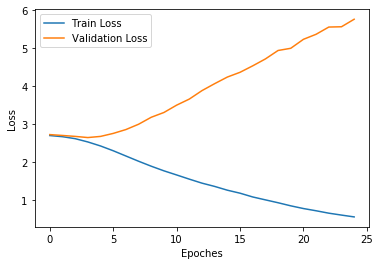

In [19]:
plt.plot(train_loss, label="Train Loss")
plt.plot(dev_loss, label="Validation Loss")
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

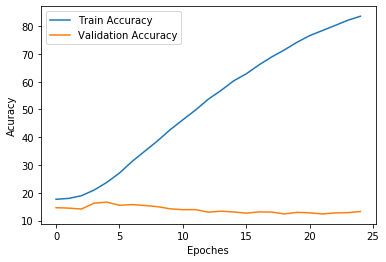

In [20]:
plt.plot(train_acc, label="Train Accuracy")
plt.plot(dev_acc, label="Validation Accuracy")
plt.xlabel('Epoches')
plt.ylabel('Acuracy')
plt.legend()
plt.show()

In [44]:
print('The best validation accuracy is %.2f%%, at epoch %i' % (max(dev_acc),np.argmax(dev_acc)))
print('The best training accuracy is %.2f%%, at epoch %i' % (max(train_acc),np.argmax(train_acc)))

The best validation accuracy is 16.61%, at epoch 4
The best training accuracy is 83.59%, at epoch 24


In [28]:
# How many word in dev not in dict
n_word = 0
for i in dev_d+dev_q:
    for w in i:
        if w not in word_dict:
            n_word += 1            

In [35]:
percent = n_word*100./len(word_dict)
print('There is %.2f%% word in validation not in training dictionary' % percent)

There is 3.34% word in validation not in training dictionary
